# +++ BUCKET 4347 +++

### Import

In [1]:
import pandas as pd
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from pylab import rcParams
from datetime import datetime
from datetime import timedelta
import matplotlib.ticker as plticker
import matplotlib.dates as mdates

from scipy import interpolate

plt.rcParams['figure.figsize'] =7.8 ,3.9
plt.rcParams['legend.fontsize'] = 11
plt.rcParams["figure.dpi"] = 300
font = {'family' : 'Times New Roman','weight' : "light", 'size'   : 11}
plt.rc('font', **font)

### Constants

In [2]:
minNumberOfElements = 10
windowSize = 23 ### To-Do: Calc Automatically
noiseFactor = 0.01
segmentMargin = 0

### Functions

In [3]:
def movingaverage (values, window):
    weights = np.repeat(1.0, window)/window
    sma = np.convolve(values, weights, 'valid')
    return sma

In [4]:
def getSegmentDelim(arr):
    result = np.array([], dtype="int")
    if arr.size == 0:
        return result
    #add First and Last Element
    result = np.append(result, arr[0])
    result = np.append(result, arr[-1])
    
    for idx, x in np.ndenumerate(arr):
        i = idx[0] + 1
        if i < arr.size:
            if (x+1) != (arr[i]):
                result = np.append(result, [x], axis=0)
                result = np.append(result, [arr[i]], axis=0)
    return np.sort(result)

In [5]:
def removeDuplCompl(arr):
    result = np.array([], dtype="int")
    skipped = []
    result = np.append(result, arr[-1])
    for idx, x in np.ndenumerate(arr):
        if (idx[0] +1) < arr.size:
            if (x == arr[idx[0] +1])|(x == arr[idx[0] +1]-1)|(x == arr[idx[0] +1]-2):
                skipped.append(x)  
            if x not in skipped:
                result = np.append(result, [x], axis=0)
    return np.sort(result)

In [6]:
def levels_dbmyA(Aout):
    """ calcs the voltage levels
    / replaces 0 with 1e-3
    / dBμV = 20log₁₀(VOUT/1μV) where VOUT in μV
    / 1V = 120dbmyV
    /dBμV or dBuV (decibel microvolt, amplitude ratio) — absolute voltage in decibels relative to one microvolt, 
    used to measure the signal strength in RF and audio cables. That is dBμV = 20log₁₀(VOUT/1μV) where VOUT in μV. This shows that dBμV is independent of impedance. Since it is the ratio of two voltages, they can be measured as peak-to-peak or RMS and with the same units. Reference voltage 1 μV.
    """
    a = np.array(Aout.values.tolist())
    Aout = pd.DataFrame(np.where(a < 1e-6, 1e-6, a).tolist())

    Aout = Aout/1e-6
    Aout = np.log10(Aout)
    Aout = Aout*20
    return Aout

In [7]:
def generateXAxisData():
    return np.linspace(2000, 149950, 2960)

### Load Data

In [8]:
datelist = pd.date_range(start="2017-03-02", end="2018-02-17").strftime("%Y-%m-%d").astype(str).to_list()
#datelist = pd.date_range(start="2018-01-02", end="2018-01-20").strftime("%Y-%m-%d").astype(str).to_list()

#datelist = ["2017-03-23"]

In [9]:
rmsi_all_p1 = pd.DataFrame()
shi_all_p1 = pd.DataFrame()
rmsi_all_p2 = pd.DataFrame()
shi_all_p2 = pd.DataFrame()
rmsi_all_p3 = pd.DataFrame()
shi_all_p3 = pd.DataFrame()

for date in datelist:
    rmsi_all_p1 = rmsi_all_p1.append(pd.read_pickle("E:\\resampled_phasevise\\rmsi\\" + date + "_rmsi_10min_mean_p1.p"))
    shi_all_p1 = shi_all_p1.append(pd.read_pickle("E:\\resampled_phasevise\\i\\" + date + "_harmonics10min_i_mean_p1.p"))
    
    rmsi_all_p2 = rmsi_all_p2.append(pd.read_pickle("E:\\resampled_phasevise\\rmsi\\" + date + "_rmsi_10min_mean_p2.p"))
    shi_all_p2 = shi_all_p2.append(pd.read_pickle("E:\\resampled_phasevise\\i\\" + date + "_harmonics10min_i_mean_p2.p"))
    
    rmsi_all_p3 = rmsi_all_p3.append(pd.read_pickle("E:\\resampled_phasevise\\rmsi\\" + date + "_rmsi_10min_mean_p3.p"))
    shi_all_p3 = shi_all_p3.append(pd.read_pickle("E:\\resampled_phasevise\\i\\" + date + "_harmonics10min_i_mean_p3.p"))

### Filter Data by RMSI-Value

In [10]:
mask_p1 = (rmsi_all_p1 < 47) & (rmsi_all_p1 >43)
#mask_p1 = rmsi_all_p1 < 2
rmsi_4347_p1 = rmsi_all_p1[mask_p1]

mask_p2 = (rmsi_all_p2 < 47) & (rmsi_all_p2 >43)
#mask_p2 = rmsi_all_p2 < 2
rmsi_4347_p2 = rmsi_all_p2[mask_p2]

mask_p3 = (rmsi_all_p3 < 47) & (rmsi_all_p3 >43)
#mask_p3 = rmsi_all_p3 < 2
rmsi_4347_p3 = rmsi_all_p3[mask_p3]

### Seperate Segments with no interruption (by NAN-Values)

In [11]:
segments_p3 = np.split(rmsi_4347_p3, np.where(np.isnan(rmsi_4347_p3.values))[0])
# removing NaN entries
segments_p3 = [seg[~np.isnan(seg.values)] for seg in segments_p3 if not isinstance(seg, np.ndarray)]
# removing DataFrames with less than minimum Elements
segments_p3 = [seg for seg in segments_p3 if len(seg)>=minNumberOfElements]
print(str(len(segments_p3)) + " Segments Found in Phase 3")

segments_p2 = np.split(rmsi_4347_p2, np.where(np.isnan(rmsi_4347_p2.values))[0])
# removing NaN entries
segments_p2 = [seg[~np.isnan(seg.values)] for seg in segments_p2 if not isinstance(seg, np.ndarray)]
# removing DataFrames with less than minimum Elements
segments_p2 = [seg for seg in segments_p2 if len(seg)>=minNumberOfElements]
print(str(len(segments_p2)) + " Segments Found in Phase 2")

segments_p1 = np.split(rmsi_4347_p1, np.where(np.isnan(rmsi_4347_p1.values))[0])
# removing NaN entries
segments_p1 = [seg[~np.isnan(seg.values)] for seg in segments_p1 if not isinstance(seg, np.ndarray)]
# removing DataFrames with less than minimum Elements
segments_p1 = [seg for seg in segments_p1 if len(seg)>=minNumberOfElements]
print(str(len(segments_p1)) + " Segments Found in Phase 1")

14 Segments Found in Phase 3
11 Segments Found in Phase 2
4 Segments Found in Phase 1


### Average Lenght of Segments:

In [12]:
seg_len = 0
for seg in segments_p1:
    #print(len(seg.index))
    seg_len += len(seg.index)
seg_len = seg_len/len(segments_p1)
print("Average Length Segment Phase 1: " + str((seg_len * 10)/60) + " h")

seg_len = 0
for seg in segments_p2:
    #print(len(seg.index))
    seg_len += len(seg.index)
seg_len = seg_len/len(segments_p2)
print("Average Length Segment Phase 2: " + str((seg_len * 10)/60) + " h")

seg_len = 0
for seg in segments_p3:
    #print(len(seg.index))
    seg_len += len(seg.index)
seg_len = seg_len/len(segments_p3)
print("Average Length Segment Phase 3: " + str((seg_len * 10)/60) + " h")

Average Length Segment Phase 1: 1.875 h
Average Length Segment Phase 2: 2.1363636363636362 h
Average Length Segment Phase 3: 1.9285714285714284 h


### Average Variance of Segments:

In [13]:
var_p1 = 0
for ts in segments_p1:
    var_p1 += np.var(ts.values)
var_p1 = var_p1 / len(segments_p1)
print("Average Variance of Segments in Phase 1: " + str(var_p1))

var_p2 = 0
for ts in segments_p2:
    var_p2 += np.var(ts.values)
var_p2 = var_p2 / len(segments_p2)
print("Average Variance of Segments in Phase 2: " + str(var_p2))

var_p3 = 0
for ts in segments_p3:
    var_p3 += np.var(ts.values)
var_p3 = var_p3 / len(segments_p3)
print("Average Variance of Segments in Phase 3: " + str(var_p3))

Average Variance of Segments in Phase 1: 0.19157794676721096
Average Variance of Segments in Phase 2: 0.2026806913781911
Average Variance of Segments in Phase 3: 0.19094117790726678


### Splitting Values and Indices

In [14]:
seg_values_p1 = []
seg_indices_p1 = []
for seg in segments_p1:
    seg_values_p1.append(seg.values.flatten())
    seg_indices_p1.append(seg.index)
    
seg_values_p2 = []
seg_indices_p2 = []
for seg in segments_p2:
    seg_values_p2.append(seg.values.flatten())
    seg_indices_p2.append(seg.index)
    
seg_values_p3 = []
seg_indices_p3 = []
for seg in segments_p3:
    seg_values_p3.append(seg.values.flatten())
    seg_indices_p3.append(seg.index)

### Calculate NoiseLimits

In [15]:
mav_p1 = []
upper_noise_p1 = []
lower_noise_p1 = []
for seg in seg_values_p1:
    # To-Do: Automatically set WindowSize depending on Segment-Len
    #if windowSize > seg.size:
    windowSizeUsed = seg.size - 1
    #else:
     #   windowSizeUsed = windowSize
    segMav = movingaverage(seg, windowSizeUsed)
    segMav_interp = interpolate.interp1d(np.arange(segMav.size), segMav)
    segMav_stretch = segMav_interp(np.linspace(0,segMav.size-1, seg.size))
    mav_p1.append(segMav_stretch)
    upper_noise_p1.append(segMav_stretch + noiseFactor*segMav_stretch)
    lower_noise_p1.append(segMav_stretch - noiseFactor*segMav_stretch)
    
mav_p2 = []
upper_noise_p2 = []
lower_noise_p2 = []
for seg in seg_values_p2:
    # To-Do: Automatically set WindowSize depending on Segment-Len
    #if windowSize > seg.size:
    windowSizeUsed = seg.size - 1
    #else:
     #   windowSizeUsed = windowSize
    segMav = movingaverage(seg, windowSizeUsed)
    segMav_interp = interpolate.interp1d(np.arange(segMav.size), segMav)
    segMav_stretch = segMav_interp(np.linspace(0,segMav.size-1, seg.size))
    mav_p2.append(segMav_stretch)
    upper_noise_p2.append(segMav_stretch + noiseFactor*segMav_stretch)
    lower_noise_p2.append(segMav_stretch - noiseFactor*segMav_stretch)
    
mav_p3 = []
upper_noise_p3 = []
lower_noise_p3 = []
for seg in seg_values_p3:
    # To-Do: Automatically set WindowSize depending on Segment-Len
    #if windowSize > seg.size:
    windowSizeUsed = seg.size - 1
    #else:
     #   windowSizeUsed = windowSize
    segMav = movingaverage(seg, windowSizeUsed)
    segMav_interp = interpolate.interp1d(np.arange(segMav.size), segMav)
    segMav_stretch = segMav_interp(np.linspace(0,segMav.size-1, seg.size))
    mav_p3.append(segMav_stretch)
    upper_noise_p3.append(segMav_stretch + noiseFactor*segMav_stretch)
    lower_noise_p3.append(segMav_stretch - noiseFactor*segMav_stretch)

### Find Outlying Elements

In [16]:
lower_outliers_idx_p1 = []
upper_outliers_idx_p1 = []
all_outliers_idx_p1 = []
for idx, segv in enumerate(seg_values_p1):
    lower_outliers = ((np.argwhere(segv < lower_noise_p1[idx])).flatten())
    upper_outliers = ((np.argwhere(segv > upper_noise_p1[idx])).flatten())
    allout = np.append(lower_outliers, upper_outliers)
    allout = np.sort(allout)
    all_outliers_idx_p1.append(allout)

lower_outliers_idx_p2 = []
upper_outliers_idx_p2 = []
all_outliers_idx_p2 = []
for idx, segv in enumerate(seg_values_p2):
    lower_outliers = ((np.argwhere(segv < lower_noise_p2[idx])).flatten())
    upper_outliers = ((np.argwhere(segv > upper_noise_p2[idx])).flatten())
    allout = np.append(lower_outliers, upper_outliers)
    allout = np.sort(allout)
    all_outliers_idx_p2.append(allout)
    
lower_outliers_idx_p3 = []
upper_outliers_idx_p3 = []
all_outliers_idx_p3 = []
for idx, segv in enumerate(seg_values_p3):
    lower_outliers = ((np.argwhere(segv < lower_noise_p3[idx])).flatten())
    upper_outliers = ((np.argwhere(segv > upper_noise_p3[idx])).flatten())
    allout = np.append(lower_outliers, upper_outliers)
    allout = np.sort(allout)
    all_outliers_idx_p3.append(allout)

### Find Delimiters of SubSegments

In [17]:
subSeg_delim_idx_p1 = []
for outl in all_outliers_idx_p1:
    if len(outl)>1:
        subSeg_delim_idx_p1.append(removeDuplCompl(getSegmentDelim(outl)))
    else:
        subSeg_delim_idx_p1.append([])
        
subSeg_delim_idx_p2 = []
for outl in all_outliers_idx_p2:
    if len(outl)>1:
        subSeg_delim_idx_p2.append(removeDuplCompl(getSegmentDelim(outl)))
    else:
        subSeg_delim_idx_p2.append([])
        
subSeg_delim_idx_p3 = []
for outl in all_outliers_idx_p3:
    if len(outl)>1:
        subSeg_delim_idx_p3.append(removeDuplCompl(getSegmentDelim(outl)))
    else:
        subSeg_delim_idx_p3.append([])

### Plot Segments Phase 1

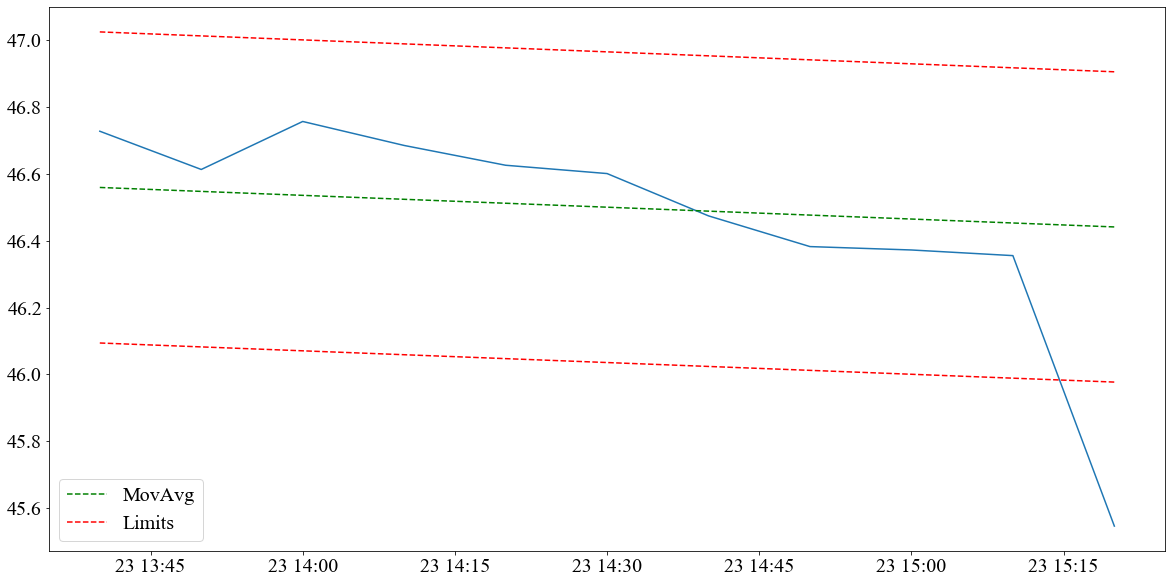

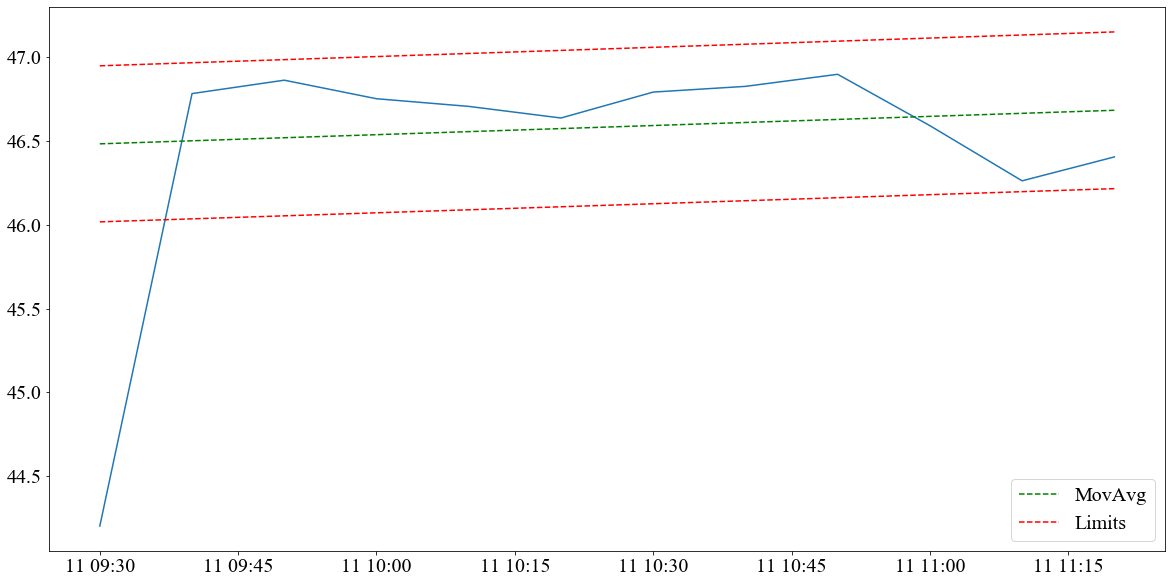

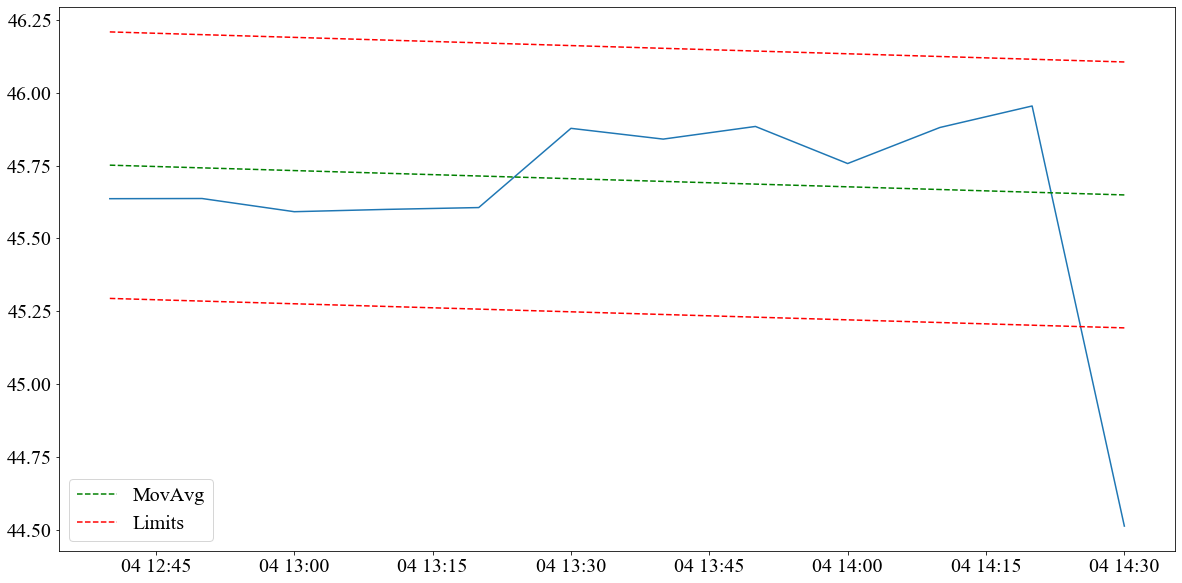

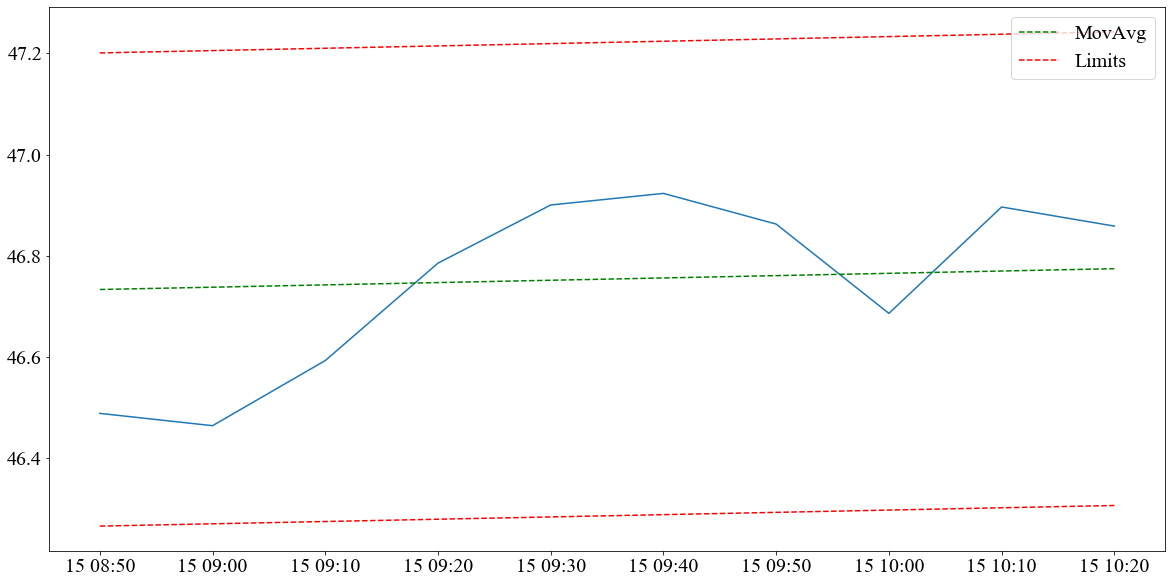

In [18]:
for idx, segv in enumerate(segments_p1):
    plt.plot(segv)
    plt.plot(seg_indices_p1[idx], mav_p1[idx], linestyle='--', color='green', label="MovAvg")
    plt.plot(seg_indices_p1[idx], upper_noise_p1[idx], linestyle='--', color='red', label="Limits")
    plt.plot(seg_indices_p1[idx], lower_noise_p1[idx], linestyle='--', color='red')
    for delim in subSeg_delim_idx_p1[idx]:
        plt.vlines(seg_indices_p1[idx][delim], seg_values_p1[idx].min() ,seg_values_p1[idx].max())
    plt.legend()
    plt.show()

### Plot Segments Phase 2

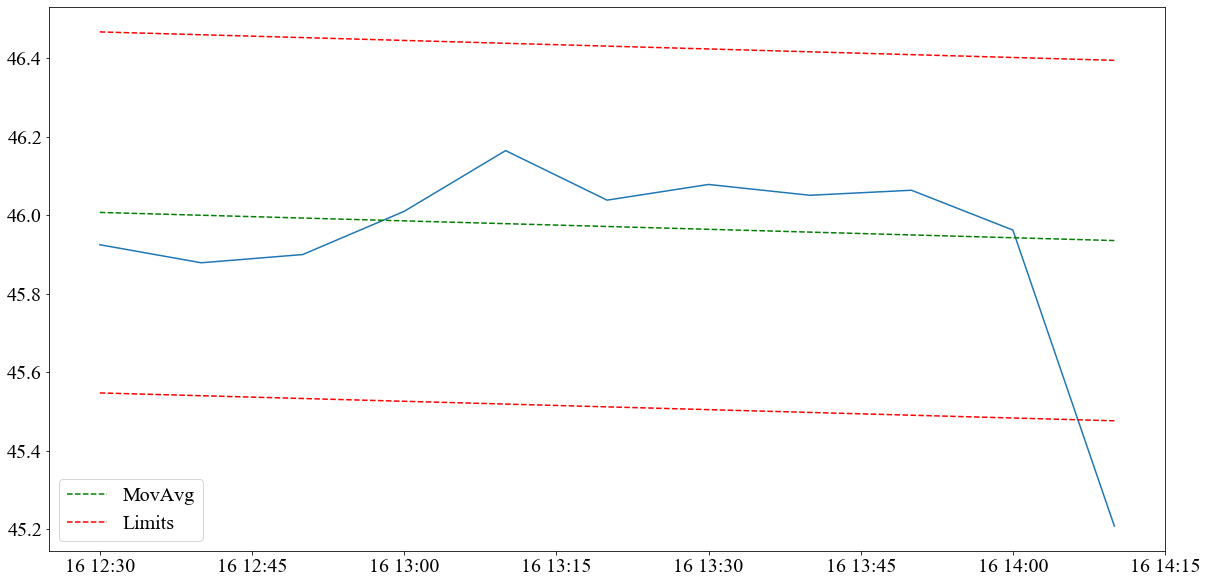

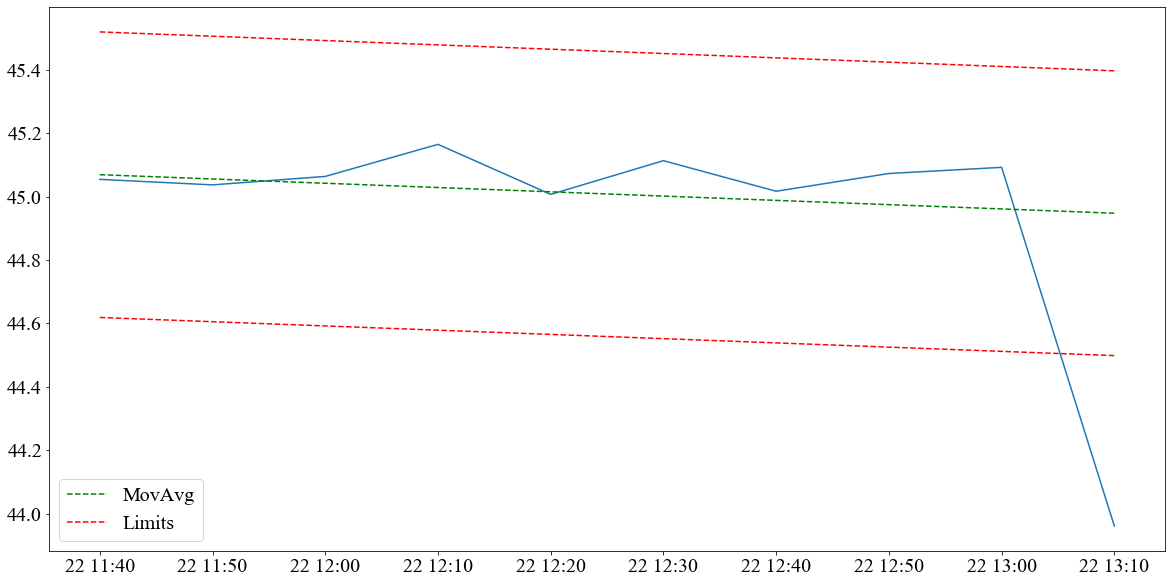

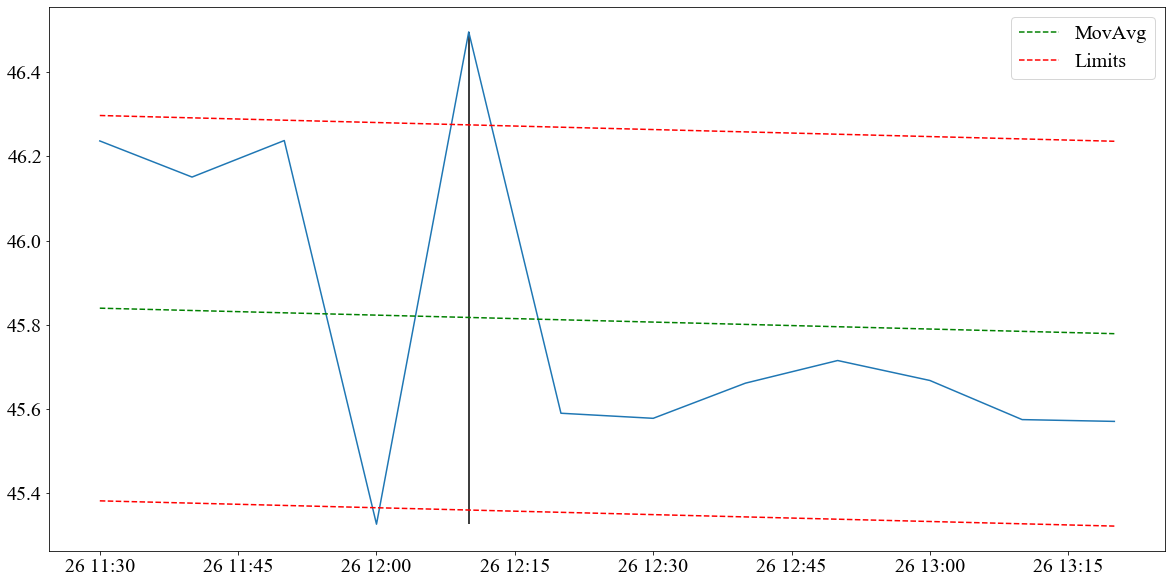

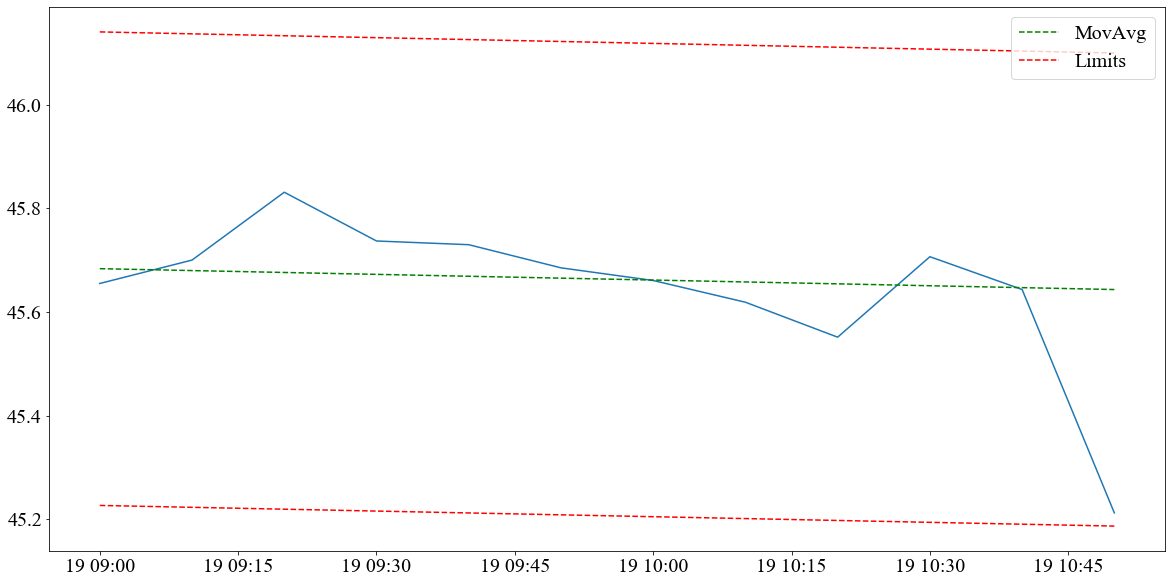

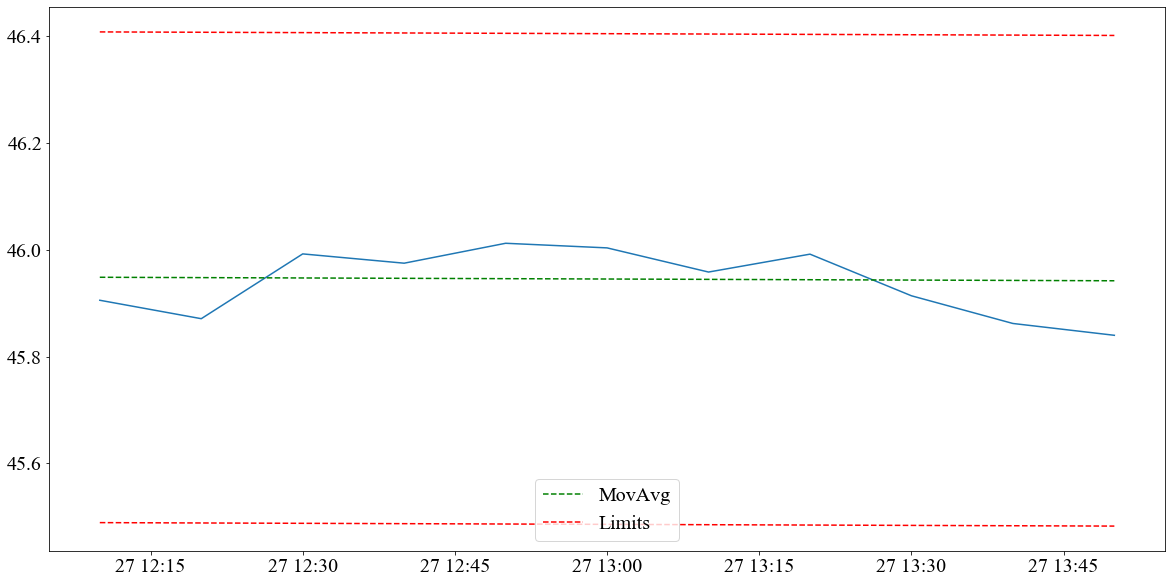

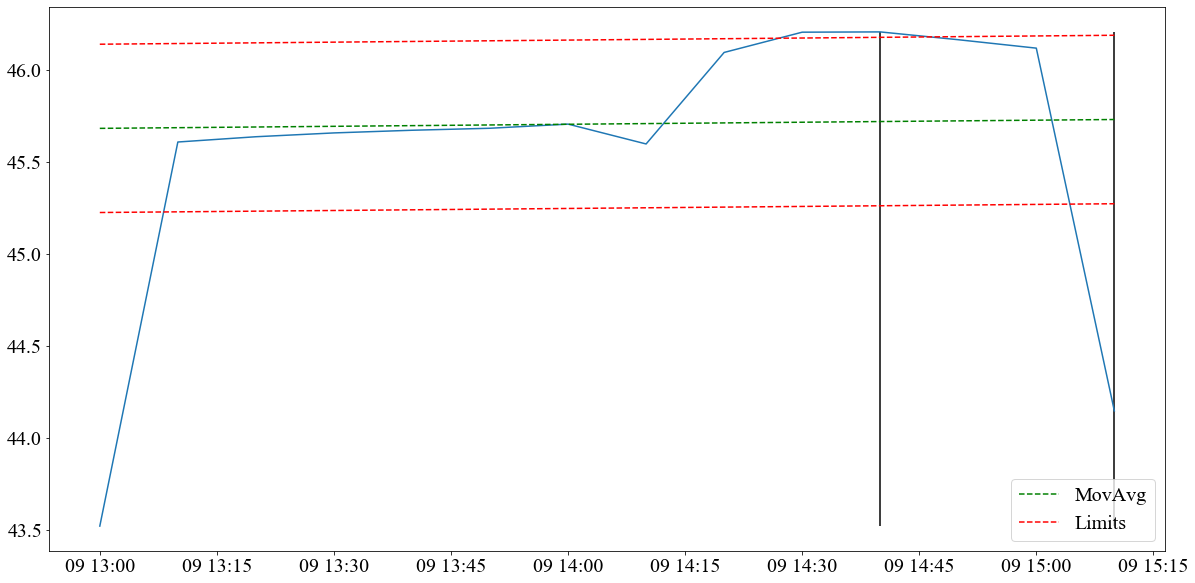

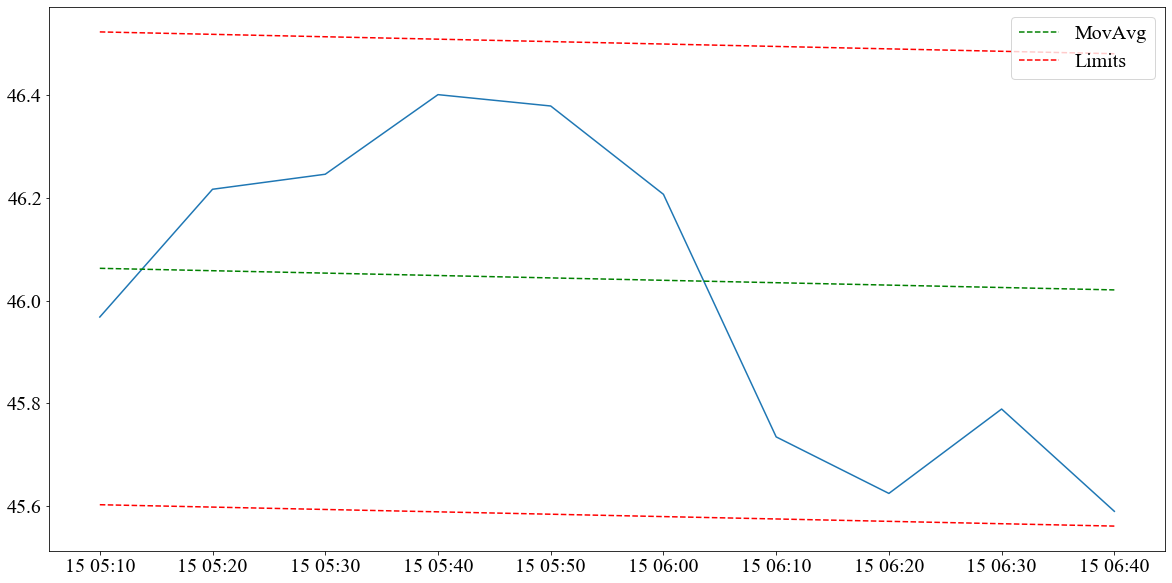

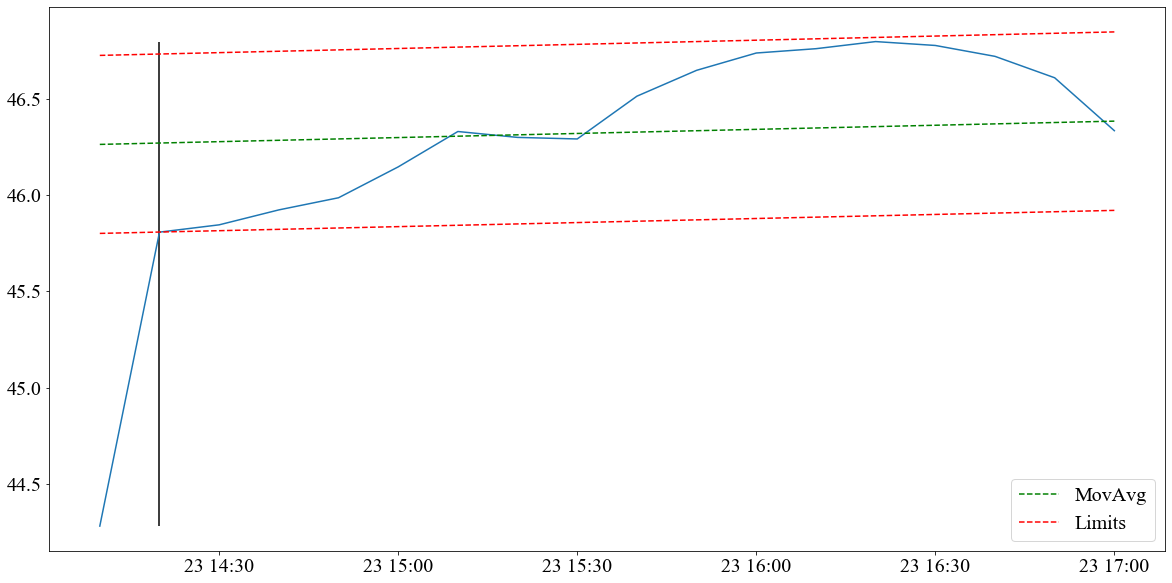

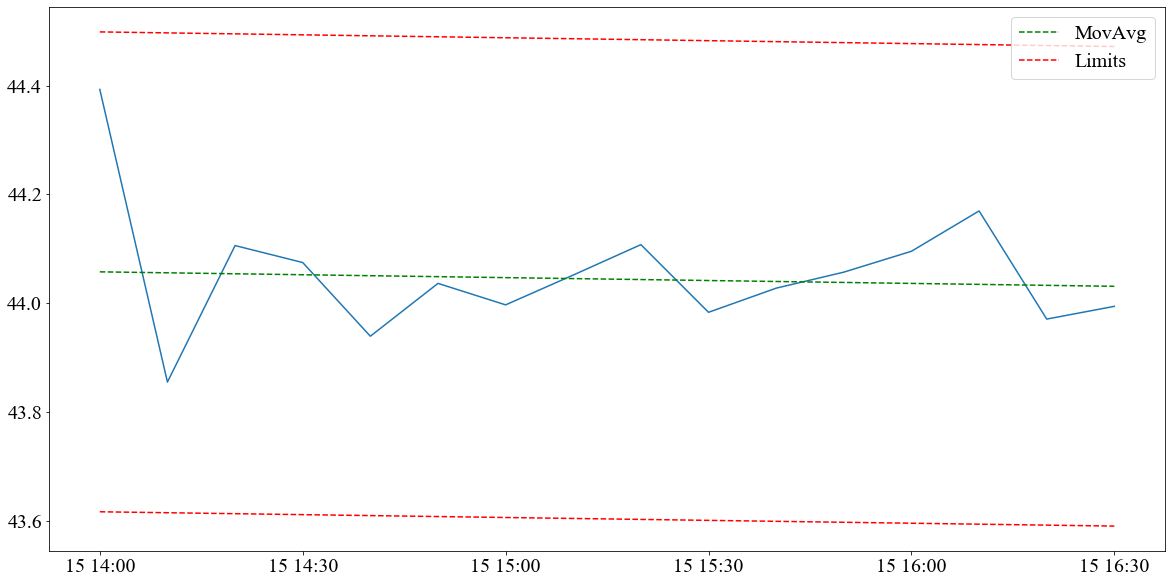

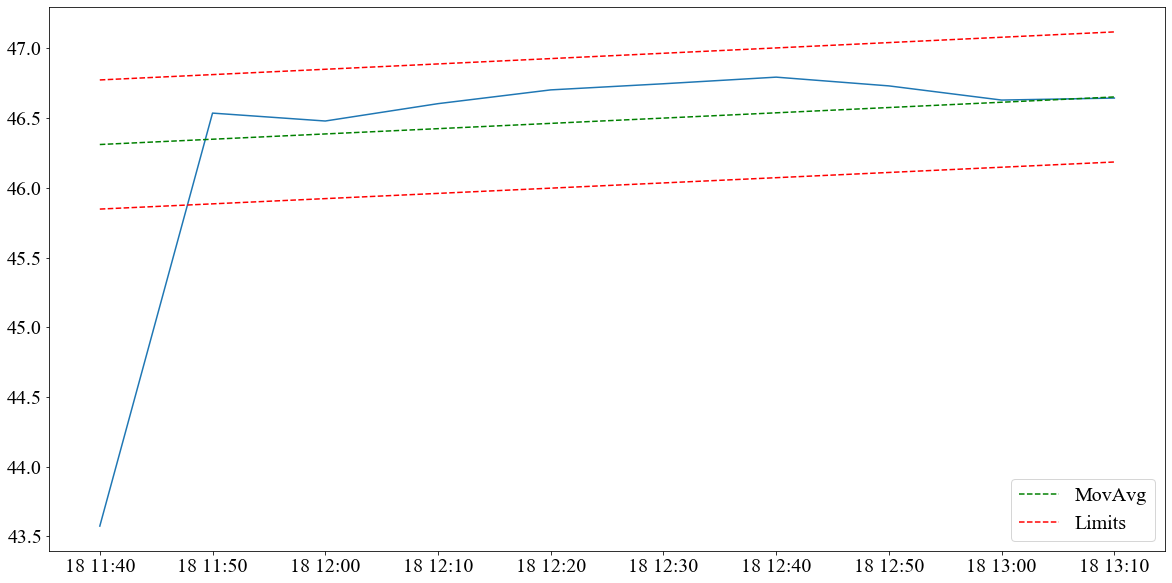

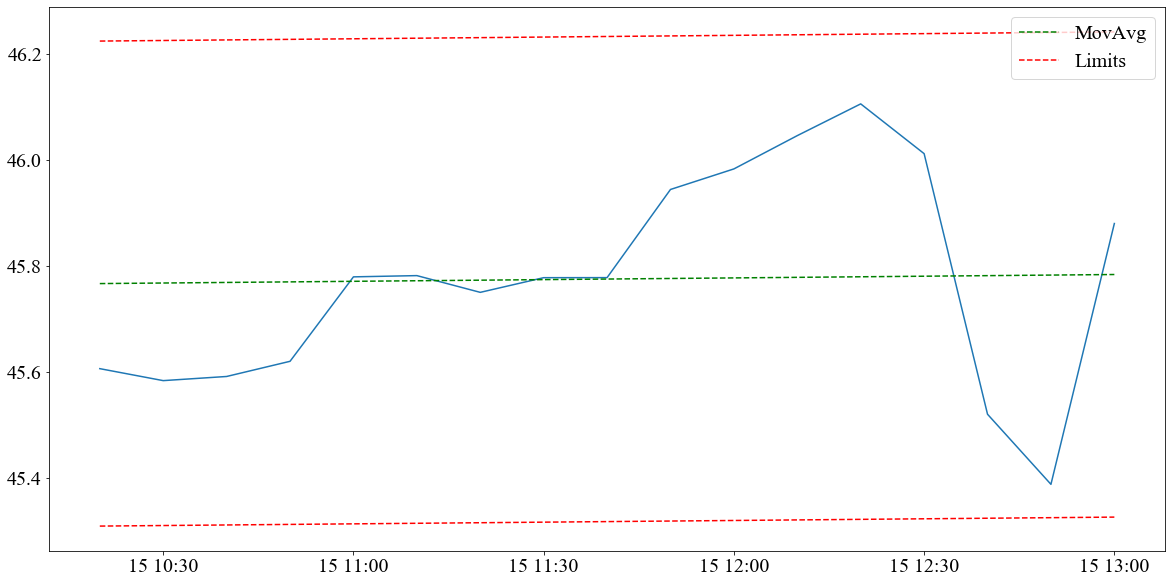

In [19]:
for idx, segv in enumerate(segments_p2):
    plt.plot(segv)
    plt.plot(seg_indices_p2[idx], mav_p2[idx], linestyle='--', color='green', label="MovAvg")
    plt.plot(seg_indices_p2[idx], upper_noise_p2[idx], linestyle='--', color='red', label="Limits")
    plt.plot(seg_indices_p2[idx], lower_noise_p2[idx], linestyle='--', color='red')
    for delim in subSeg_delim_idx_p2[idx]:
        plt.vlines(seg_indices_p2[idx][delim], seg_values_p2[idx].min() ,seg_values_p2[idx].max())
    plt.legend()
    plt.show()

### Plot Segments Phase 3

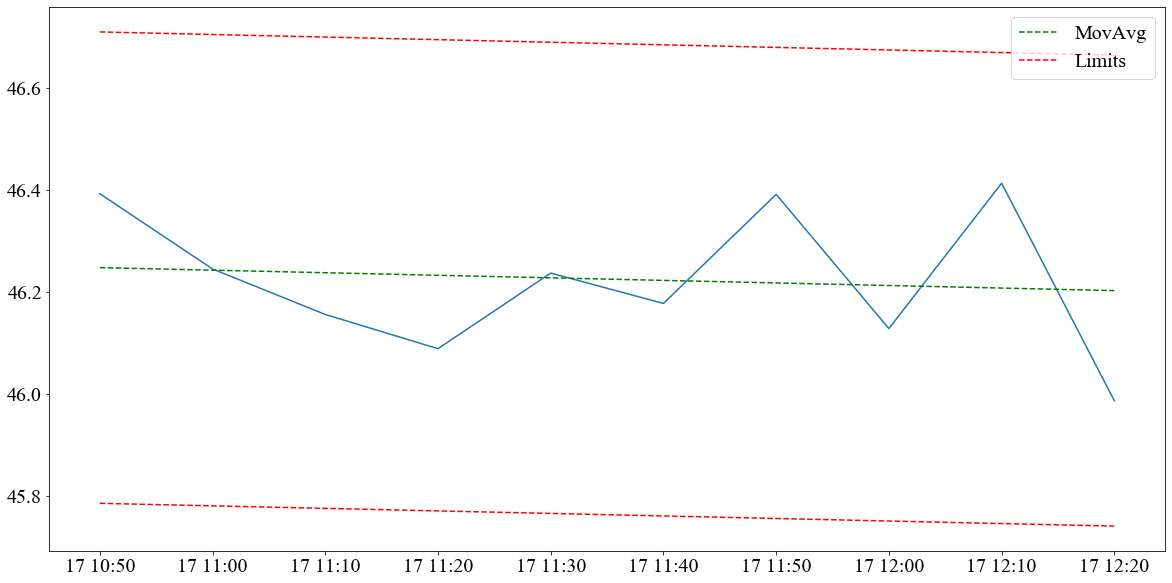

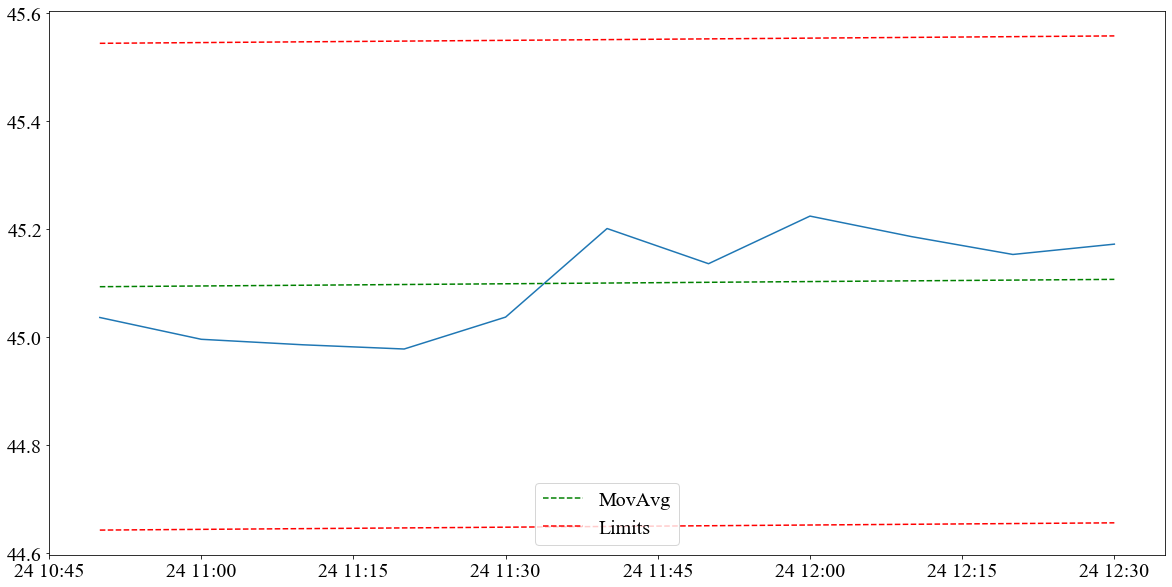

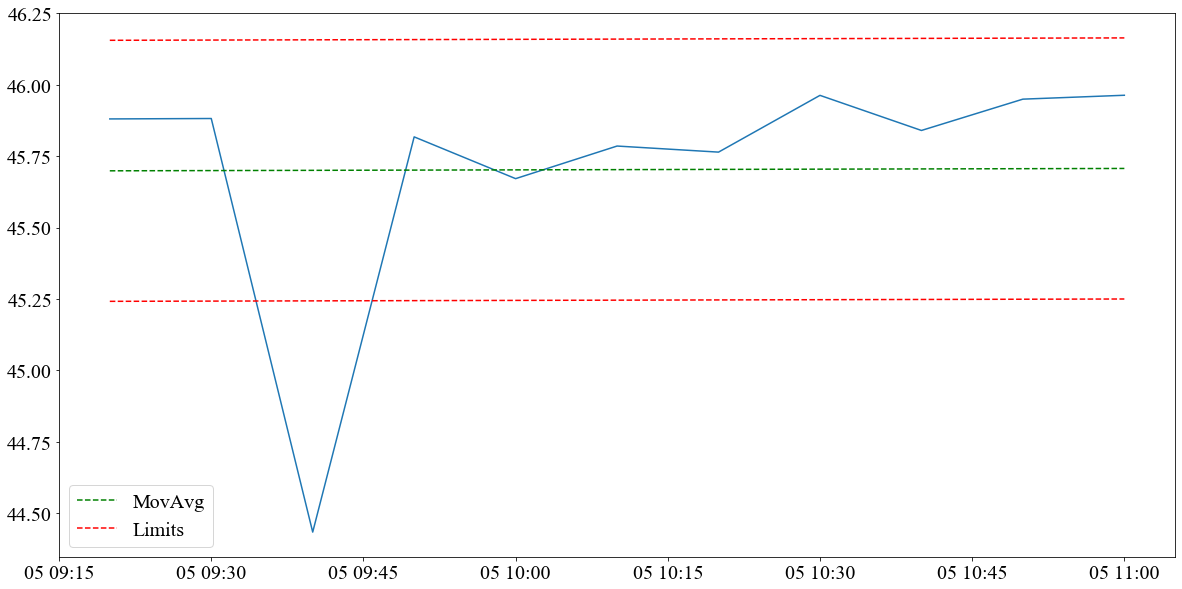

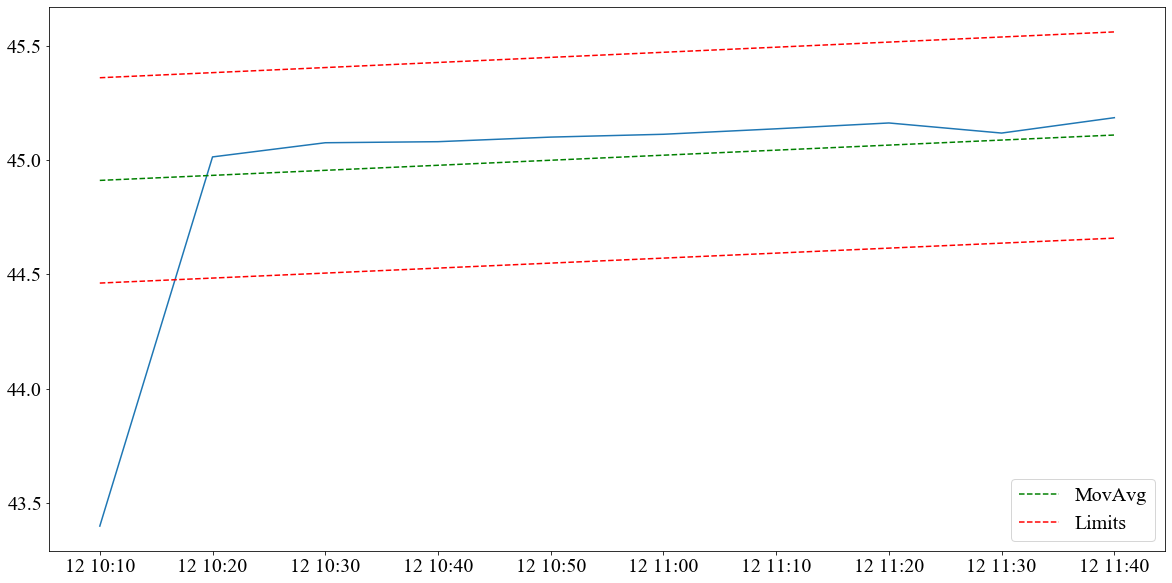

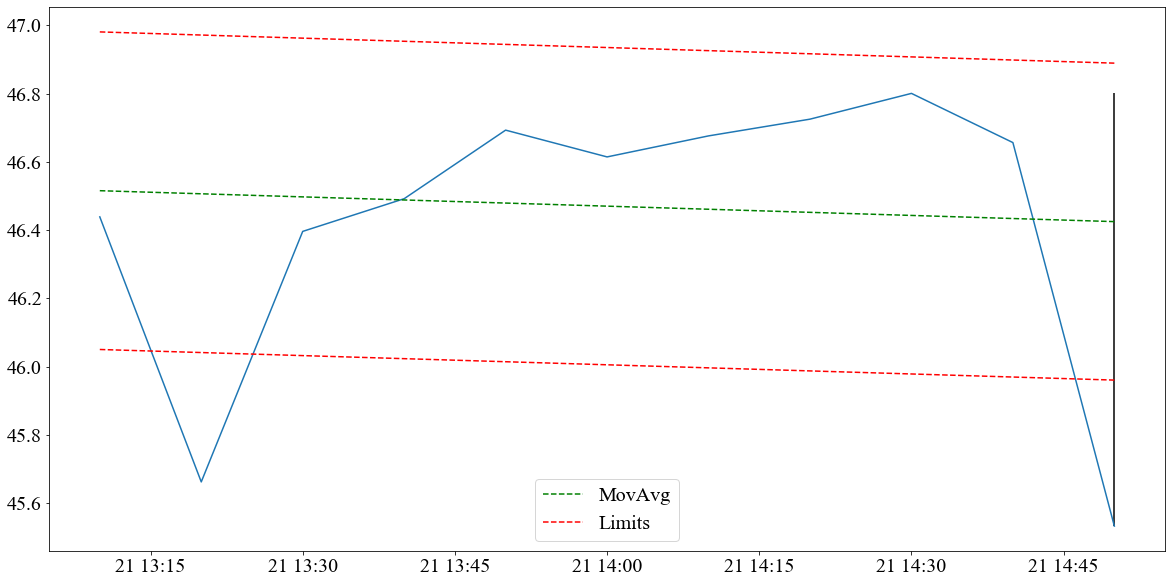

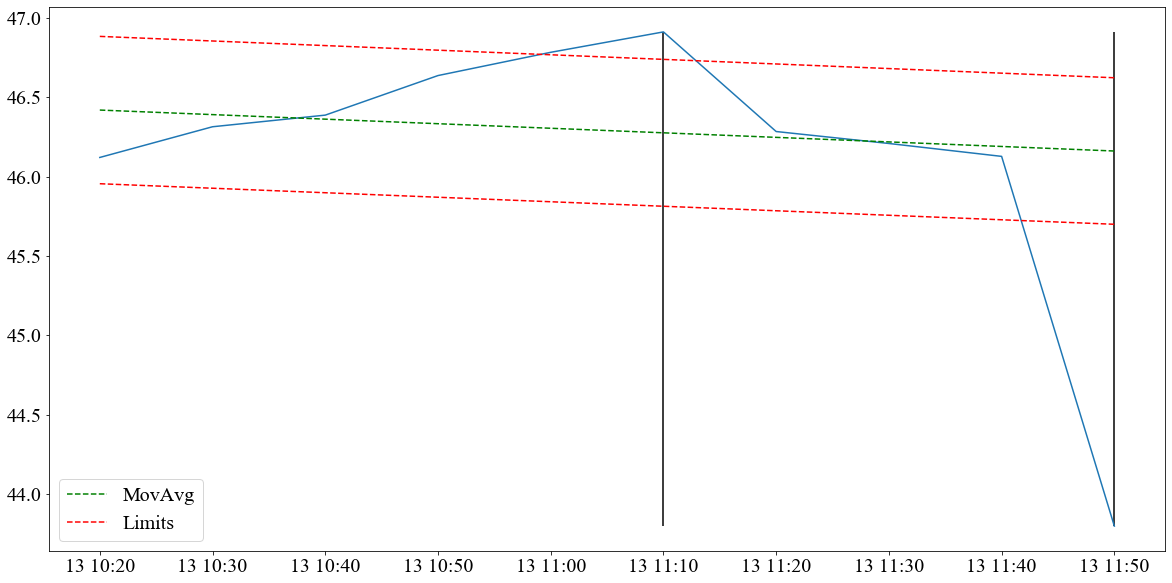

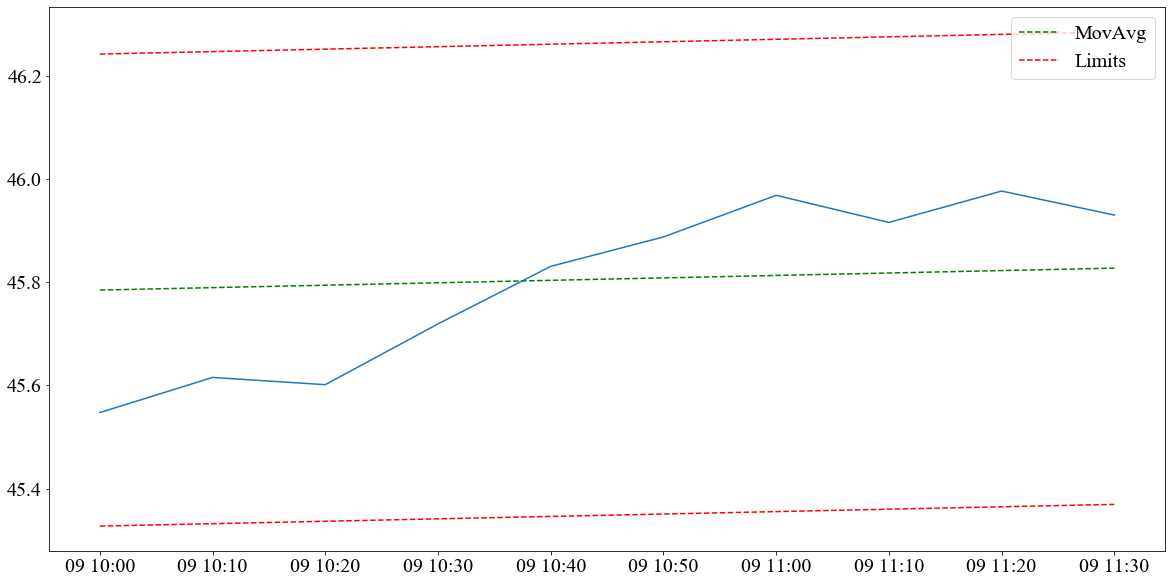

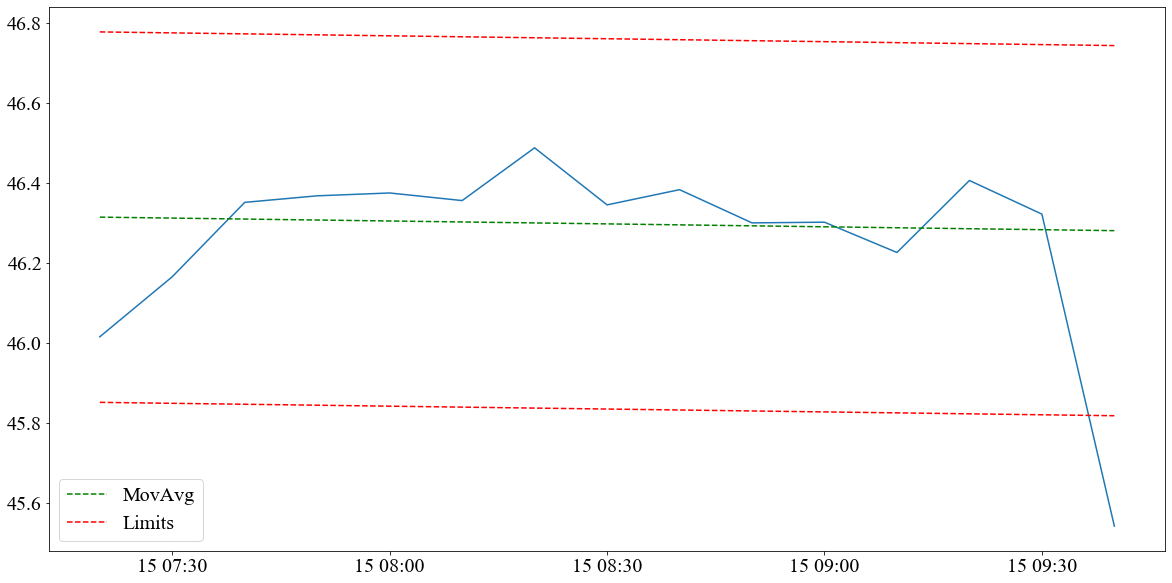

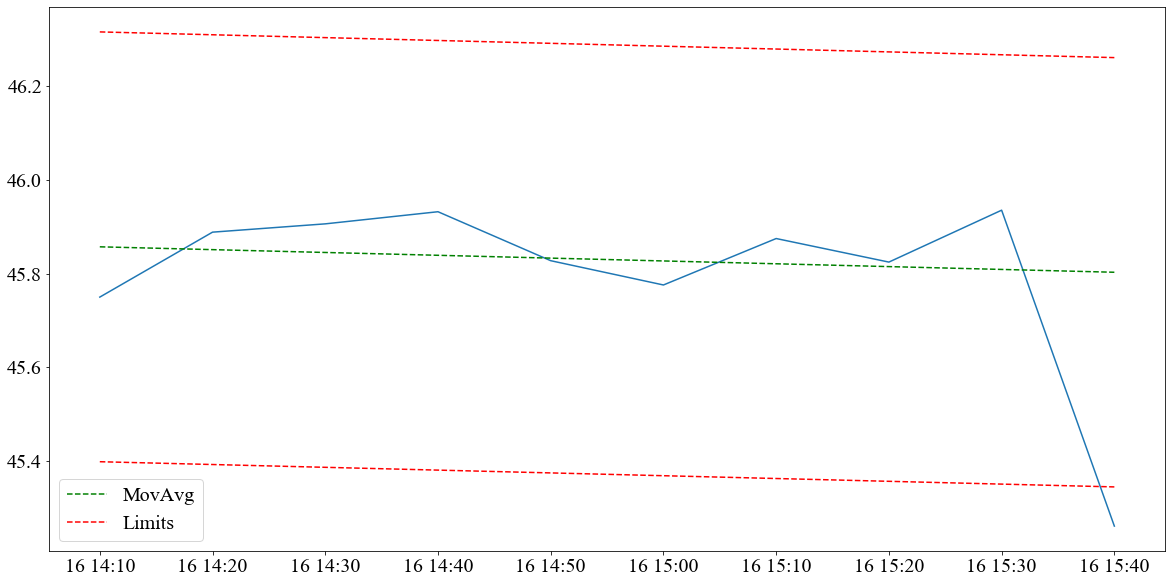

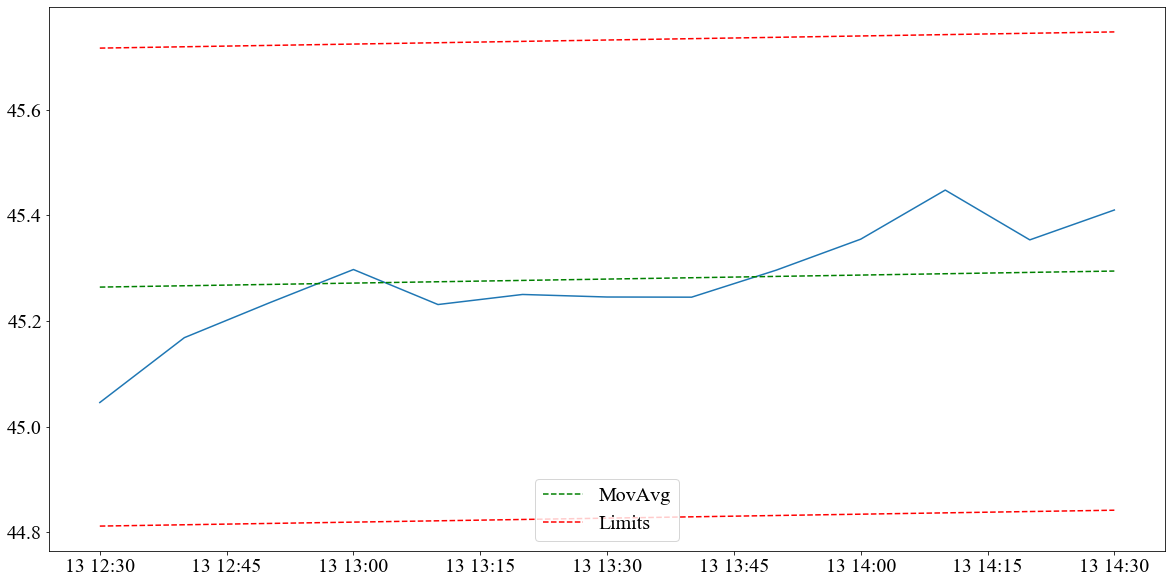

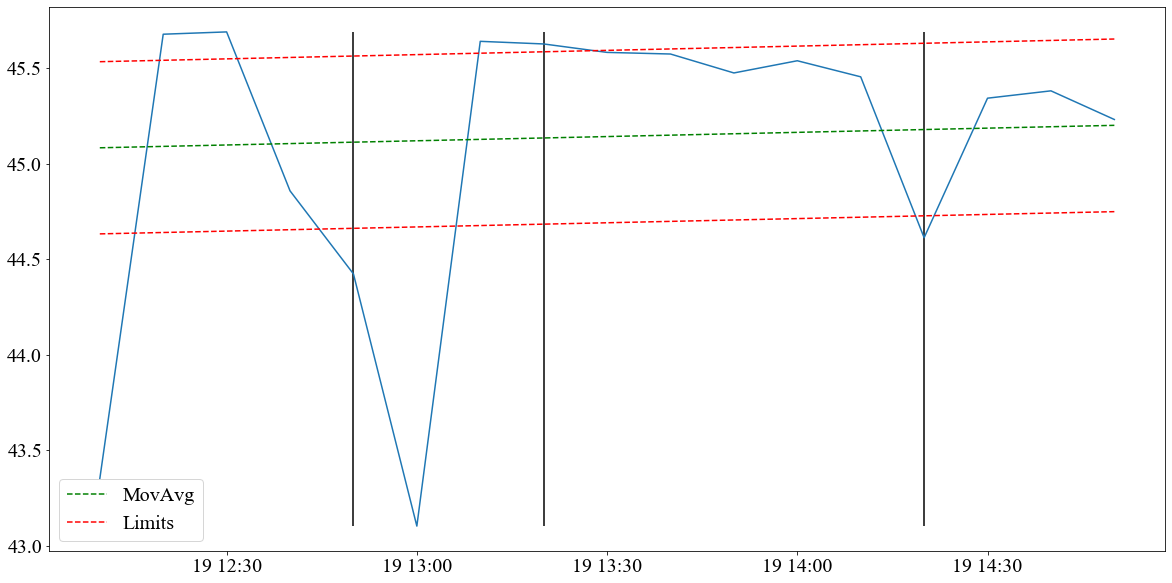

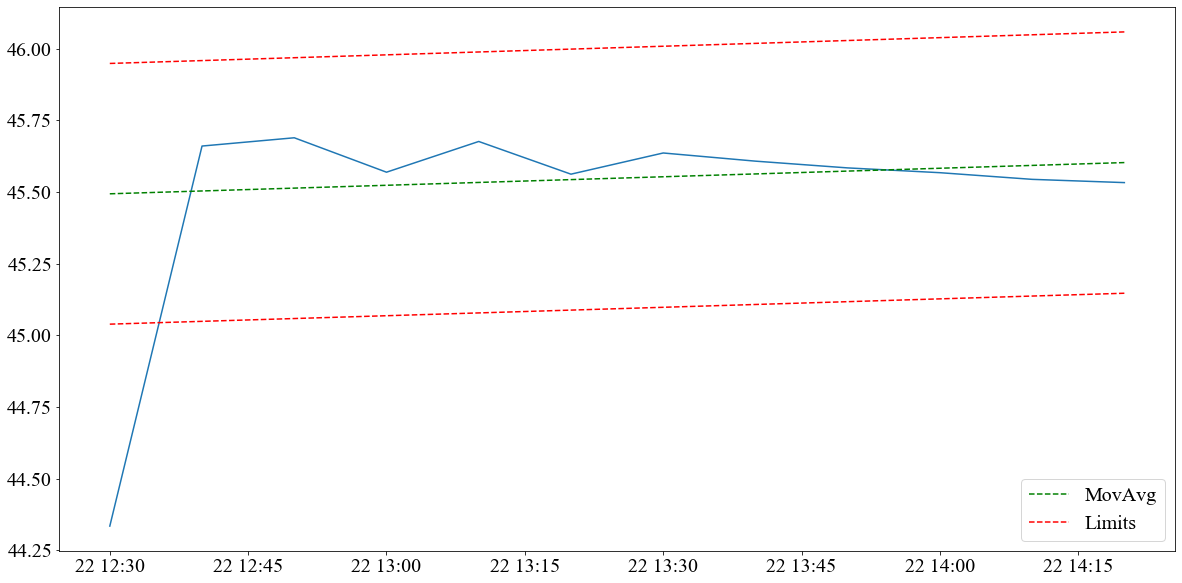

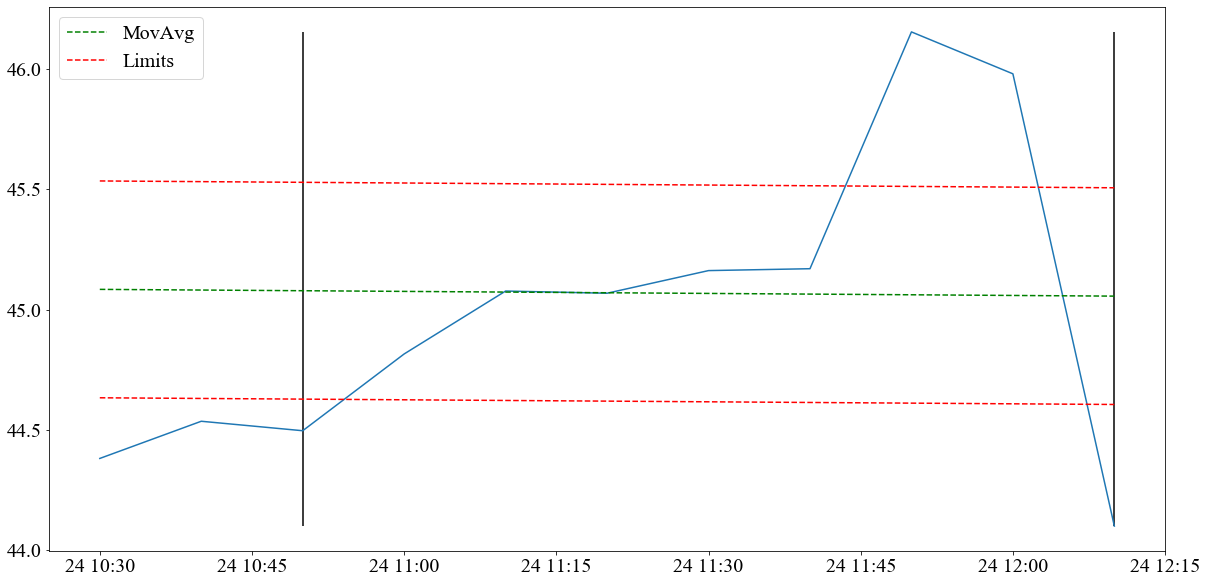

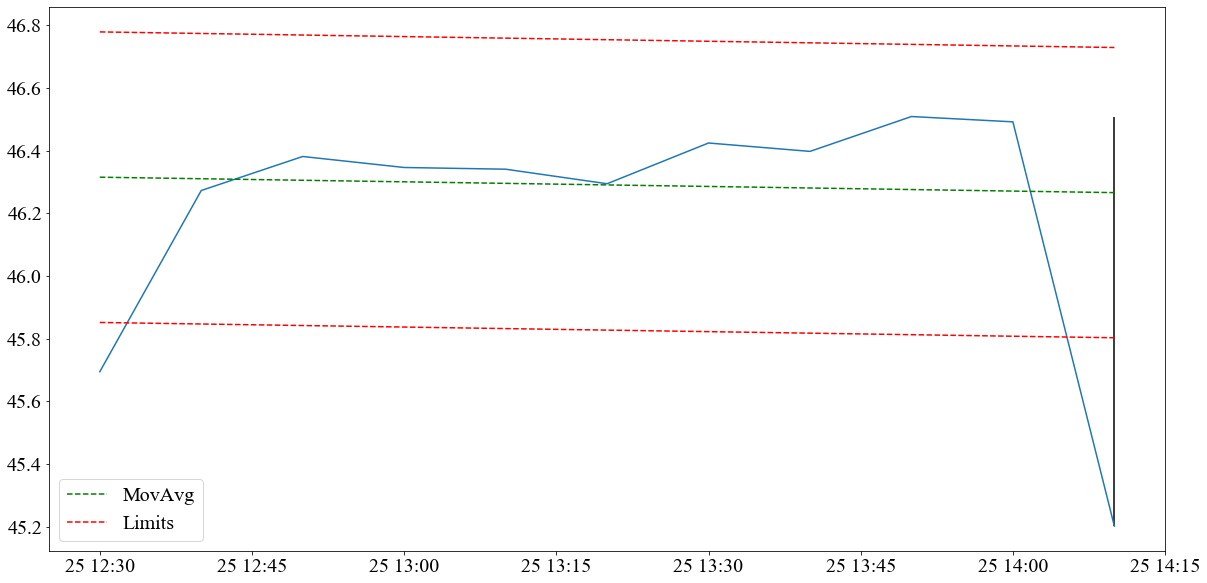

In [20]:
for idx, segv in enumerate(segments_p3):
    plt.plot(segv)
    plt.plot(seg_indices_p3[idx], mav_p3[idx], linestyle='--', color='green', label="MovAvg")
    plt.plot(seg_indices_p3[idx], upper_noise_p3[idx], linestyle='--', color='red', label="Limits")
    plt.plot(seg_indices_p3[idx], lower_noise_p3[idx], linestyle='--', color='red')
    for delim in subSeg_delim_idx_p3[idx]:
        plt.vlines(seg_indices_p3[idx][delim], seg_values_p3[idx].min() ,seg_values_p3[idx].max())
    plt.legend()
    plt.show()

### Get the Times Phase 1

In [18]:
StartStop_p1 = []
for segidx, seg in enumerate(seg_indices_p1):
    #print('Segment Nr.' + str(segidx))
    # Are there any Delimiters?
    if len(subSeg_delim_idx_p1[segidx])>1:
        #Remove first Delimiter if it is at Beginning of Segment
        if subSeg_delim_idx_p1[segidx][0] < minNumberOfElements:
            #print('First Delimiter to close to Start')
            subSeg_delim_idx_p1[segidx] = np.delete(subSeg_delim_idx_p1[segidx],0)
        #Remove last Delimiter if it is End of Segment
        if subSeg_delim_idx_p1[segidx][-1] > len(seg) - minNumberOfElements:
            #print('Last Delimiter to close to End')
            subSeg_delim_idx_p1[segidx] = np.delete(subSeg_delim_idx_p1[segidx],-1)
    
    # Are there any Delimiters left?
    if len(subSeg_delim_idx_p1[segidx]) == 0:
        #print('No Delimiters found')
        onlystart = seg[0]
        onlystop = seg[-1]
        StartStop_p1.append([onlystart,onlystop])
        continue
        
    for delimidx, delim in enumerate(subSeg_delim_idx_p1[segidx]):
        #First Delimiter?
        if delimidx == 0:
            #print("First Delimiter")
            firststart = seg[0]
            firststop = seg[delim + segmentMargin]
            StartStop_p1.append([firststart,firststop])
            continue
        #Last Delimiter?
        if delimidx == len(subSeg_delim_idx_p1[segidx])-1:
            #print("Last Delimiter")
            laststart = seg[delim - segmentMargin]
            laststop = seg[-1]
            StartStop_p1.append([laststart,laststop])
            #Only one delimiter then finished here
            if len(subSeg_delim_idx_p1[segidx]) == 1:
                #print("Only one Delimiter. Break")
                continue
            else:
                start = seg[subSeg_delim_idx_p1[segidx][delimidx-1] - segmentMargin]
                stop = seg[subSeg_delim_idx_p1[segidx][delimidx] + segmentMargin]
                StartStop_p1.append([start,stop])  
            continue
           
        start = seg[subSeg_delim_idx_p1[segidx][delimidx] - segmentMargin]
        stop = seg[subSeg_delim_idx_p1[segidx][delimidx+1] + segmentMargin]
        StartStop_p1.append([start,stop])    
print(str(len(StartStop_p1)) + ' SubSegments found in Phase 1!')

4 SubSegments found in Phase 1!


### Get the Times Phase 2

In [19]:
StartStop_p2 = []
for segidx, seg in enumerate(seg_indices_p2):
    #print('Segment Nr.' + str(segidx))
    # Are there any Delimiters?
    if len(subSeg_delim_idx_p2[segidx])>1:
        #Remove first Delimiter if it is at Beginning of Segment
        if subSeg_delim_idx_p2[segidx][0] < minNumberOfElements:
            #print('First Delimiter to close to Start')
            subSeg_delim_idx_p2[segidx] = np.delete(subSeg_delim_idx_p2[segidx],0)
        #Remove last Delimiter if it is End of Segment
        if subSeg_delim_idx_p2[segidx][-1] > len(seg) - minNumberOfElements:
            #print('Last Delimiter to close to End')
            subSeg_delim_idx_p2[segidx] = np.delete(subSeg_delim_idx_p2[segidx],-1)
    
    # Are there any Delimiters left?
    if len(subSeg_delim_idx_p2[segidx]) == 0:
        #print('No Delimiters found')
        onlystart = seg[0]
        onlystop = seg[-1]
        StartStop_p2.append([onlystart,onlystop])
        continue
        
    for delimidx, delim in enumerate(subSeg_delim_idx_p2[segidx]):
        #First Delimiter?
        if delimidx == 0:
            #print("First Delimiter")
            firststart = seg[0]
            firststop = seg[delim + segmentMargin]
            StartStop_p2.append([firststart,firststop])
            continue
        #Last Delimiter?
        if delimidx == len(subSeg_delim_idx_p2[segidx])-1:
            #print("Last Delimiter")
            laststart = seg[delim - segmentMargin]
            laststop = seg[-1]
            StartStop_p2.append([laststart,laststop])
            #Only one delimiter then finished here
            if len(subSeg_delim_idx_p2[segidx]) == 1:
                #print("Only one Delimiter. Break")
                continue
            else:
                start = seg[subSeg_delim_idx_p2[segidx][delimidx-1] - segmentMargin]
                stop = seg[subSeg_delim_idx_p2[segidx][delimidx] + segmentMargin]
                StartStop_p2.append([start,stop])  
            continue
           
        start = seg[subSeg_delim_idx_p2[segidx][delimidx] - segmentMargin]
        stop = seg[subSeg_delim_idx_p2[segidx][delimidx+1] + segmentMargin]
        StartStop_p2.append([start,stop])    
print(str(len(StartStop_p2)) + ' SubSegments found in Phase 2!')

11 SubSegments found in Phase 2!


### Get the Times Phase 3

In [20]:
StartStop_p3 = []
for segidx, seg in enumerate(seg_indices_p3):
    #print('Segment Nr.' + str(segidx))
    # Are there any Delimiters?
    if len(subSeg_delim_idx_p3[segidx])>1:
        #Remove first Delimiter if it is at Beginning of Segment
        if subSeg_delim_idx_p3[segidx][0] < minNumberOfElements:
            #print('First Delimiter to close to Start')
            subSeg_delim_idx_p3[segidx] = np.delete(subSeg_delim_idx_p3[segidx],0)
        #Remove last Delimiter if it is End of Segment
        if subSeg_delim_idx_p3[segidx][-1] > len(seg) - minNumberOfElements:
            #print('Last Delimiter to close to End')
            subSeg_delim_idx_p3[segidx] = np.delete(subSeg_delim_idx_p3[segidx],-1)
    
    # Are there any Delimiters left?
    if len(subSeg_delim_idx_p3[segidx]) == 0:
        #print('No Delimiters found')
        onlystart = seg[0]
        onlystop = seg[-1]
        StartStop_p3.append([onlystart,onlystop])
        continue
        
    for delimidx, delim in enumerate(subSeg_delim_idx_p3[segidx]):
        #First Delimiter?
        if delimidx == 0:
            #print("First Delimiter")
            firststart = seg[0]
            firststop = seg[delim + segmentMargin]
            StartStop_p3.append([firststart,firststop])
            continue
        #Last Delimiter?
        if delimidx == len(subSeg_delim_idx_p3[segidx])-1:
            #print("Last Delimiter")
            laststart = seg[delim - segmentMargin]
            laststop = seg[-1]
            StartStop_p3.append([laststart,laststop])
            #Only one delimiter then finished here
            if len(subSeg_delim_idx_p3[segidx]) == 1:
                #print("Only one Delimiter. Break")
                continue
            else:
                start = seg[subSeg_delim_idx_p3[segidx][delimidx-1] - segmentMargin]
                stop = seg[subSeg_delim_idx_p3[segidx][delimidx] + segmentMargin]
                StartStop_p3.append([start,stop])  
            continue
           
        start = seg[subSeg_delim_idx_p3[segidx][delimidx] - segmentMargin]
        stop = seg[subSeg_delim_idx_p3[segidx][delimidx+1] + segmentMargin]
        StartStop_p3.append([start,stop])    
print(str(len(StartStop_p3)) + ' SubSegments found in Phase 3!')

14 SubSegments found in Phase 3!


Average length of SubSegments Phase 1: 0 days 01:42:30
Average length of SubSegments Phase 2: 0 days 01:34:32.727272
Average length of SubSegments Phase 3: 0 days 01:39:17.142857


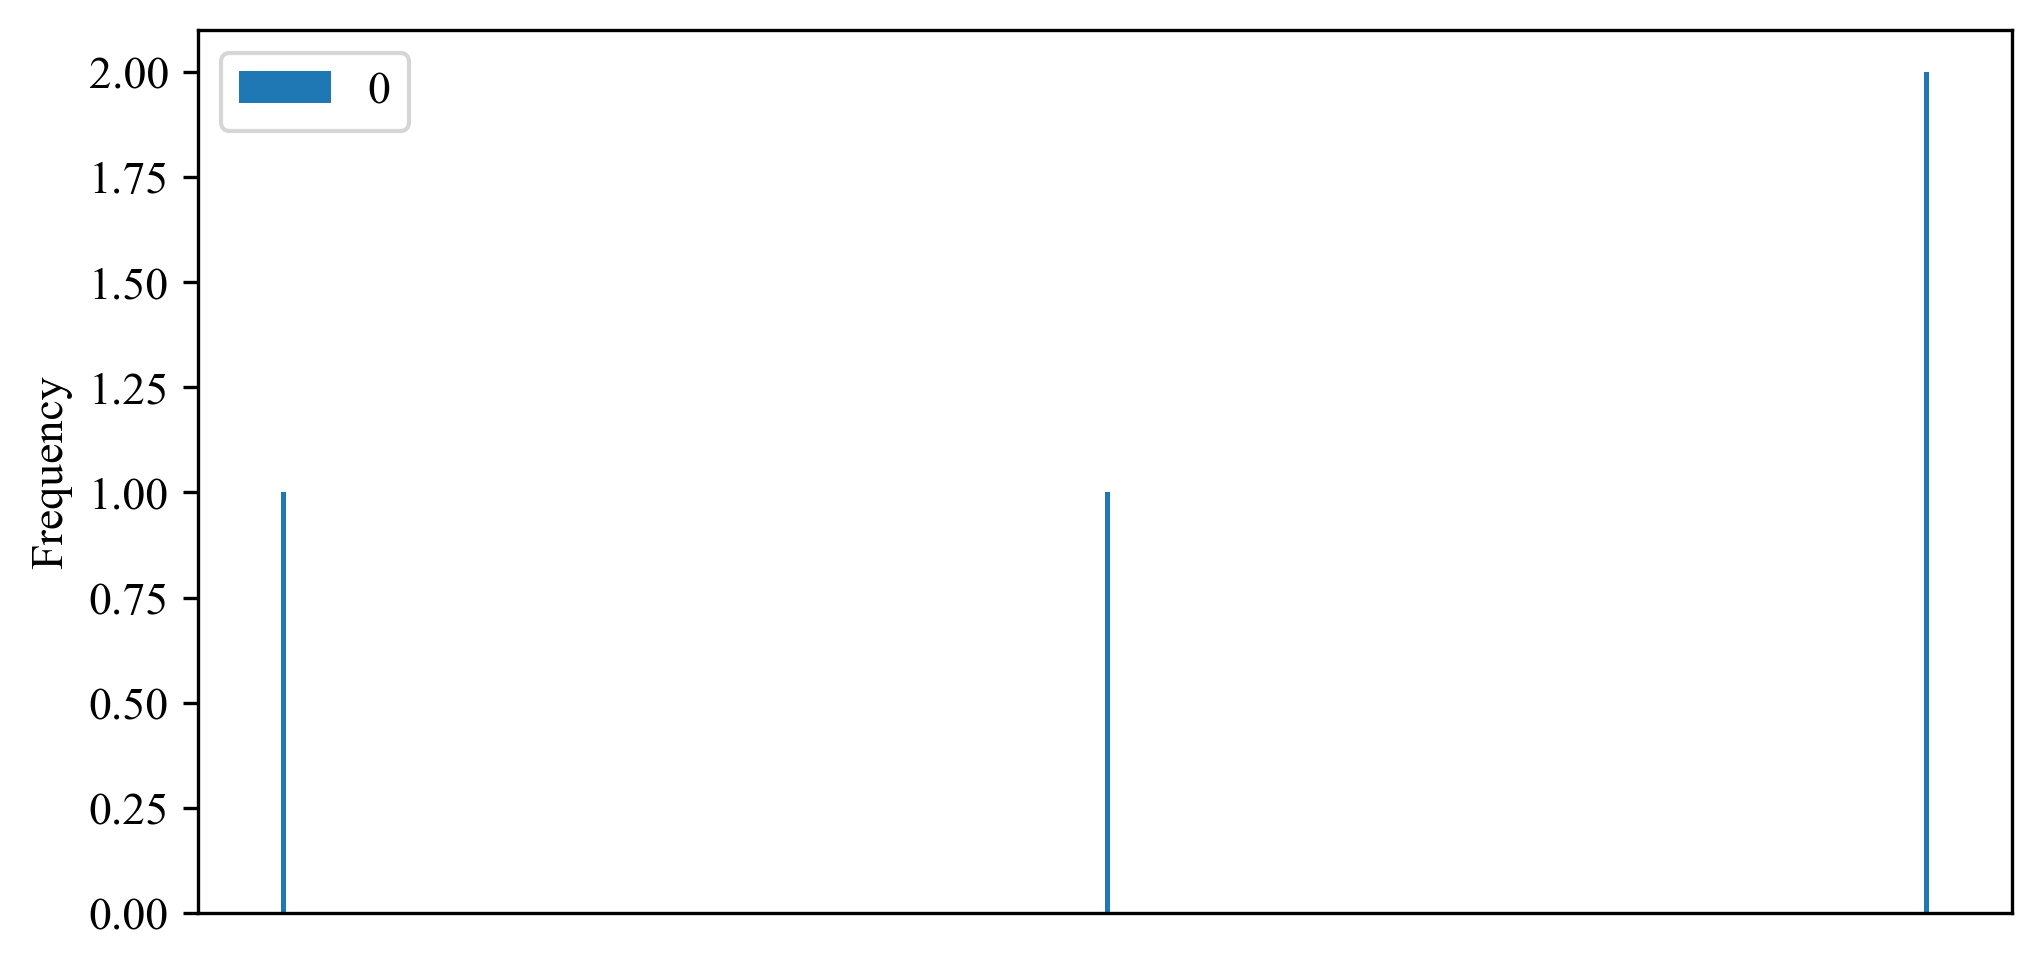

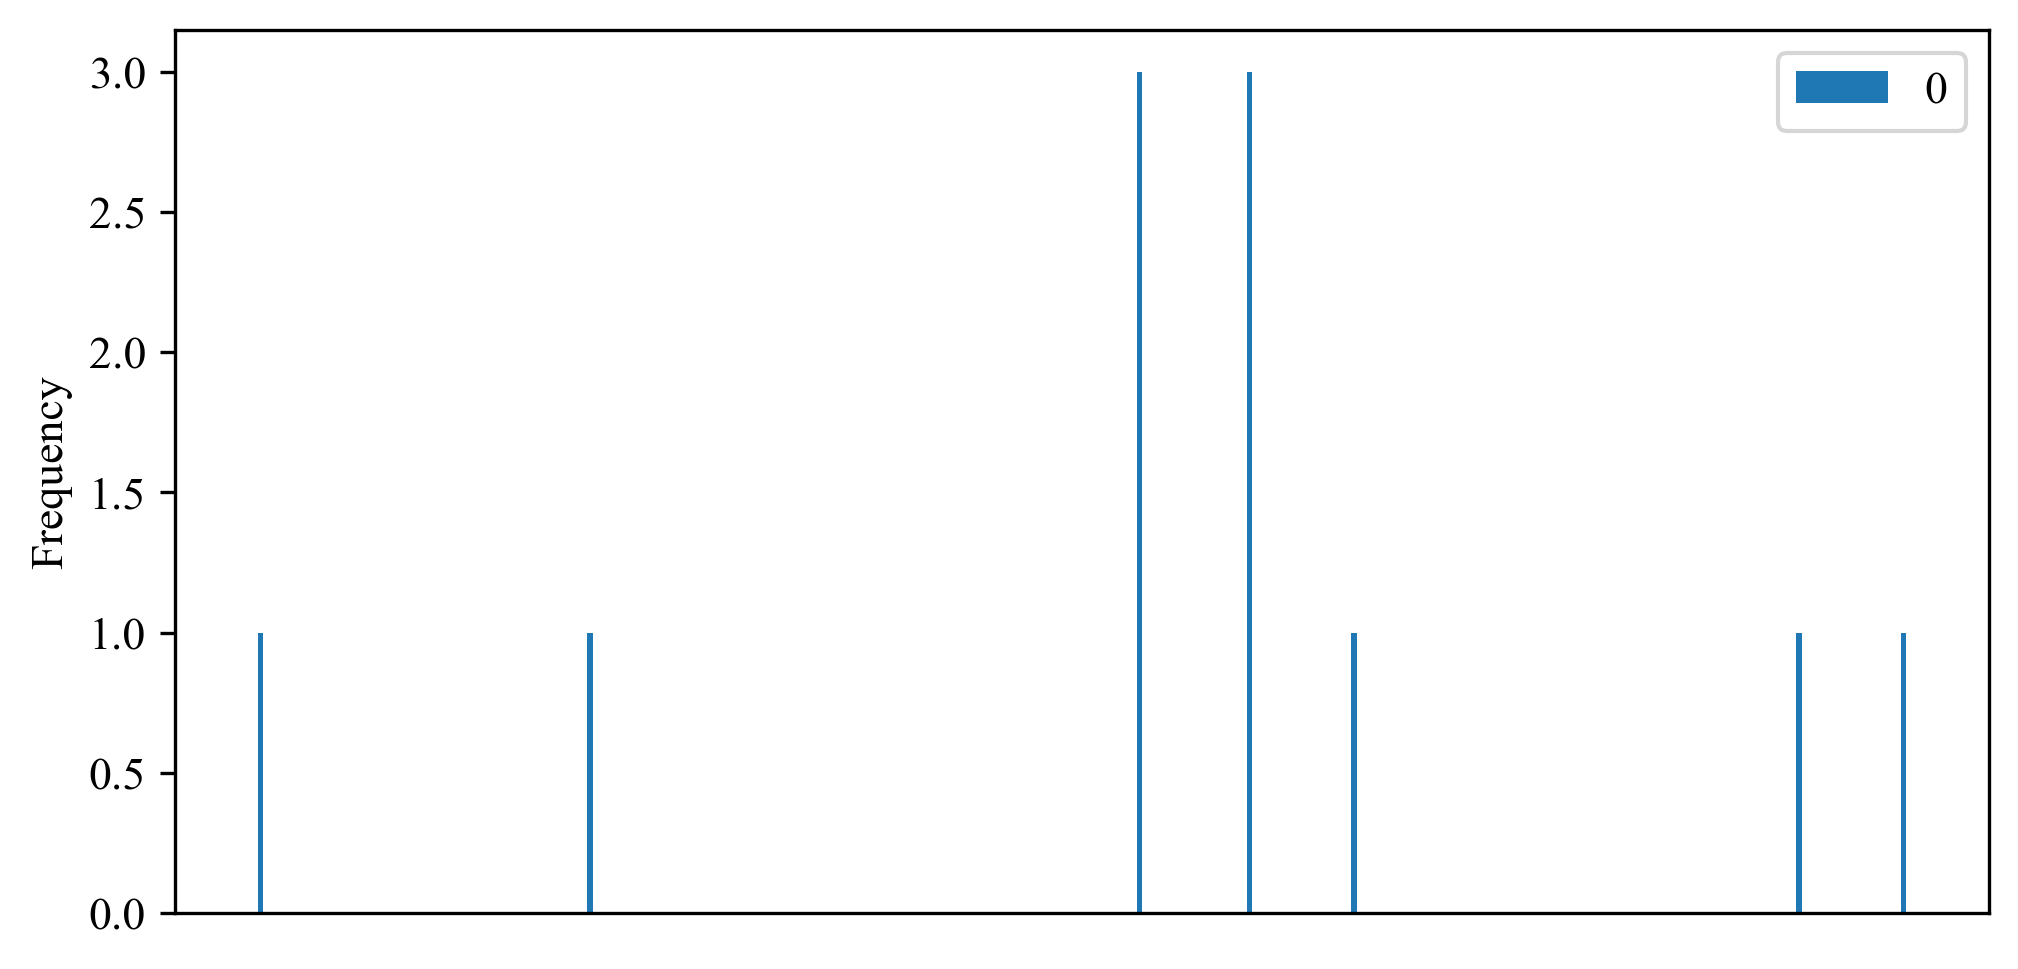

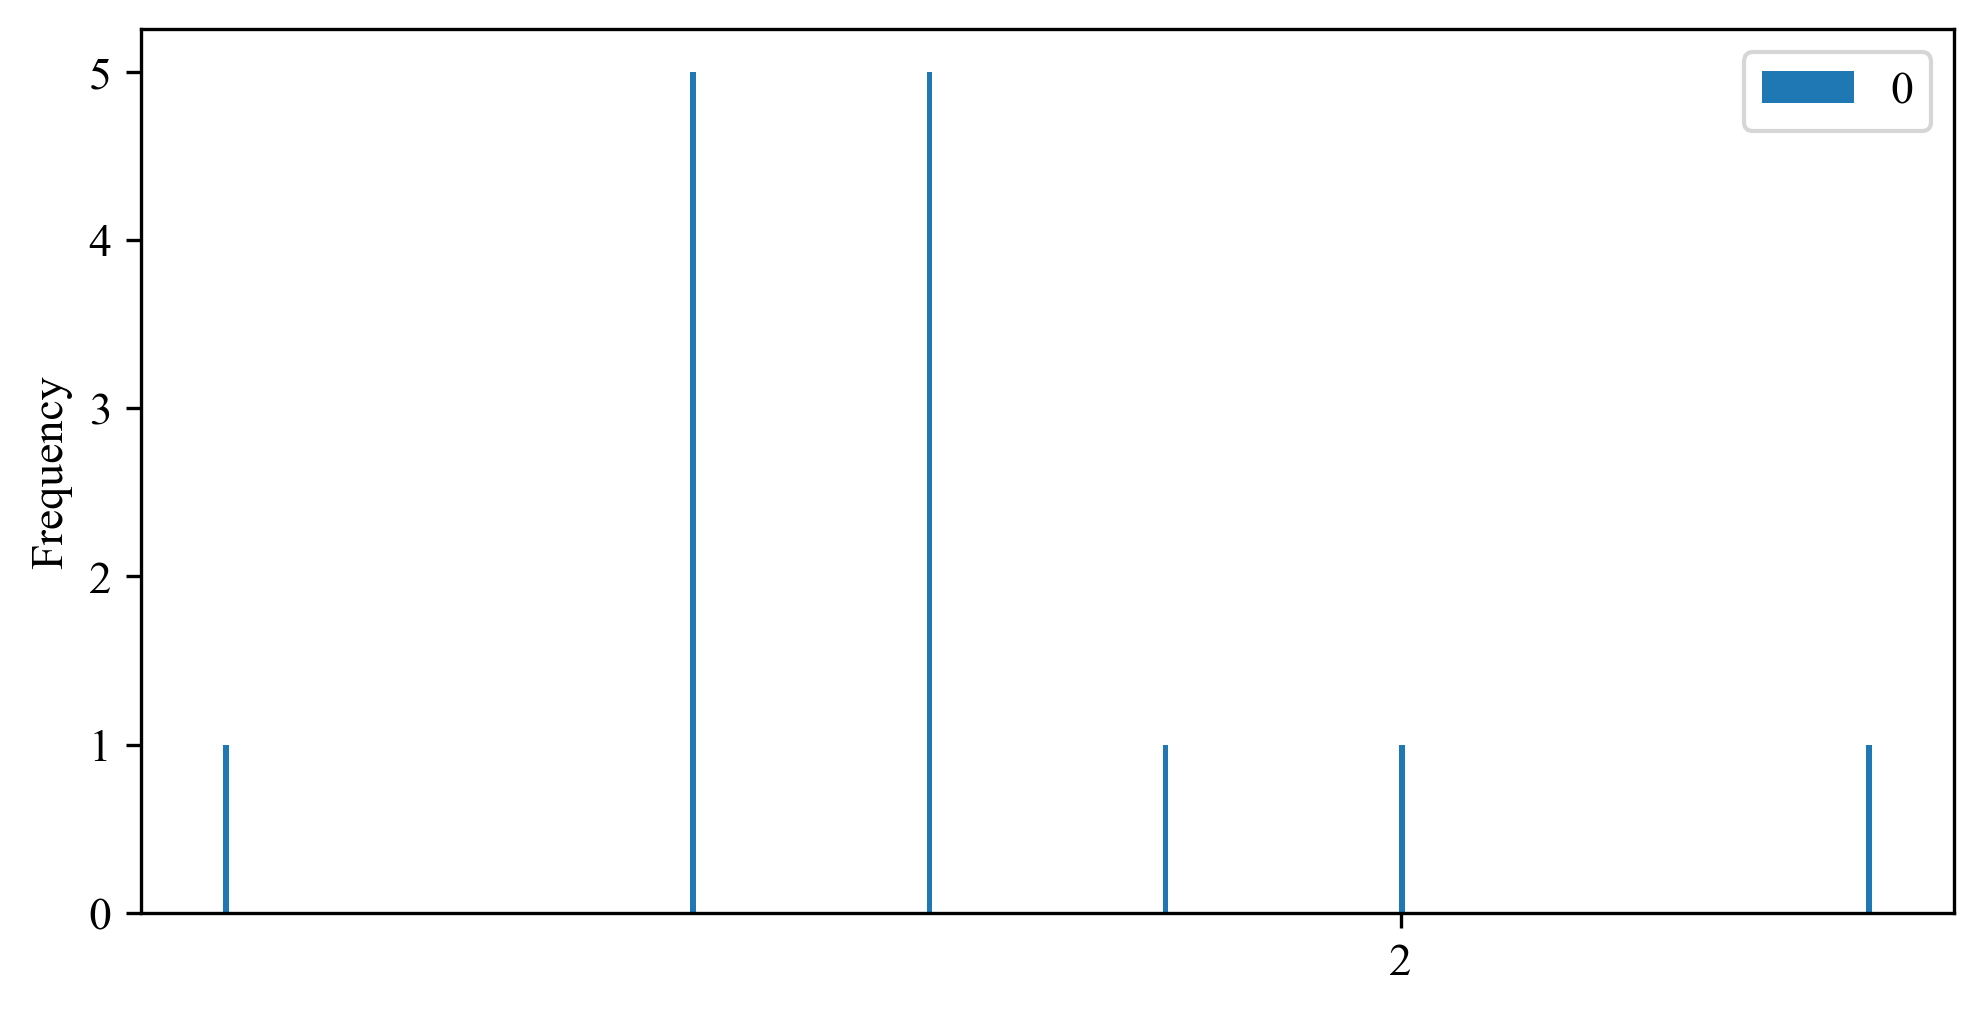

In [21]:

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
timedeltas = []
for stst in StartStop_p1:
    timedeltas.append((stst[1] - stst[0]))
print("Average length of SubSegments Phase 1: " + str(sum(timedeltas, timedelta(0)) / len(timedeltas)))
td_dt = pd.DataFrame(timedeltas)
ax = (td_dt.astype('timedelta64[s]') / 3600).plot.hist(bins=300)
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))


timedeltas = []
for stst in StartStop_p2:
    timedeltas.append((stst[1] - stst[0]))
print("Average length of SubSegments Phase 2: " + str(sum(timedeltas, timedelta(0)) / len(timedeltas)))
td_dt = pd.DataFrame(timedeltas)
ax = (td_dt.astype('timedelta64[s]') / 3600).plot.hist(bins=300)
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

timedeltas = []
for stst in StartStop_p3:
    timedeltas.append((stst[1] - stst[0]))
print("Average length of SubSegments Phase 3: " + str(sum(timedeltas, timedelta(0)) / len(timedeltas)))
td_dt = pd.DataFrame(timedeltas)
ax = (td_dt.astype('timedelta64[s]') / 3600).plot.hist(bins=300)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

### Plot the Delimiters

(736469.0, 736476.0)

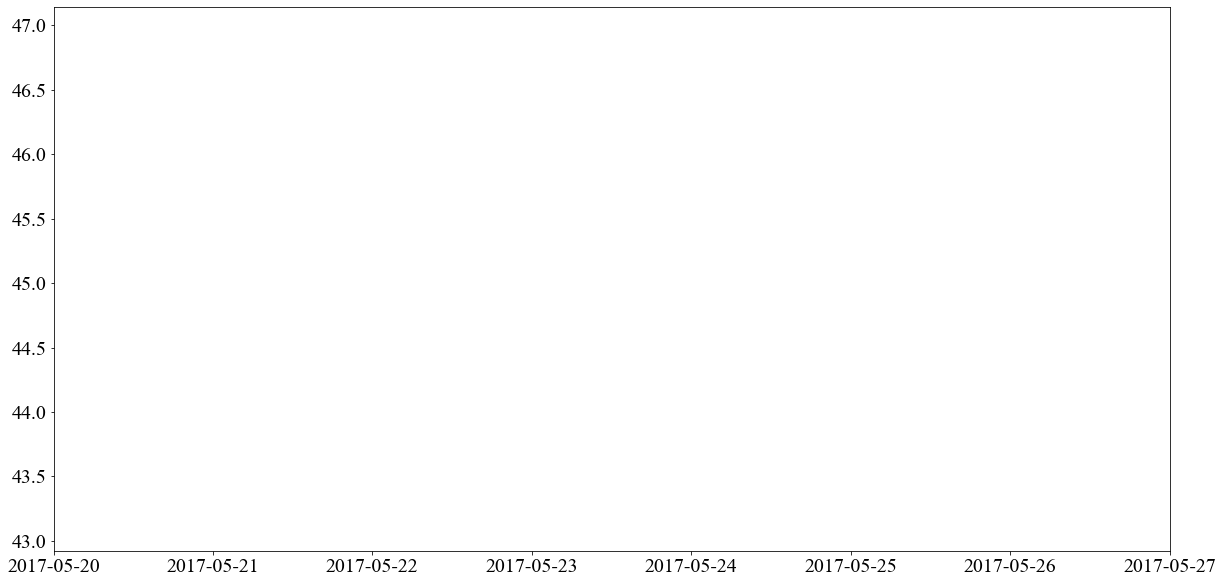

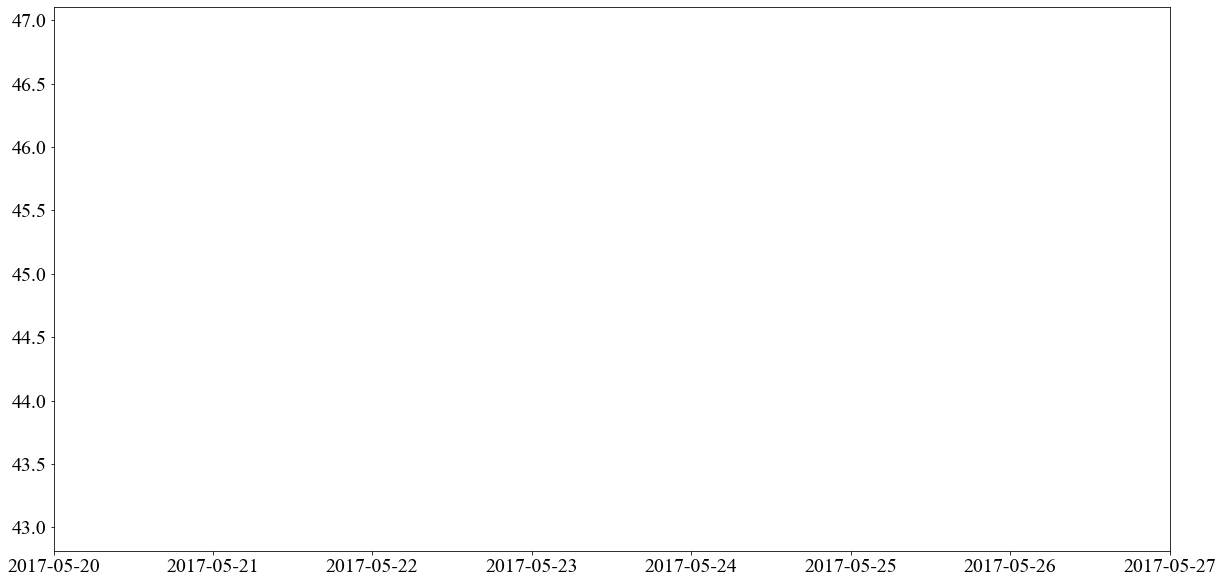

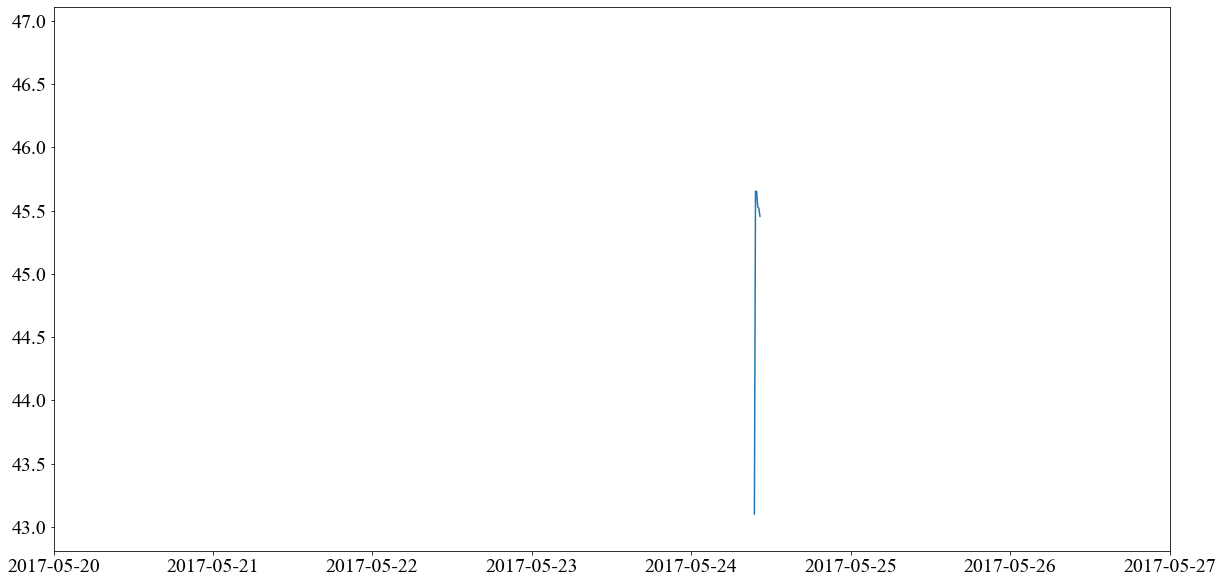

In [25]:
start_y = 2017
start_m = 5
start_d = 20

end_y = 2017
end_m = 5
end_d = 27

fig, ax = plt.subplots()
ax.plot(rmsi_4347_p1)
ax.vlines(StartStop_p1, rmsi_4347_p1.min() ,rmsi_4347_p1.max())
ax.set_xlim([datetime(start_y, start_m, start_d), datetime(end_y, end_m, end_d)])

fig, ax = plt.subplots()
ax.plot(rmsi_4347_p2)
ax.vlines(StartStop_p2, rmsi_4347_p2.min() ,rmsi_4347_p2.max())
ax.set_xlim([datetime(start_y, start_m, start_d), datetime(end_y, end_m, end_d)])

fig, ax = plt.subplots()
ax.plot(rmsi_4347_p3)
ax.vlines(StartStop_p3, rmsi_4347_p3.min() ,rmsi_4347_p3.max())
ax.set_xlim([datetime(start_y, start_m, start_d), datetime(end_y, end_m, end_d)])

### Get the Subsegments

In [22]:
TimeSeries_p1 = []
for stst in StartStop_p1:
    TimeSeries_p1.append((rmsi_all_p1[stst[0]:stst[1]]))
    
TimeSeries_p2 = []
for stst in StartStop_p2:
    TimeSeries_p2.append((rmsi_all_p2[stst[0]:stst[1]]))
    
TimeSeries_p3 = []
for stst in StartStop_p3:
    TimeSeries_p3.append((rmsi_all_p3[stst[0]:stst[1]]))

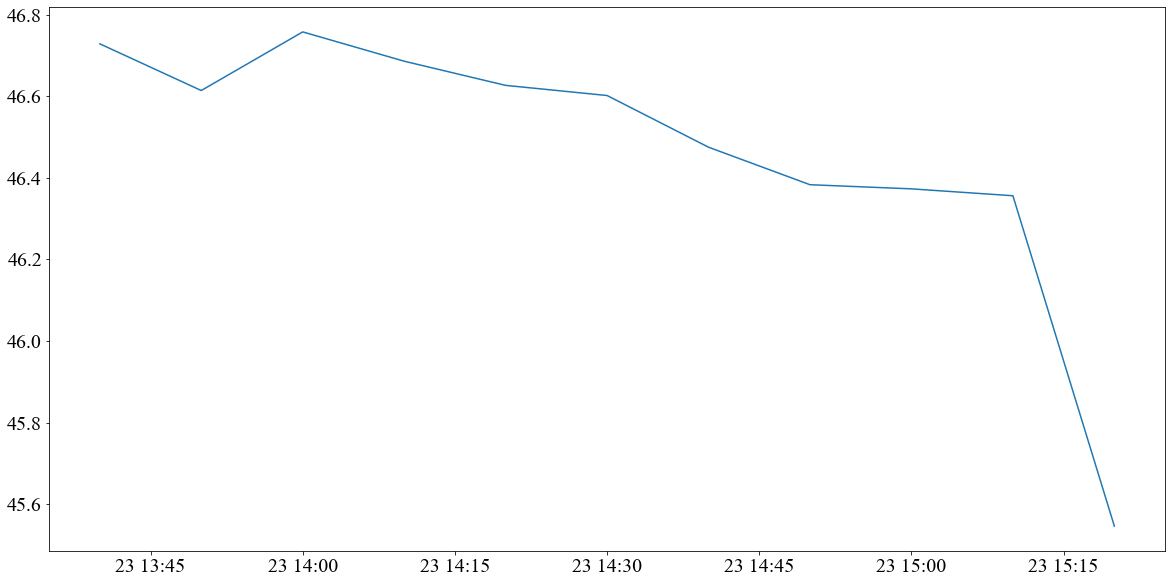

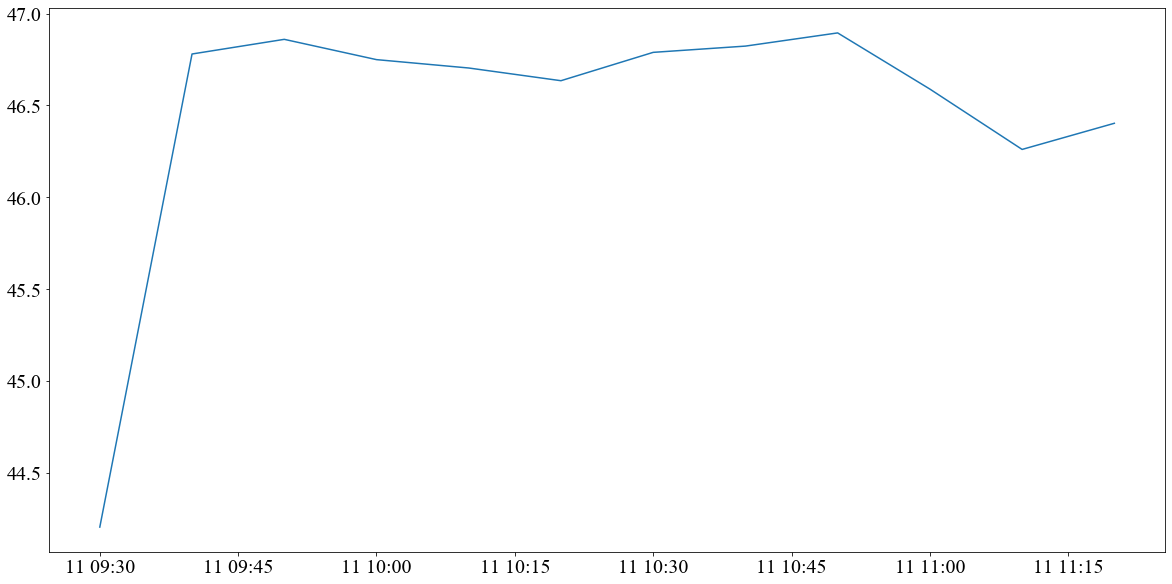

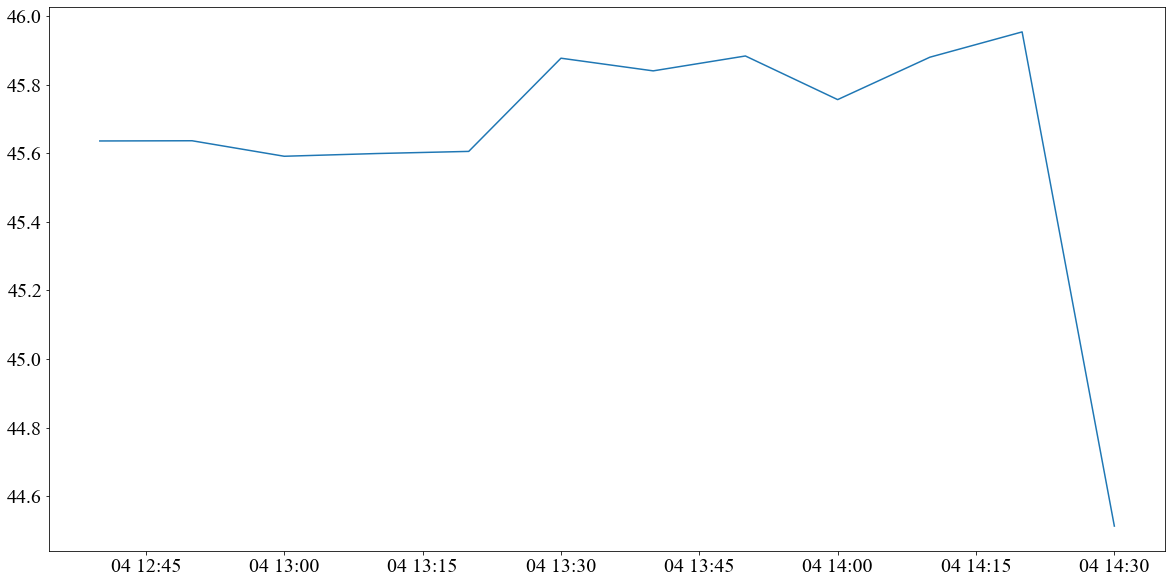

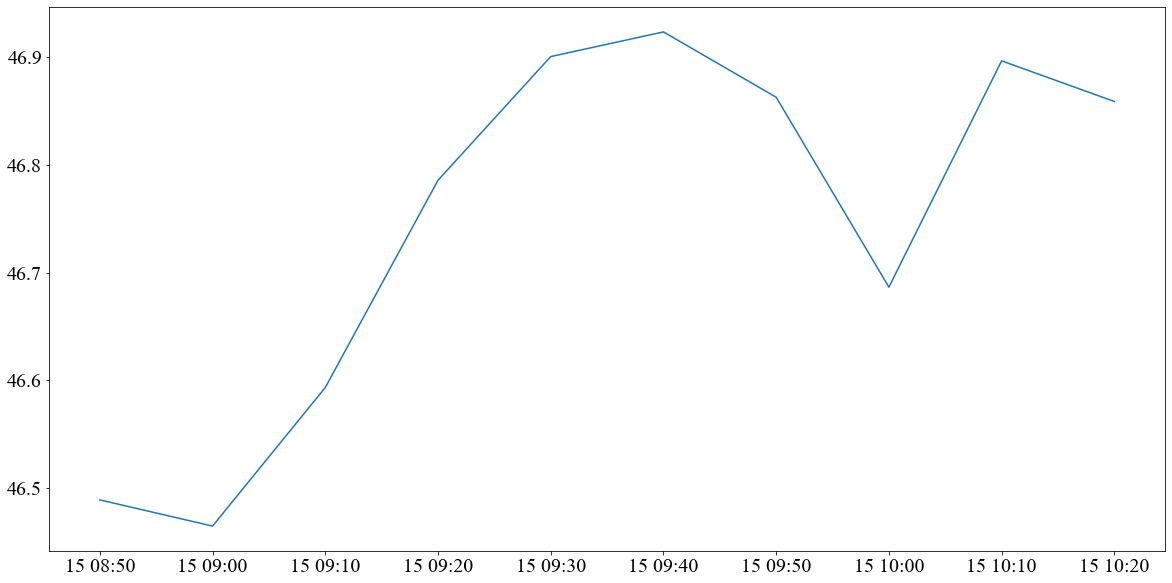

In [27]:
for ts in TimeSeries_p1:
    plt.plot(ts)
    plt.show()

### SubSegment Variance

In [23]:
var_p1 = 0
for ts in TimeSeries_p1:
    var_p1 += np.var(ts.values)
var_p1 = var_p1 / len(TimeSeries_p1)
print("Average Variance of SubSegments in Phase 1: " + str(var_p1))

var_p2 = 0
for ts in TimeSeries_p2:
    var_p2 += np.var(ts.values)
var_p2 = var_p2 / len(TimeSeries_p2)
print("Average Variance of SubSegments in Phase 2: " + str(var_p2))

var_p3 = 0
for ts in TimeSeries_p3:
    var_p3 += np.var(ts.values)
var_p3 = var_p3 / len(TimeSeries_p3)
print("Average Variance of SubSegments in Phase 3: " + str(var_p3))

Average Variance of SubSegments in Phase 1: 0.19157794676721096
Average Variance of SubSegments in Phase 2: 0.2204013696914031
Average Variance of SubSegments in Phase 3: 0.2205472818043615


### Get the footprint of each Phase

### Phase 1:

In [24]:
shi_4347_p1 = shi_all_p1.loc[mask_p1[0]]

In [25]:
sh_i_mean_p1 = np.mean(shi_4347_p1, axis=0)
sh_i_perc75_p1 = np.nanpercentile(shi_4347_p1, 75, axis=0)
sh_i_perc25_p1 = np.nanpercentile(shi_4347_p1, 25, axis=0)

sh_i_mean_db_p1 = levels_dbmyA(pd.DataFrame(sh_i_mean_p1))
sh_i_perc75_db_p1 = levels_dbmyA(pd.DataFrame(sh_i_perc75_p1))
sh_i_perc25_db_p1 = levels_dbmyA(pd.DataFrame(sh_i_perc25_p1))


In [66]:
x = generateXAxisData()/1000
d = {'p1Bucket4': sh_i_mean_db_p1[0]}
df = pd.DataFrame(data=d)
df.index = x
df.to_excel("MeanPhase1_Bucket4.xlsx")

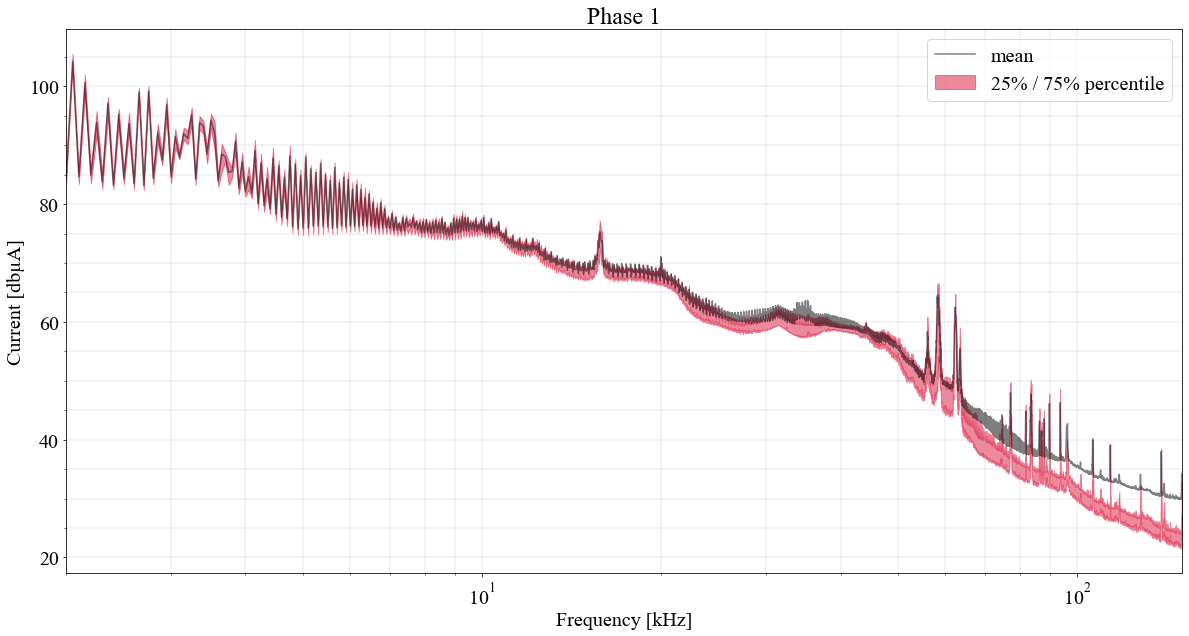

In [31]:
x = generateXAxisData()/1000

fig, ax = plt.subplots()

ax.plot(x, sh_i_mean_db_p1, color="k", label="mean", alpha=0.5)
ax.fill_between(x, sh_i_perc25_db_p1.values.flatten(), sh_i_perc75_db_p1.values.flatten(), color='crimson', alpha=0.5, label="25% / 75% percentile")
ax.set_xlim(min(x), max(x))
ax.minorticks_on()
ax.grid(linewidth=0.3, which='both')
ax.set_xlabel("Frequency [kHz]")
ax.set_ylabel('Current [dbµA]')
ax.set_xscale('log')
ax.set_title('Phase 1')
ax.legend()

### Phase 2:

In [26]:
shi_4347_p2 = shi_all_p2.loc[mask_p2[0]]

In [27]:
sh_i_mean_p2 = np.mean(shi_4347_p2, axis=0)
sh_i_perc75_p2 = np.nanpercentile(shi_4347_p2, 75, axis=0)
sh_i_perc25_p2 = np.nanpercentile(shi_4347_p2, 25, axis=0)

sh_i_mean_db_p2 = levels_dbmyA(pd.DataFrame(sh_i_mean_p2))
sh_i_perc75_db_p2 = levels_dbmyA(pd.DataFrame(sh_i_perc75_p2))
sh_i_perc25_db_p2 = levels_dbmyA(pd.DataFrame(sh_i_perc25_p2))

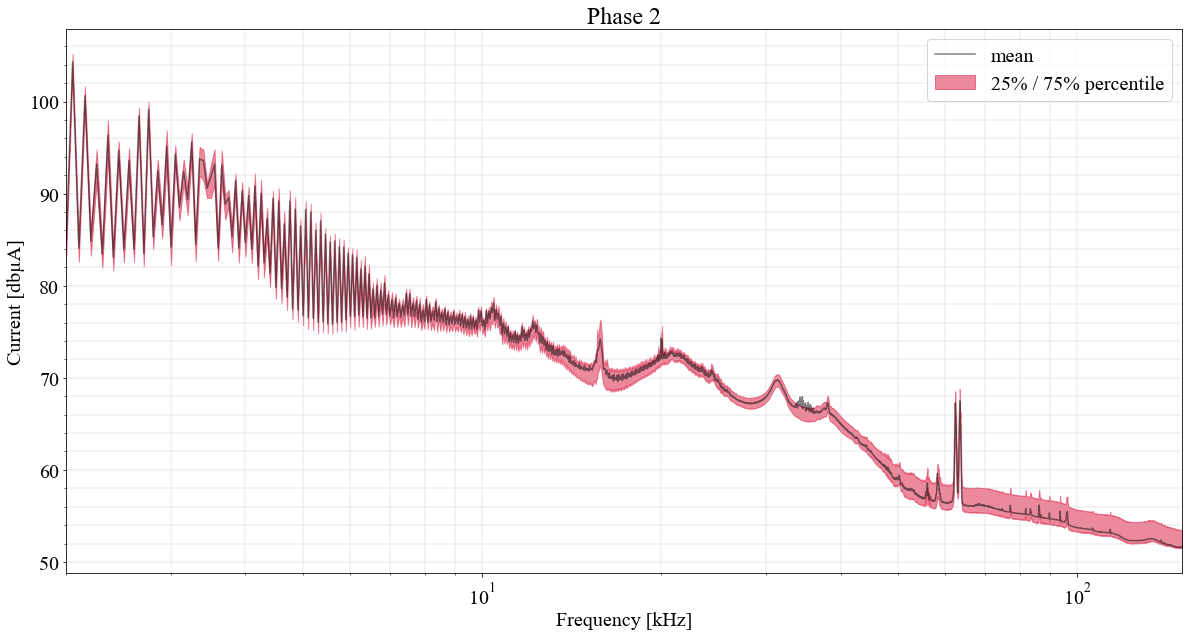

In [34]:
x = generateXAxisData()/1000

fig, ax = plt.subplots()

ax.plot(x, sh_i_mean_db_p2, color="k", label="mean", alpha=0.5)
ax.fill_between(x, sh_i_perc25_db_p2.values.flatten(), sh_i_perc75_db_p2.values.flatten(), color='crimson', alpha=0.5, label="25% / 75% percentile")
ax.set_xlim(min(x), max(x))
ax.minorticks_on()
ax.grid(linewidth=0.3, which='both')
ax.set_xlabel("Frequency [kHz]")
ax.set_ylabel('Current [dbµA]')
ax.set_xscale('log')
ax.set_title('Phase 2')
ax.legend()

### Phase 3:

In [28]:
shi_4347_p3 = shi_all_p3.loc[mask_p3[0]]

In [29]:
sh_i_mean_p3 = np.mean(shi_4347_p3, axis=0)
sh_i_perc75_p3 = np.nanpercentile(shi_4347_p3, 75, axis=0)
sh_i_perc25_p3 = np.nanpercentile(shi_4347_p3, 25, axis=0)

sh_i_mean_db_p3 = levels_dbmyA(pd.DataFrame(sh_i_mean_p3))
sh_i_perc75_db_p3 = levels_dbmyA(pd.DataFrame(sh_i_perc75_p3))
sh_i_perc25_db_p3 = levels_dbmyA(pd.DataFrame(sh_i_perc25_p3))

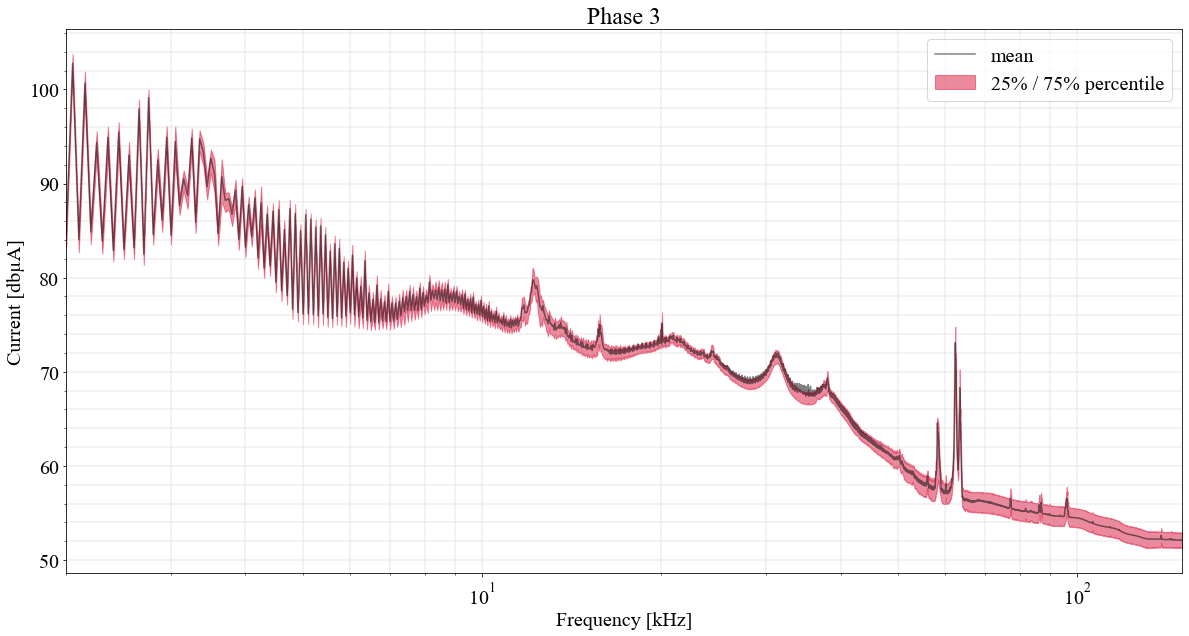

In [37]:
x = generateXAxisData()/1000

fig, ax = plt.subplots()

ax.plot(x, sh_i_mean_db_p3, color="k", label="mean", alpha=0.5)
ax.fill_between(x, sh_i_perc25_db_p3.values.flatten(), sh_i_perc75_db_p3.values.flatten(), color='crimson', alpha=0.5, label="25% / 75% percentile")
ax.set_xlim(min(x), max(x))
ax.minorticks_on()
ax.grid(linewidth=0.3, which='both')
ax.set_xlabel("Frequency [kHz]")
ax.set_ylabel('Current [dbµA]')
ax.set_xscale('log')
ax.set_title('Phase 3')
ax.legend()

# Cluster Phase 1

In [30]:
from tslearn.utils import to_time_series_dataset
X = to_time_series_dataset(TimeSeries_p1)

C:\Users\Philipp\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


DBA k-means


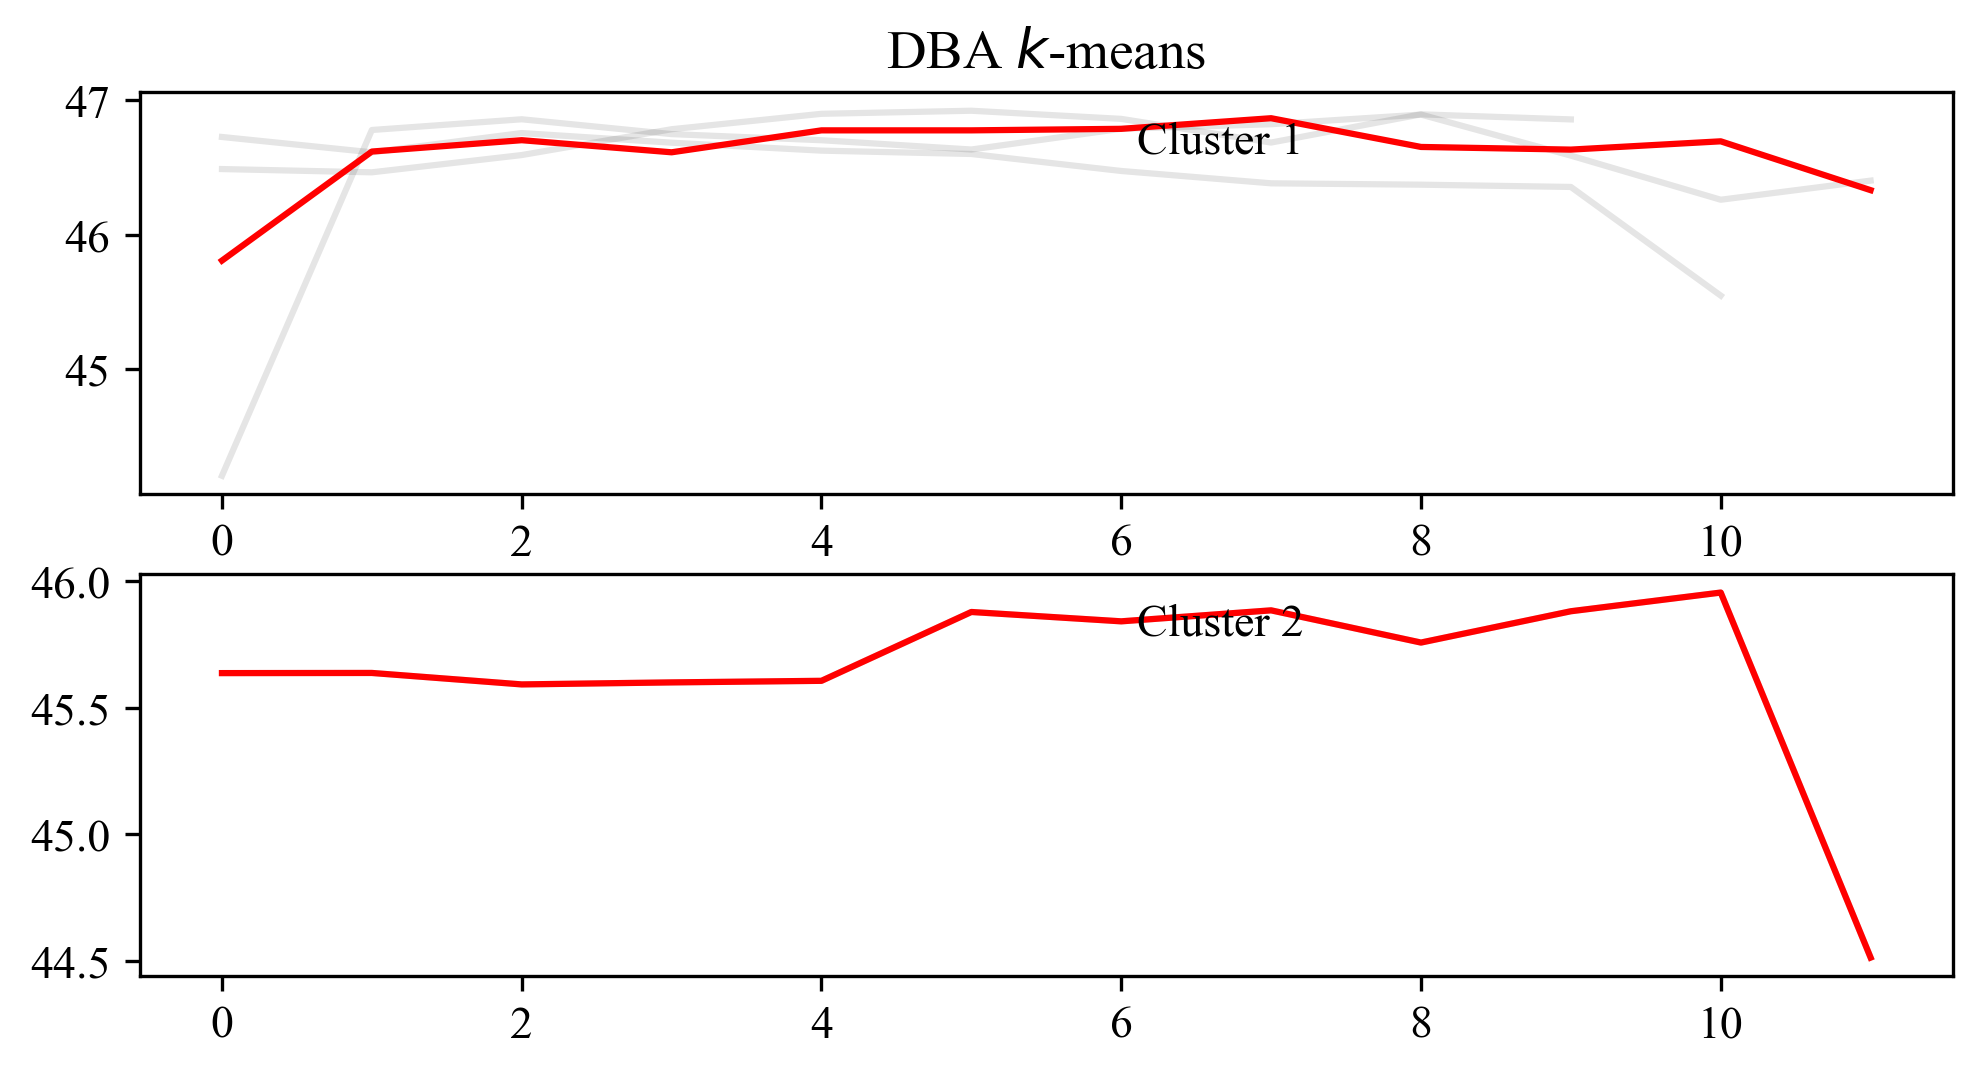

In [31]:
number_cluster = 2
from tslearn.clustering import TimeSeriesKMeans
# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=number_cluster,
                          n_init=2,
                          metric="dtw",
                          verbose=False,
                          max_iter_barycenter=100,
                          random_state=0)
y_pred = dba_km.fit_predict(X)

for yi in range(number_cluster):
    plt.subplot(number_cluster, 1, yi+1)
    for xx in X[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.1)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    #plt.xlim(0, sz)
    #plt.ylim(-4, 4)
    #plt.xscale('log')
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 0:
        plt.title("DBA $k$-means")

(array([3., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

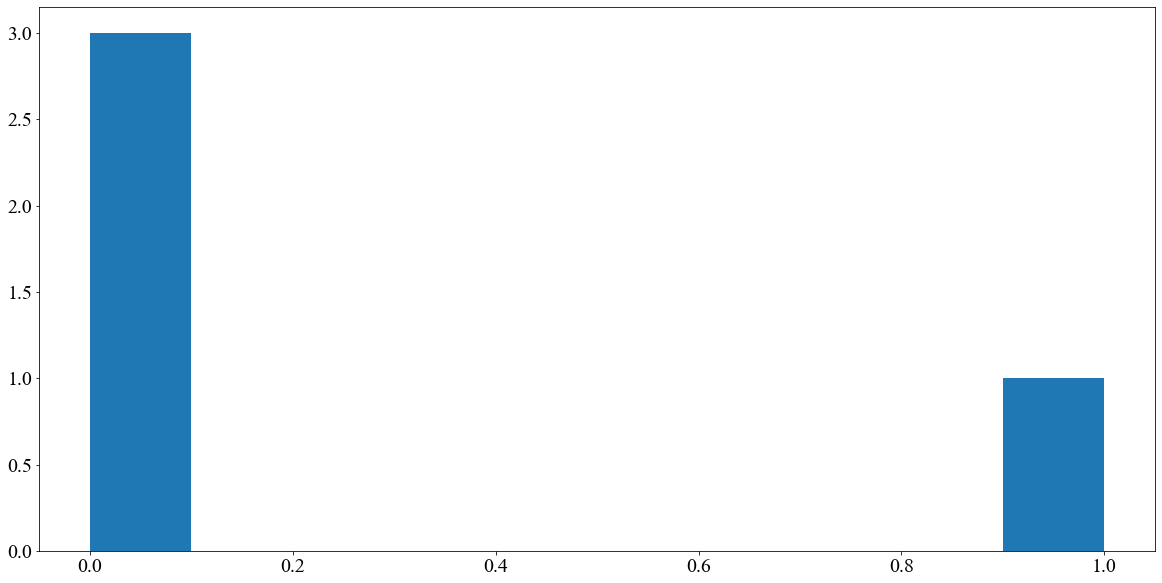

In [40]:
plt.hist(y_pred)

## Inside Phase 1
### Cluster 2

In [32]:
ts_cl_2_p1 = [TimeSeries_p1[i] for i in np.where(y_pred == 2)[0]] 

In [33]:
cl_2_shi_p1 = pd.DataFrame()
for ts in ts_cl_2_p1:
    cl_2_shi_p1 = cl_2_shi_p1.append(shi_all_p1.loc[ts.index])

In [34]:
cl_2_sh_i_mean_p1 = np.mean(cl_2_shi_p1, axis=0)
cl_2_sh_i_perc75_p1 = np.nanpercentile(cl_2_shi_p1, 75, axis=0)
cl_2_sh_i_perc25_p1 = np.nanpercentile(cl_2_shi_p1, 25, axis=0)

cl_2_sh_i_mean_db_p1 = levels_dbmyA(pd.DataFrame(cl_2_sh_i_mean_p1))
cl_2_sh_i_perc75_db_p1 = levels_dbmyA(pd.DataFrame(cl_2_sh_i_perc75_p1))
cl_2_sh_i_perc25_db_p1 = levels_dbmyA(pd.DataFrame(cl_2_sh_i_perc25_p1))

### Cluster 1

In [35]:
ts_cl_1_p1 = [TimeSeries_p1[i] for i in np.where(y_pred == 1)[0]] 

In [36]:
cl_1_shi_p1 = pd.DataFrame()
for ts in ts_cl_1_p1:
    cl_1_shi_p1 = cl_1_shi_p1.append(shi_all_p1.loc[ts.index])

In [37]:
cl_1_sh_i_mean_p1 = np.mean(cl_1_shi_p1, axis=0)
cl_1_sh_i_perc75_p1 = np.nanpercentile(cl_1_shi_p1, 75, axis=0)
cl_1_sh_i_perc25_p1 = np.nanpercentile(cl_1_shi_p1, 25, axis=0)

cl_1_sh_i_mean_db_p1 = levels_dbmyA(pd.DataFrame(cl_1_sh_i_mean_p1))
cl_1_sh_i_perc75_db_p1 = levels_dbmyA(pd.DataFrame(cl_1_sh_i_perc75_p1))
cl_1_sh_i_perc25_db_p1 = levels_dbmyA(pd.DataFrame(cl_1_sh_i_perc25_p1))

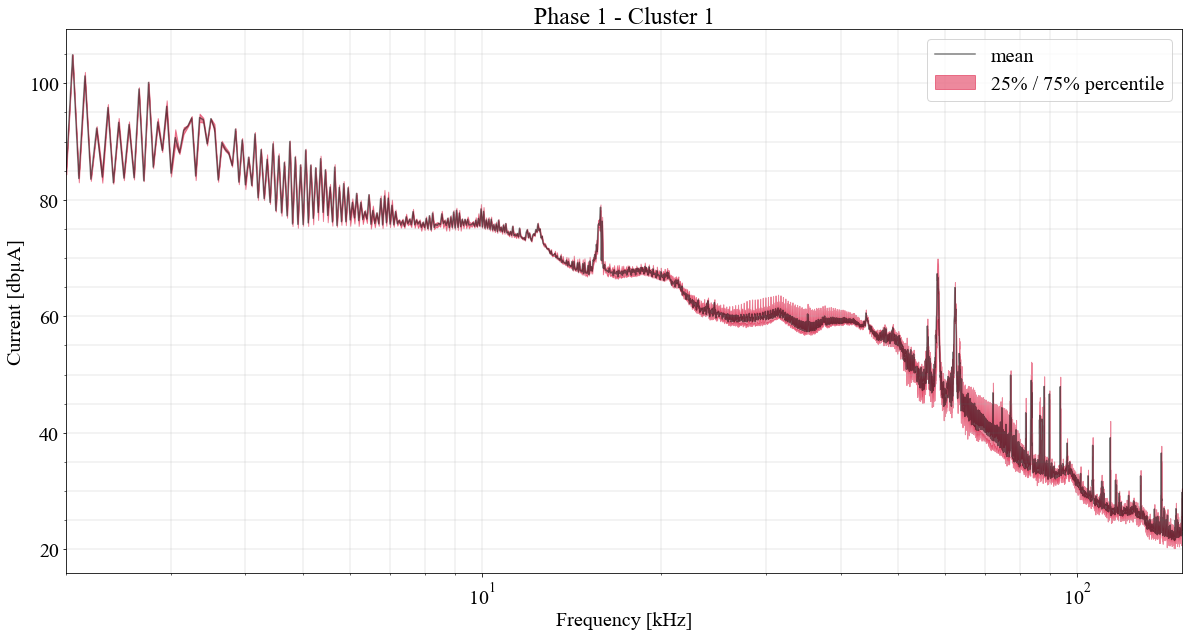

In [47]:
x = generateXAxisData()/1000

fig, ax = plt.subplots()

ax.plot(x, cl_1_sh_i_mean_db_p1, color="k", label="mean", alpha=0.5)
ax.fill_between(x, cl_1_sh_i_perc25_db_p1.values.flatten(), cl_1_sh_i_perc75_db_p1.values.flatten(), color='crimson', alpha=0.5, label="25% / 75% percentile")
ax.set_xlim(min(x), max(x))
ax.minorticks_on()
ax.grid(linewidth=0.3, which='both')
ax.set_xlabel("Frequency [kHz]")
ax.set_ylabel('Current [dbµA]')
ax.set_xscale('log')
ax.set_title('Phase 1 - Cluster 1')
ax.legend()

### Cluster 0

In [38]:
ts_cl_0_p1 = [TimeSeries_p1[i] for i in np.where(y_pred == 0)[0]] 

In [39]:
cl_0_shi_p1 = pd.DataFrame()
for ts in ts_cl_1_p1:
    cl_0_shi_p1 = cl_0_shi_p1.append(shi_all_p1.loc[ts.index])

In [40]:
cl_0_sh_i_mean_p1 = np.mean(cl_0_shi_p1, axis=0)
cl_0_sh_i_perc75_p1 = np.nanpercentile(cl_0_shi_p1, 75, axis=0)
cl_0_sh_i_perc25_p1 = np.nanpercentile(cl_0_shi_p1, 25, axis=0)

cl_0_sh_i_mean_db_p1 = levels_dbmyA(pd.DataFrame(cl_0_sh_i_mean_p1))
cl_0_sh_i_perc75_db_p1 = levels_dbmyA(pd.DataFrame(cl_0_sh_i_perc75_p1))
cl_0_sh_i_perc25_db_p1 = levels_dbmyA(pd.DataFrame(cl_0_sh_i_perc25_p1))

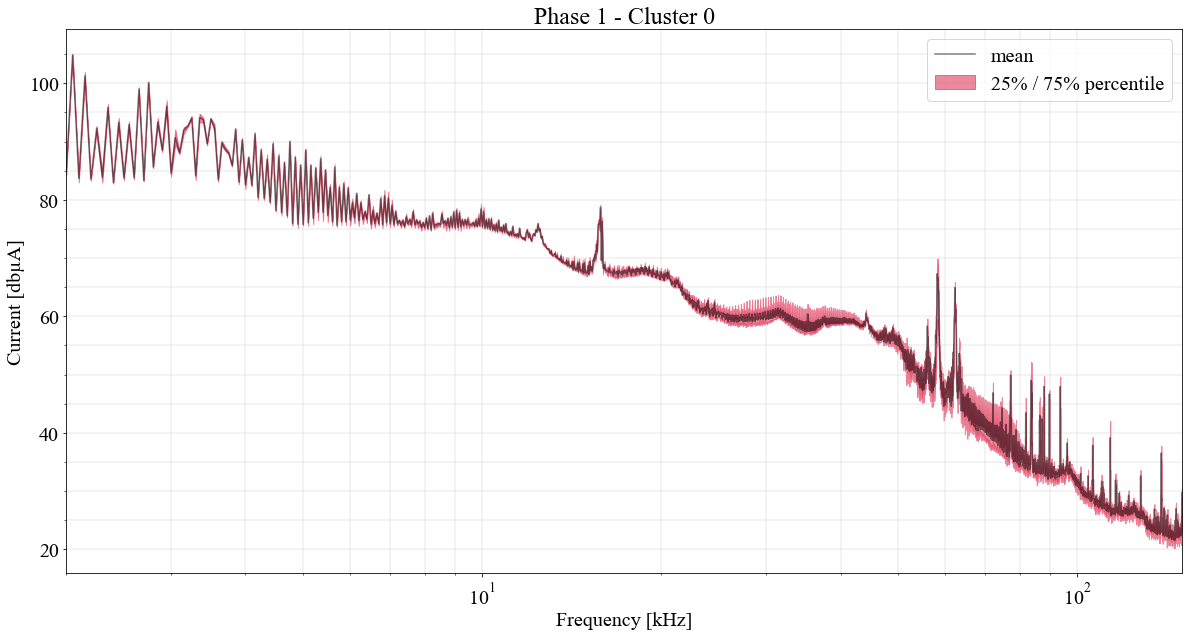

In [51]:
x = generateXAxisData()/1000

fig, ax = plt.subplots()

ax.plot(x, cl_0_sh_i_mean_db_p1, color="k", label="mean", alpha=0.5)
ax.fill_between(x, cl_0_sh_i_perc25_db_p1.values.flatten(), cl_0_sh_i_perc75_db_p1.values.flatten(), color='crimson', alpha=0.5, label="25% / 75% percentile")
ax.set_xlim(min(x), max(x))
ax.minorticks_on()
ax.grid(linewidth=0.3, which='both')
ax.set_xlabel("Frequency [kHz]")
ax.set_ylabel('Current [dbµA]')
ax.set_xscale('log')
ax.set_title('Phase 1 - Cluster 0')
ax.legend()

### OVERVIEW ALL 3 FOOTPRINTS

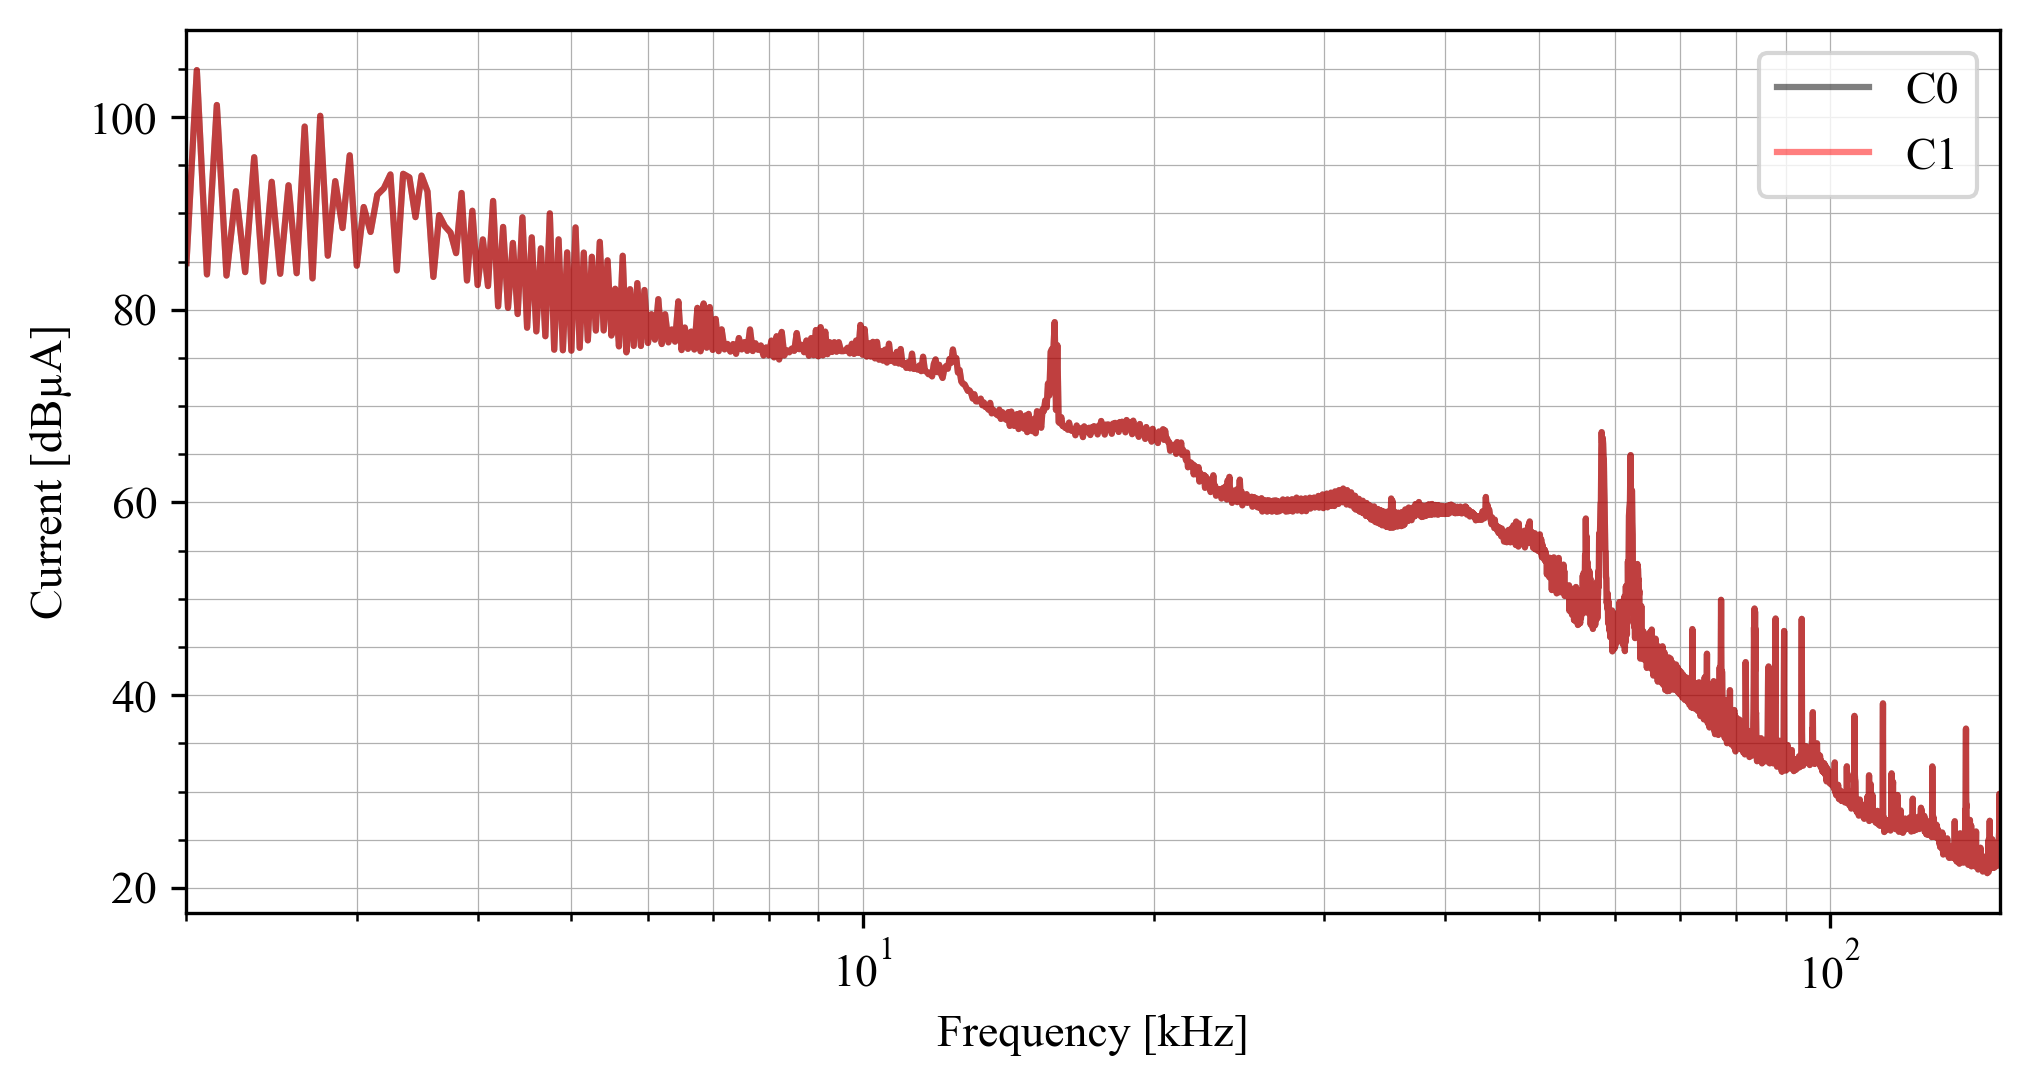

In [65]:
x = generateXAxisData()/1000

fig, ax = plt.subplots()

ax.plot(x, cl_0_sh_i_mean_db_p1, color="k", label="C0", alpha=0.5)
ax.plot(x, cl_1_sh_i_mean_db_p1, color="r", label="C1", alpha=.5)

ax.set_xlim(min(x), max(x))
ax.minorticks_on()
ax.grid(linewidth=0.3, which='both')
ax.set_xlabel("Frequency [kHz]")
ax.set_ylabel('Current [dBµA]')
ax.set_xscale('log')
ax.legend()

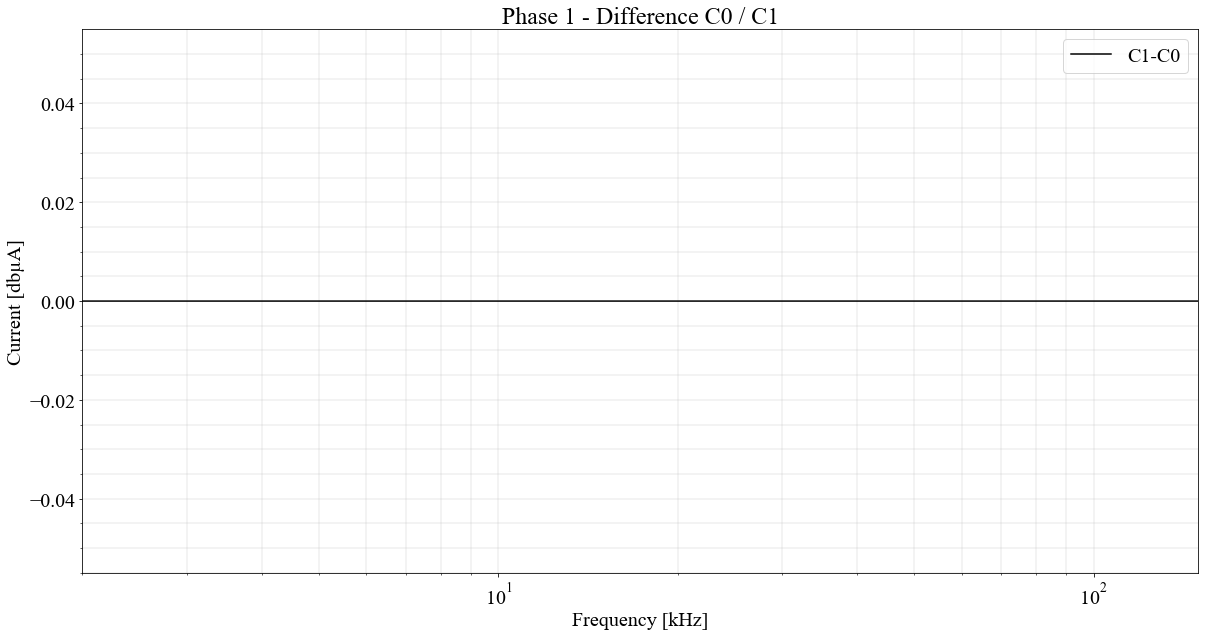

In [53]:
x = generateXAxisData()/1000

fig, ax = plt.subplots()

ax.plot(x, (cl_0_sh_i_mean_db_p1-cl_1_sh_i_mean_db_p1), color="k", label="C1-C0", alpha=1)

ax.set_xlim(min(x), max(x))
ax.minorticks_on()
ax.grid(linewidth=0.3, which='both')
ax.set_xlabel("Frequency [kHz]")
ax.set_ylabel('Current [dbµA]')
ax.set_xscale('log')
ax.set_title('Phase 1 - Difference C0 / C1')
ax.legend()

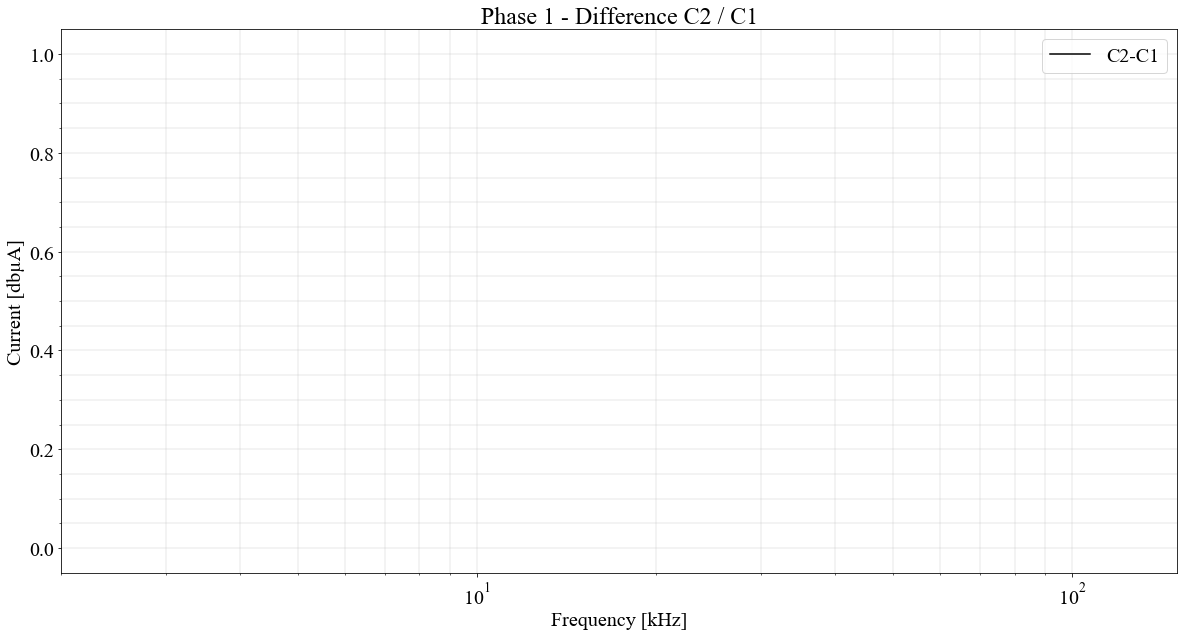

In [54]:
x = generateXAxisData()/1000

fig, ax = plt.subplots()

ax.plot(x, (cl_2_sh_i_mean_db_p1-cl_1_sh_i_mean_db_p1), color="k", label="C2-C1", alpha=1)

ax.set_xlim(min(x), max(x))
ax.minorticks_on()
ax.grid(linewidth=0.3, which='both')
ax.set_xlabel("Frequency [kHz]")
ax.set_ylabel('Current [dbµA]')
ax.set_xscale('log')
ax.set_title('Phase 1 - Difference C2 / C1')
ax.legend()

# Cluster Phase 2

In [41]:
from tslearn.utils import to_time_series_dataset
X = to_time_series_dataset(TimeSeries_p2)

DBA k-means


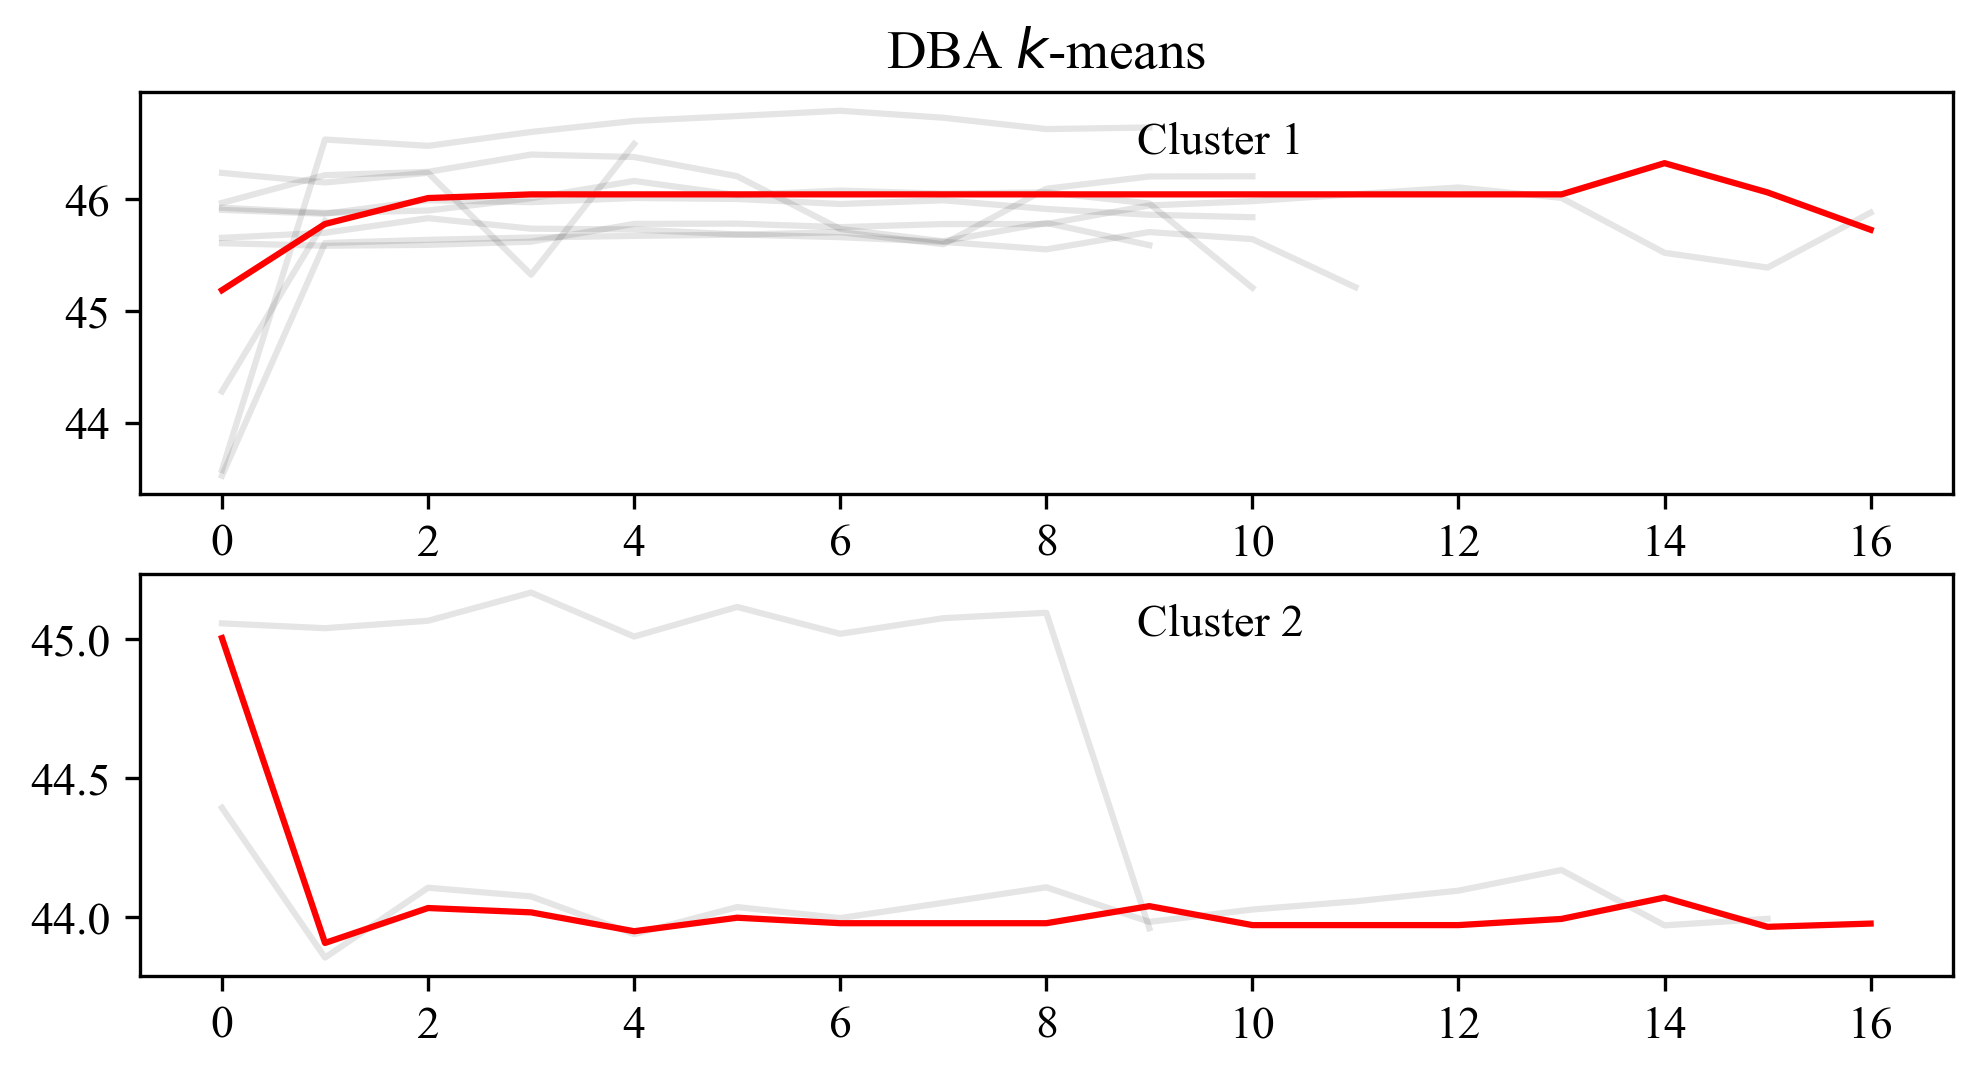

In [42]:
number_cluster = 2
from tslearn.clustering import TimeSeriesKMeans
# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=number_cluster,
                          n_init=2,
                          metric="dtw",
                          verbose=False,
                          max_iter_barycenter=100,
                          random_state=0)
y_pred = dba_km.fit_predict(X)

for yi in range(number_cluster):
    plt.subplot(number_cluster, 1, yi+1)
    for xx in X[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.1)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    #plt.xlim(0, sz)
    #plt.ylim(-4, 4)
    #plt.xscale('log')
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 0:
        plt.title("DBA $k$-means")

(array([9., 0., 0., 0., 0., 0., 0., 0., 0., 2.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

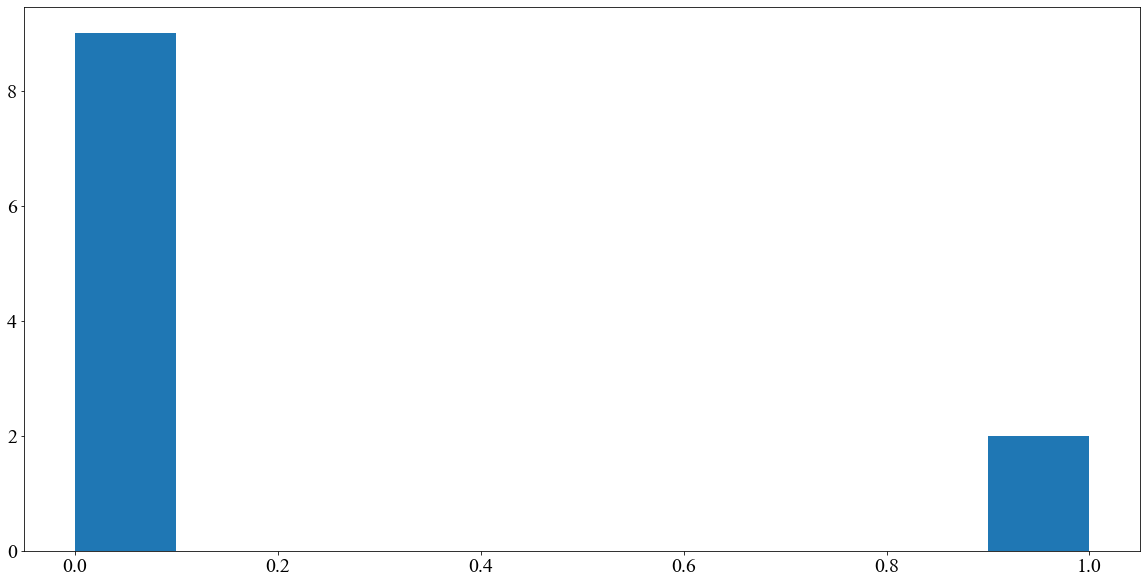

In [57]:
plt.hist(y_pred)

## Inside Phase 2
### Cluster 2

In [43]:
ts_cl_2_p2 = [TimeSeries_p2[i] for i in np.where(y_pred == 2)[0]] 

In [44]:
cl_2_shi_p2 = pd.DataFrame()
for ts in ts_cl_2_p2:
    cl_2_shi_p2 = cl_2_shi_p2.append(shi_all_p2.loc[ts.index])

In [45]:
cl_2_sh_i_mean_p2 = np.mean(cl_2_shi_p2, axis=0)
cl_2_sh_i_perc75_p2 = np.nanpercentile(cl_2_shi_p2, 75, axis=0)
cl_2_sh_i_perc25_p2 = np.nanpercentile(cl_2_shi_p2, 25, axis=0)

cl_2_sh_i_mean_db_p2 = levels_dbmyA(pd.DataFrame(cl_2_sh_i_mean_p2))
cl_2_sh_i_perc75_db_p2 = levels_dbmyA(pd.DataFrame(cl_2_sh_i_perc75_p2))
cl_2_sh_i_perc25_db_p2 = levels_dbmyA(pd.DataFrame(cl_2_sh_i_perc25_p2))

### Cluster 1

In [46]:
ts_cl_1_p2 = [TimeSeries_p2[i] for i in np.where(y_pred == 1)[0]] 

In [47]:
cl_1_shi_p2 = pd.DataFrame()
for ts in ts_cl_1_p2:
    cl_1_shi_p2 = cl_1_shi_p2.append(shi_all_p2.loc[ts.index])

In [48]:
cl_1_sh_i_mean_p2 = np.mean(cl_1_shi_p2, axis=0)
cl_1_sh_i_perc75_p2 = np.nanpercentile(cl_1_shi_p2, 75, axis=0)
cl_1_sh_i_perc25_p2 = np.nanpercentile(cl_1_shi_p2, 25, axis=0)

cl_1_sh_i_mean_db_p2 = levels_dbmyA(pd.DataFrame(cl_1_sh_i_mean_p2))
cl_1_sh_i_perc75_db_p2 = levels_dbmyA(pd.DataFrame(cl_1_sh_i_perc75_p2))
cl_1_sh_i_perc25_db_p2 = levels_dbmyA(pd.DataFrame(cl_1_sh_i_perc25_p2))

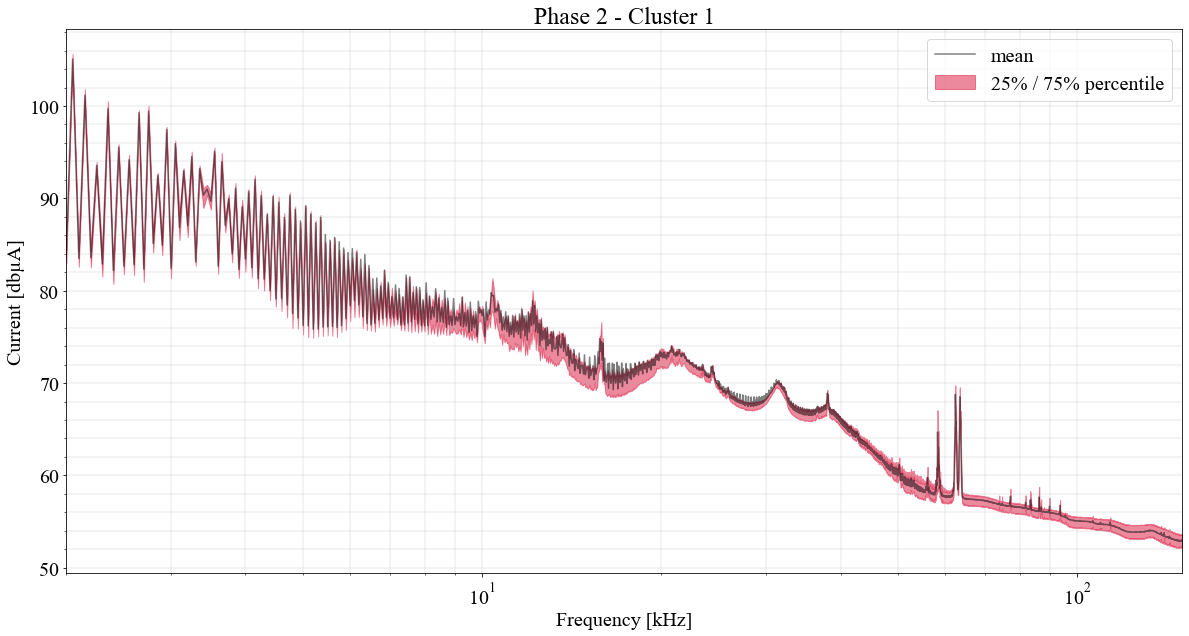

In [64]:
x = generateXAxisData()/1000

fig, ax = plt.subplots()

ax.plot(x, cl_1_sh_i_mean_db_p2, color="k", label="mean", alpha=0.5)
ax.fill_between(x, cl_1_sh_i_perc25_db_p2.values.flatten(), cl_1_sh_i_perc75_db_p2.values.flatten(), color='crimson', alpha=0.5, label="25% / 75% percentile")
ax.set_xlim(min(x), max(x))
ax.minorticks_on()
ax.grid(linewidth=0.3, which='both')
ax.set_xlabel("Frequency [kHz]")
ax.set_ylabel('Current [dbµA]')
ax.set_xscale('log')
ax.set_title('Phase 2 - Cluster 1')
ax.legend()

### Cluster 0

In [49]:
ts_cl_0_p2 = [TimeSeries_p2[i] for i in np.where(y_pred == 0)[0]] 

In [50]:
cl_0_shi_p2 = pd.DataFrame()
for ts in ts_cl_0_p2:
    cl_0_shi_p2 = cl_0_shi_p2.append(shi_all_p2.loc[ts.index])

In [51]:
cl_0_sh_i_mean_p2 = np.mean(cl_0_shi_p2, axis=0)
cl_0_sh_i_perc75_p2 = np.nanpercentile(cl_0_shi_p2, 75, axis=0)
cl_0_sh_i_perc25_p2 = np.nanpercentile(cl_0_shi_p2, 25, axis=0)

cl_0_sh_i_mean_db_p2 = levels_dbmyA(pd.DataFrame(cl_0_sh_i_mean_p2))
cl_0_sh_i_perc75_db_p2 = levels_dbmyA(pd.DataFrame(cl_0_sh_i_perc75_p2))
cl_0_sh_i_perc25_db_p2 = levels_dbmyA(pd.DataFrame(cl_0_sh_i_perc25_p2))

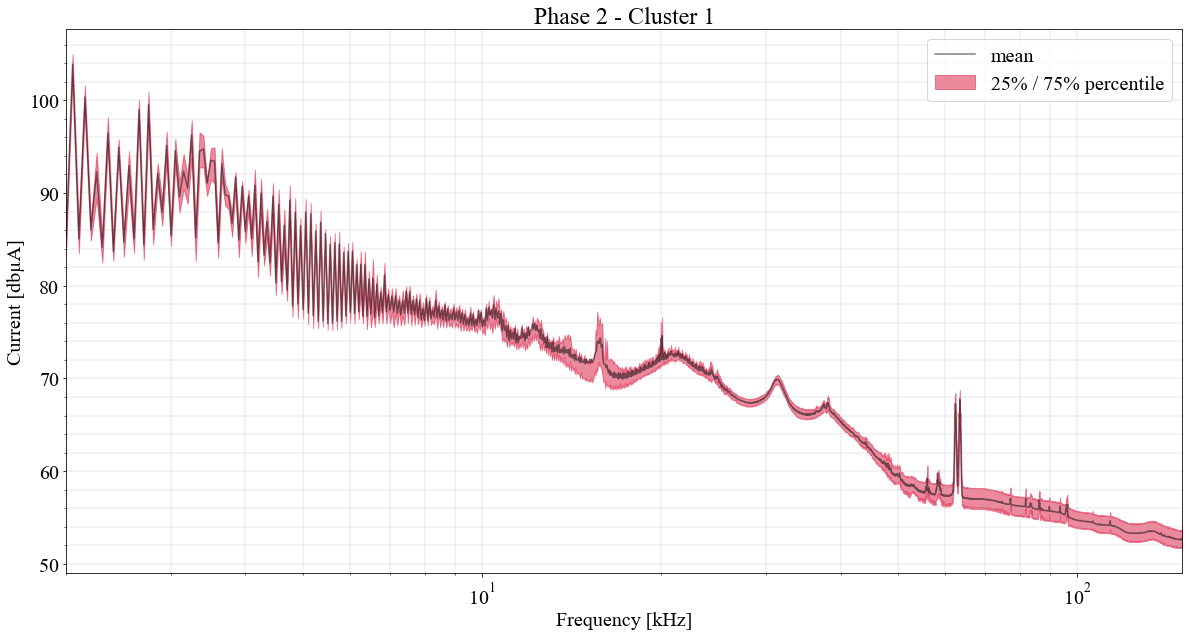

In [68]:
x = generateXAxisData()/1000

fig, ax = plt.subplots()

ax.plot(x, cl_0_sh_i_mean_db_p2, color="k", label="mean", alpha=0.5)
ax.fill_between(x, cl_0_sh_i_perc25_db_p2.values.flatten(), cl_0_sh_i_perc75_db_p2.values.flatten(), color='crimson', alpha=0.5, label="25% / 75% percentile")
ax.set_xlim(min(x), max(x))
ax.minorticks_on()
ax.grid(linewidth=0.3, which='both')
ax.set_xlabel("Frequency [kHz]")
ax.set_ylabel('Current [dbµA]')
ax.set_xscale('log')
ax.set_title('Phase 2 - Cluster 1')
ax.legend()

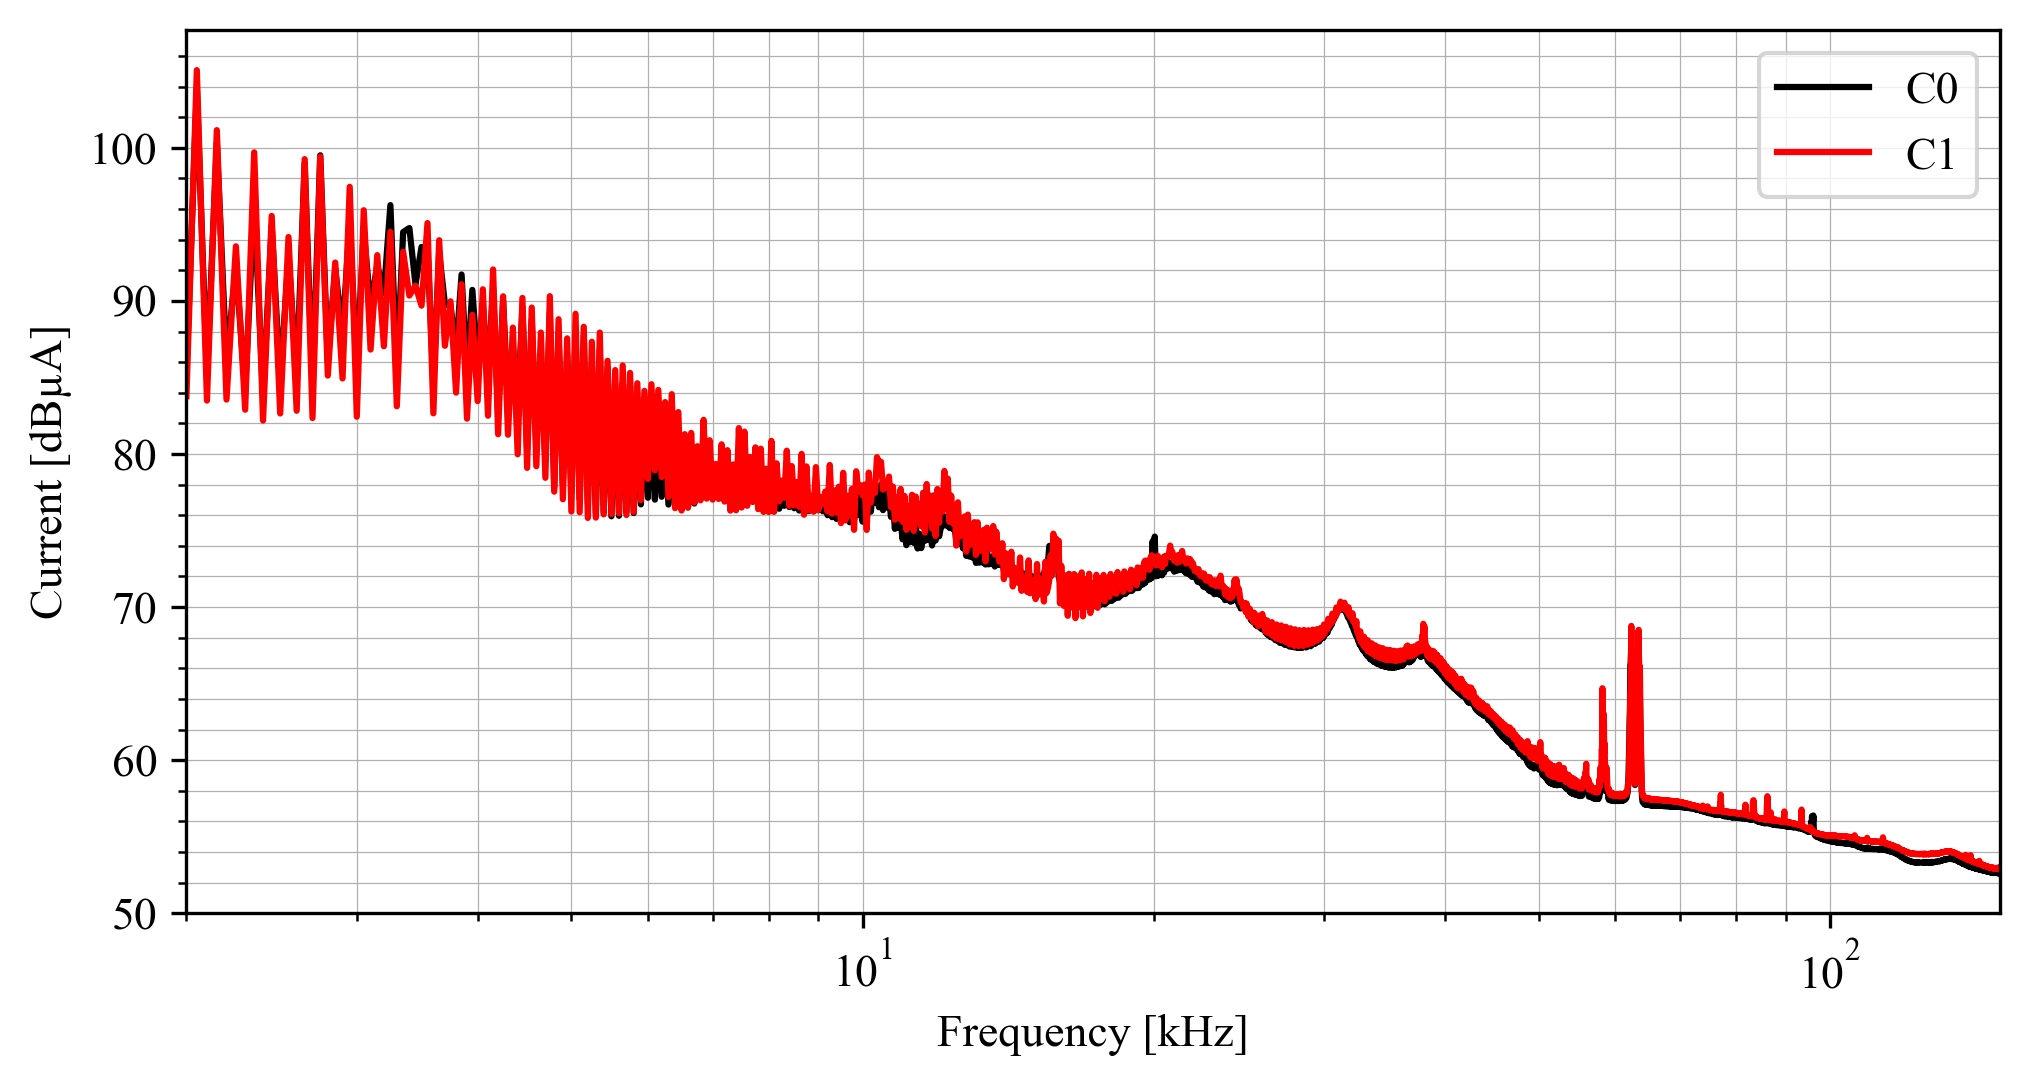

In [64]:
x = generateXAxisData()/1000

fig, ax = plt.subplots()

ax.plot(x, cl_0_sh_i_mean_db_p2, color="k", label="C0", alpha=1)
ax.plot(x, cl_1_sh_i_mean_db_p2, color="r", label="C1", alpha=1)

ax.set_xlim(min(x), max(x))
ax.minorticks_on()
ax.grid(linewidth=0.3, which='both')
ax.set_xlabel("Frequency [kHz]")
ax.set_ylabel('Current [dBµA]')
ax.set_xscale('log')
ax.legend()

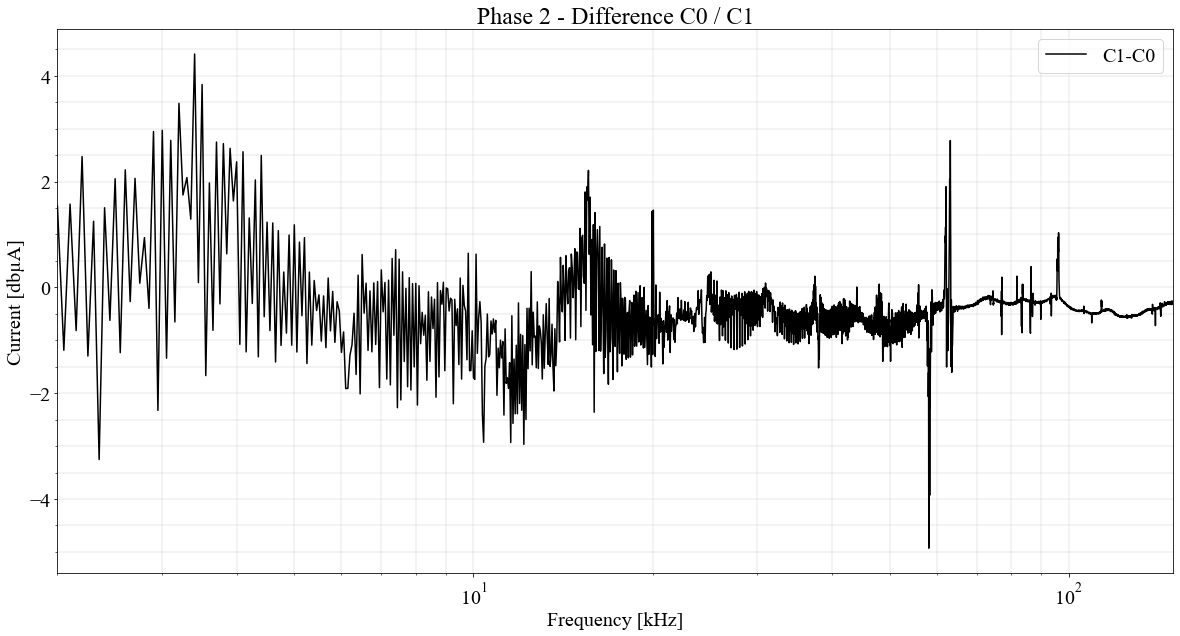

In [70]:
x = generateXAxisData()/1000

fig, ax = plt.subplots()

ax.plot(x, (cl_0_sh_i_mean_db_p2-cl_1_sh_i_mean_db_p2), color="k", label="C1-C0", alpha=1)

ax.set_xlim(min(x), max(x))
ax.minorticks_on()
ax.grid(linewidth=0.3, which='both')
ax.set_xlabel("Frequency [kHz]")
ax.set_ylabel('Current [dbµA]')
ax.set_xscale('log')
ax.set_title('Phase 2 - Difference C0 / C1')
ax.legend()

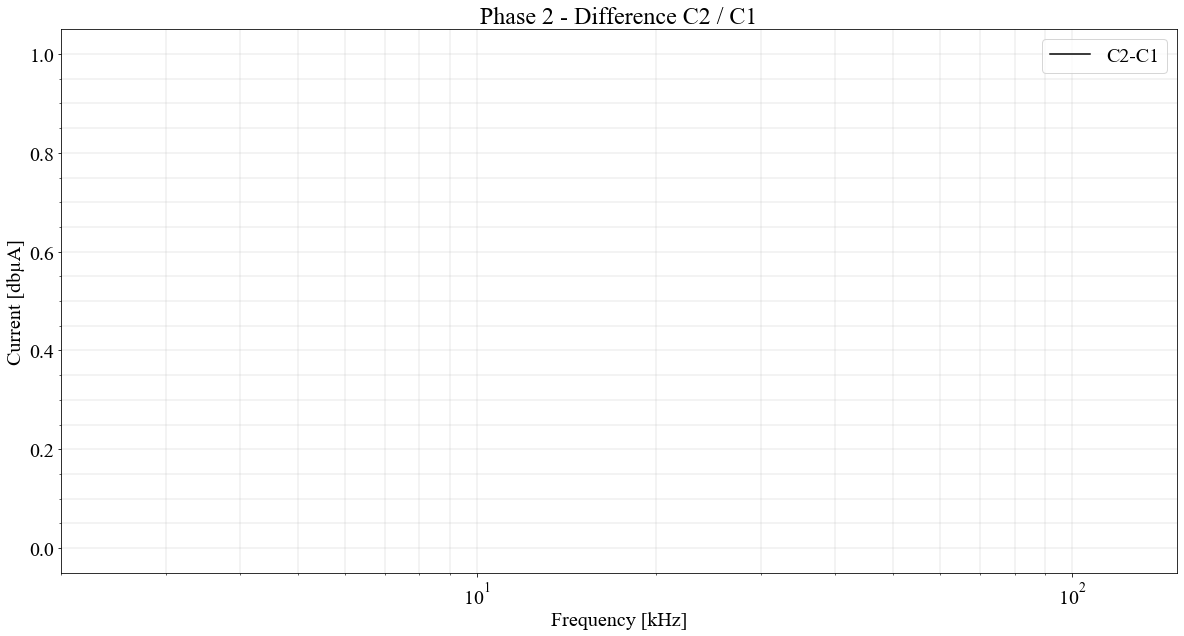

In [71]:
x = generateXAxisData()/1000

fig, ax = plt.subplots()

ax.plot(x, (cl_2_sh_i_mean_db_p2-cl_1_sh_i_mean_db_p2), color="k", label="C2-C1", alpha=1)

ax.set_xlim(min(x), max(x))
ax.minorticks_on()
ax.grid(linewidth=0.3, which='both')
ax.set_xlabel("Frequency [kHz]")
ax.set_ylabel('Current [dbµA]')
ax.set_xscale('log')
ax.set_title('Phase 2 - Difference C2 / C1')
ax.legend()

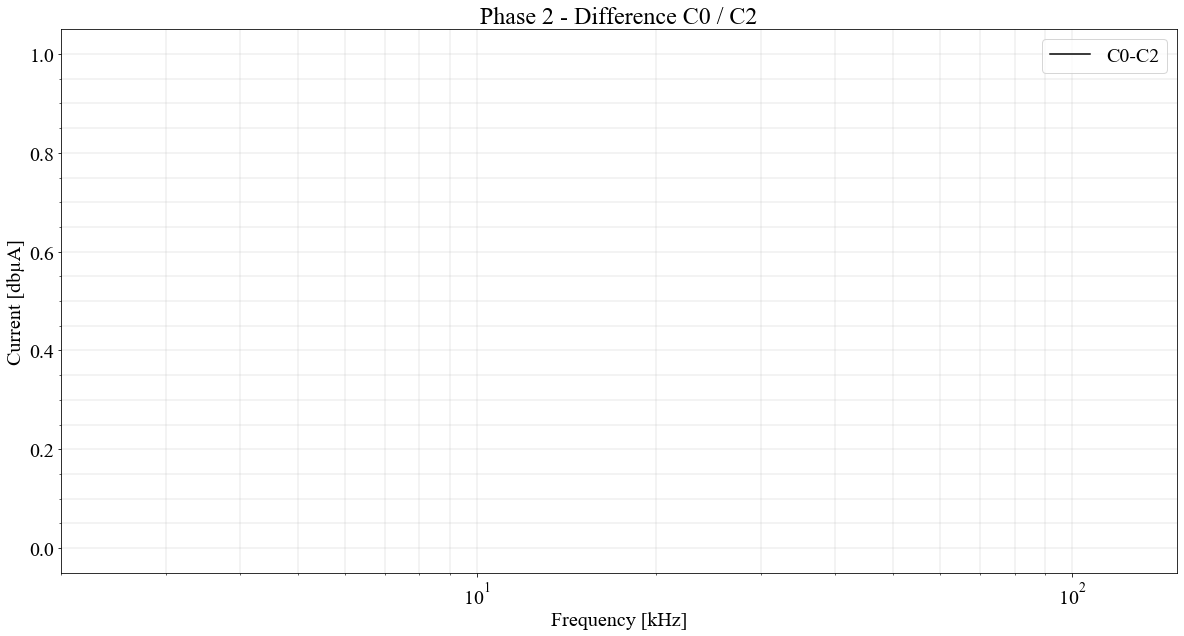

In [72]:
x = generateXAxisData()/1000

fig, ax = plt.subplots()

ax.plot(x, (cl_0_sh_i_mean_db_p2-cl_2_sh_i_mean_db_p2), color="k", label="C0-C2", alpha=1)

ax.set_xlim(min(x), max(x))
ax.minorticks_on()
ax.grid(linewidth=0.3, which='both')
ax.set_xlabel("Frequency [kHz]")
ax.set_ylabel('Current [dbµA]')
ax.set_xscale('log')
ax.set_title('Phase 2 - Difference C0 / C2')
ax.legend()

# Cluster Phase 3

In [52]:
from tslearn.utils import to_time_series_dataset
X = to_time_series_dataset(TimeSeries_p3)

DBA k-means


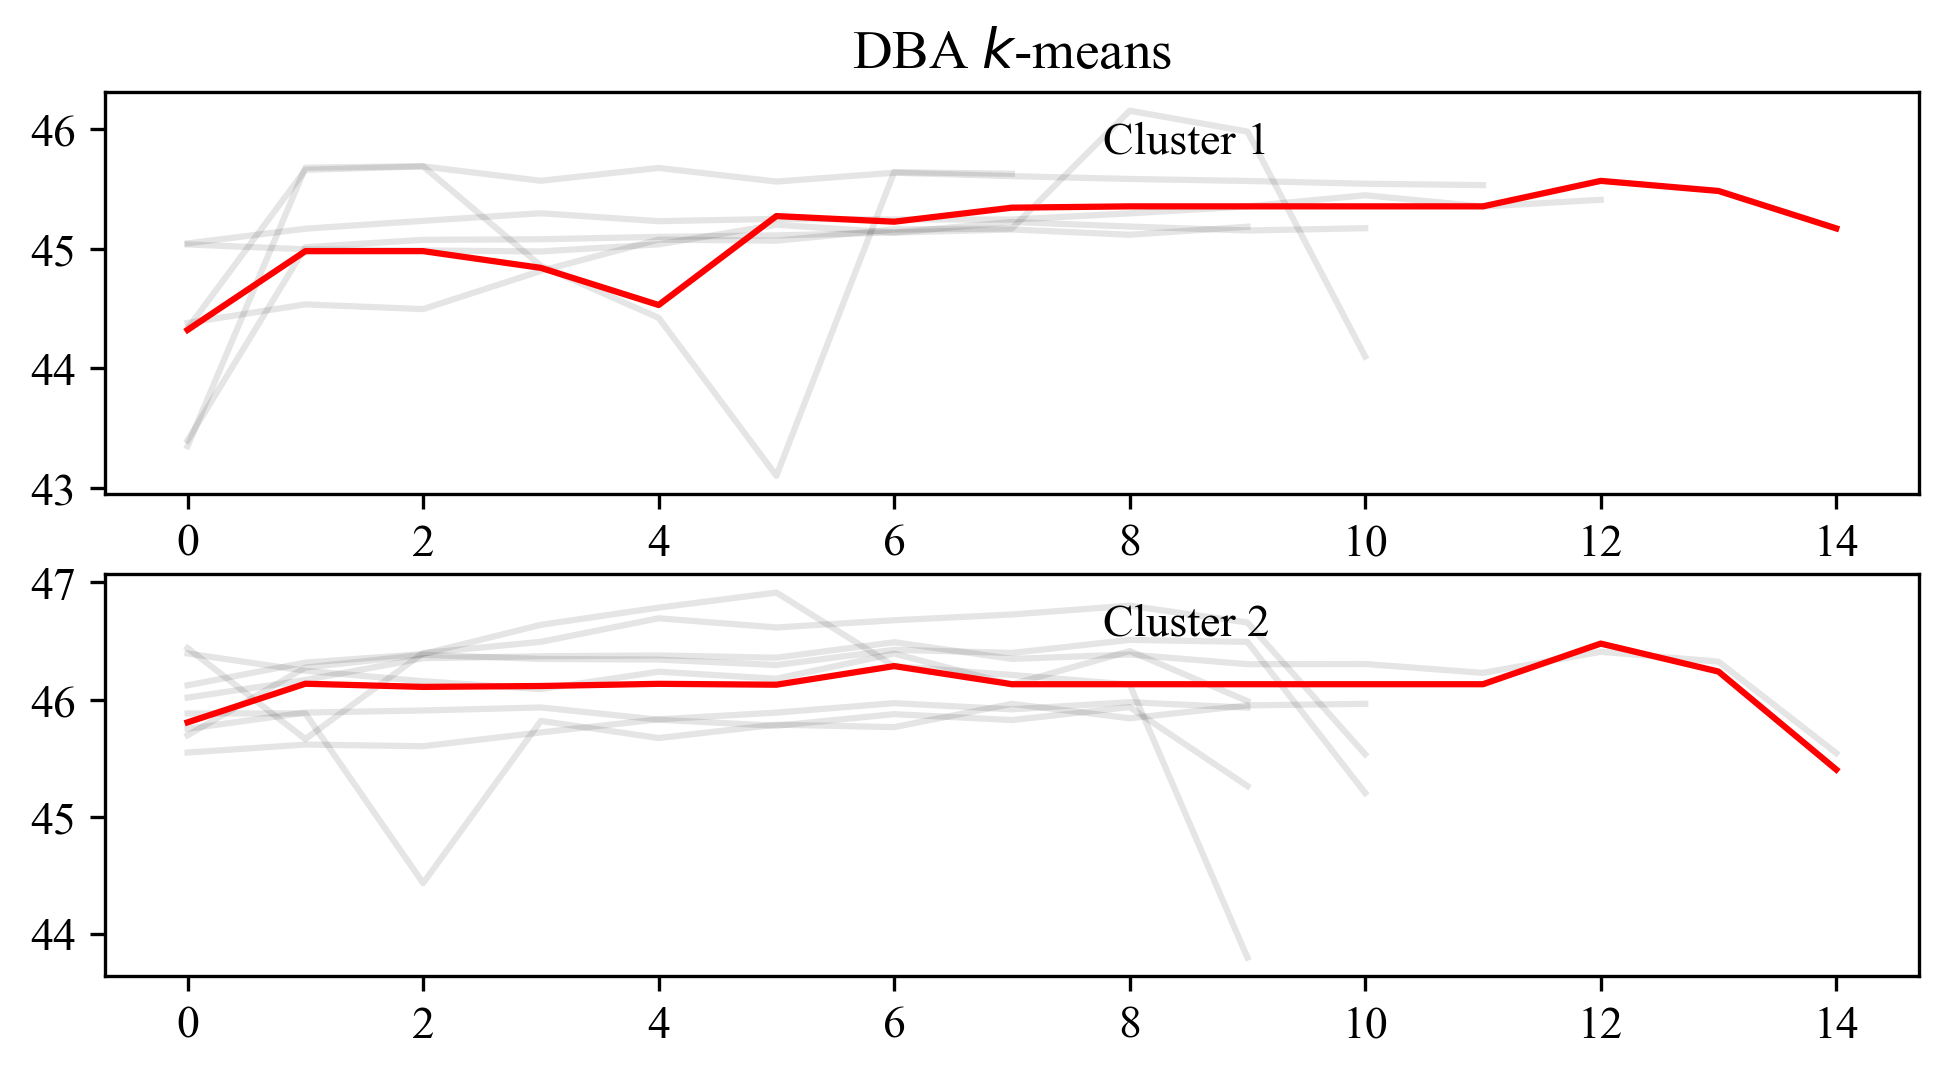

In [53]:
number_cluster = 2
from tslearn.clustering import TimeSeriesKMeans
# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=number_cluster,
                          n_init=2,
                          metric="dtw",
                          verbose=False,
                          max_iter_barycenter=100,
                          random_state=0)
y_pred = dba_km.fit_predict(X)

for yi in range(number_cluster):
    plt.subplot(number_cluster, 1, yi+1)
    for xx in X[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.1)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    #plt.xlim(0, sz)
    #plt.ylim(-4, 4)
    #plt.xscale('log')
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 0:
        plt.title("DBA $k$-means")

(array([6., 0., 0., 0., 0., 0., 0., 0., 0., 8.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

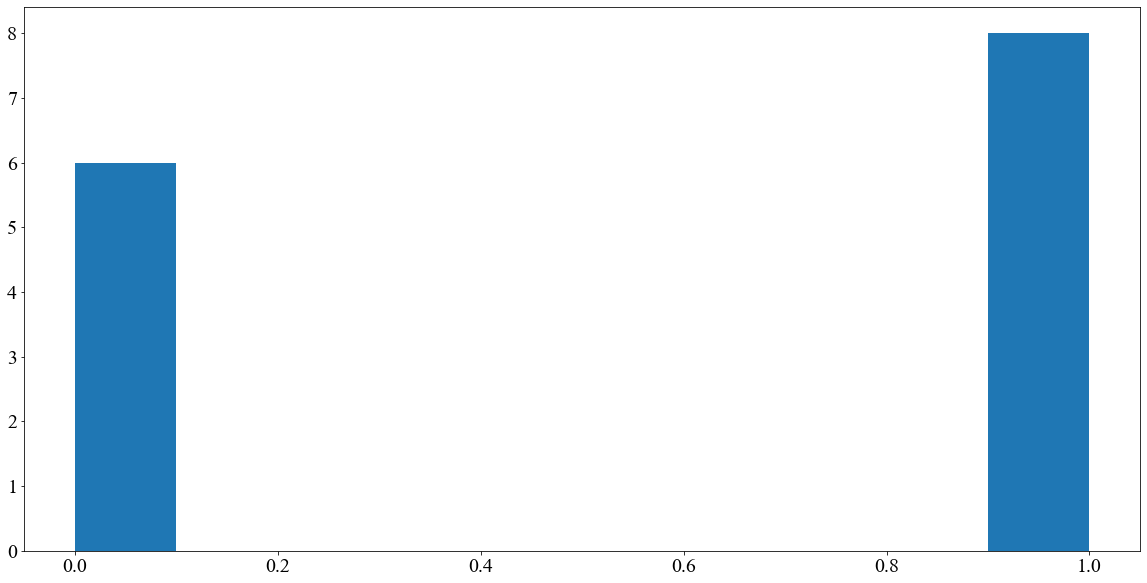

In [75]:
plt.hist(y_pred)

## Inside Phase 3
### Cluster 2

In [54]:
ts_cl_2_p3 = [TimeSeries_p3[i] for i in np.where(y_pred == 2)[0]] 

In [55]:
cl_2_shi_p3 = pd.DataFrame()
for ts in ts_cl_2_p3:
    cl_2_shi_p3 = cl_2_shi_p3.append(shi_all_p3.loc[ts.index])

In [56]:
cl_2_sh_i_mean_p3 = np.mean(cl_2_shi_p2, axis=0)
cl_2_sh_i_perc75_p3 = np.nanpercentile(cl_2_shi_p2, 75, axis=0)
cl_2_sh_i_perc25_p3 = np.nanpercentile(cl_2_shi_p2, 25, axis=0)

cl_2_sh_i_mean_db_p3 = levels_dbmyA(pd.DataFrame(cl_2_sh_i_mean_p3))
cl_2_sh_i_perc75_db_p3 = levels_dbmyA(pd.DataFrame(cl_2_sh_i_perc75_p3))
cl_2_sh_i_perc25_db_p3 = levels_dbmyA(pd.DataFrame(cl_2_sh_i_perc25_p3))

### Cluster 1

In [57]:
ts_cl_1_p3 = [TimeSeries_p3[i] for i in np.where(y_pred == 1)[0]] 

In [58]:
cl_1_shi_p3 = pd.DataFrame()
for ts in ts_cl_1_p3:
    cl_1_shi_p3 = cl_1_shi_p3.append(shi_all_p3.loc[ts.index])

In [59]:
cl_1_sh_i_mean_p3 = np.mean(cl_1_shi_p2, axis=0)
cl_1_sh_i_perc75_p3 = np.nanpercentile(cl_1_shi_p2, 75, axis=0)
cl_1_sh_i_perc25_p3 = np.nanpercentile(cl_1_shi_p2, 25, axis=0)

cl_1_sh_i_mean_db_p3 = levels_dbmyA(pd.DataFrame(cl_1_sh_i_mean_p3))
cl_1_sh_i_perc75_db_p3 = levels_dbmyA(pd.DataFrame(cl_1_sh_i_perc75_p3))
cl_1_sh_i_perc25_db_p3 = levels_dbmyA(pd.DataFrame(cl_1_sh_i_perc25_p3))

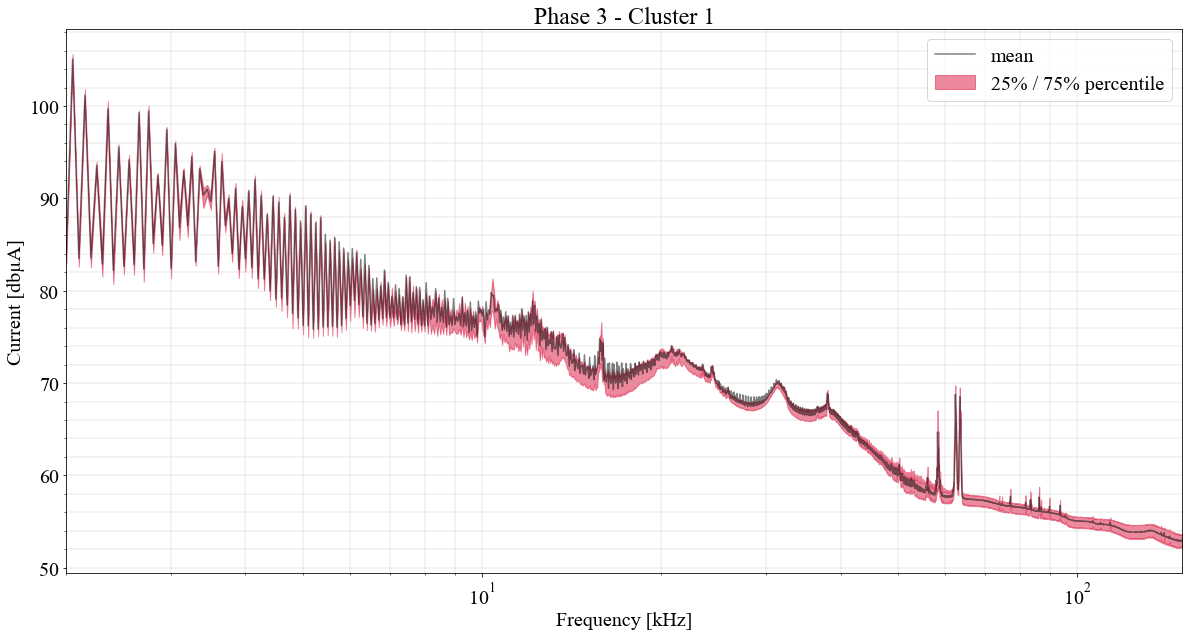

In [82]:
x = generateXAxisData()/1000

fig, ax = plt.subplots()

ax.plot(x, cl_1_sh_i_mean_db_p3, color="k", label="mean", alpha=0.5)
ax.fill_between(x, cl_1_sh_i_perc25_db_p3.values.flatten(), cl_1_sh_i_perc75_db_p3.values.flatten(), color='crimson', alpha=0.5, label="25% / 75% percentile")
ax.set_xlim(min(x), max(x))
ax.minorticks_on()
ax.grid(linewidth=0.3, which='both')
ax.set_xlabel("Frequency [kHz]")
ax.set_ylabel('Current [dbµA]')
ax.set_xscale('log')
ax.set_title('Phase 3 - Cluster 1')
ax.legend()

### Cluster 0

In [60]:
ts_cl_0_p3 = [TimeSeries_p3[i] for i in np.where(y_pred == 0)[0]] 

In [61]:
cl_0_shi_p3 = pd.DataFrame()
for ts in ts_cl_0_p3:
    cl_0_shi_p3 = cl_0_shi_p3.append(shi_all_p3.loc[ts.index])

In [62]:
cl_0_sh_i_mean_p3 = np.mean(cl_0_shi_p2, axis=0)
cl_0_sh_i_perc75_p3 = np.nanpercentile(cl_0_shi_p2, 75, axis=0)
cl_0_sh_i_perc25_p3 = np.nanpercentile(cl_0_shi_p2, 25, axis=0)

cl_0_sh_i_mean_db_p3 = levels_dbmyA(pd.DataFrame(cl_0_sh_i_mean_p3))
cl_0_sh_i_perc75_db_p3 = levels_dbmyA(pd.DataFrame(cl_0_sh_i_perc75_p3))
cl_0_sh_i_perc25_db_p3 = levels_dbmyA(pd.DataFrame(cl_0_sh_i_perc25_p3))

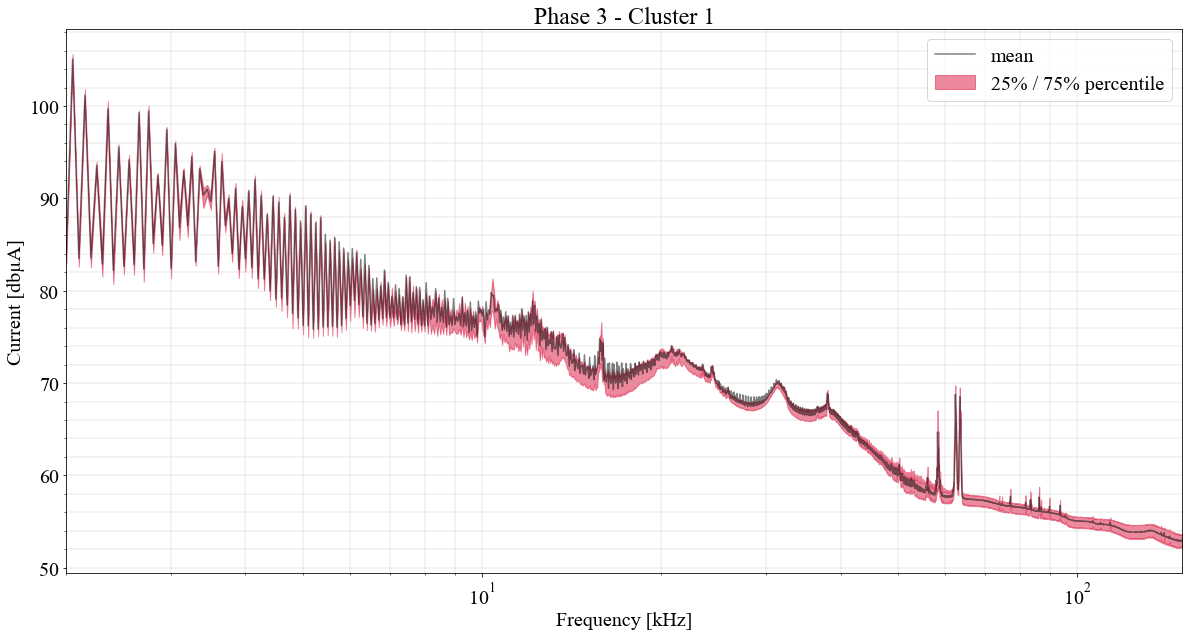

In [86]:
x = generateXAxisData()/1000

fig, ax = plt.subplots()

ax.plot(x, cl_1_sh_i_mean_db_p3, color="k", label="mean", alpha=0.5)
ax.fill_between(x, cl_1_sh_i_perc25_db_p3.values.flatten(), cl_1_sh_i_perc75_db_p3.values.flatten(), color='crimson', alpha=0.5, label="25% / 75% percentile")
ax.set_xlim(min(x), max(x))
ax.minorticks_on()
ax.grid(linewidth=0.3, which='both')
ax.set_xlabel("Frequency [kHz]")
ax.set_ylabel('Current [dbµA]')
ax.set_xscale('log')
ax.set_title('Phase 3 - Cluster 1')
ax.legend()

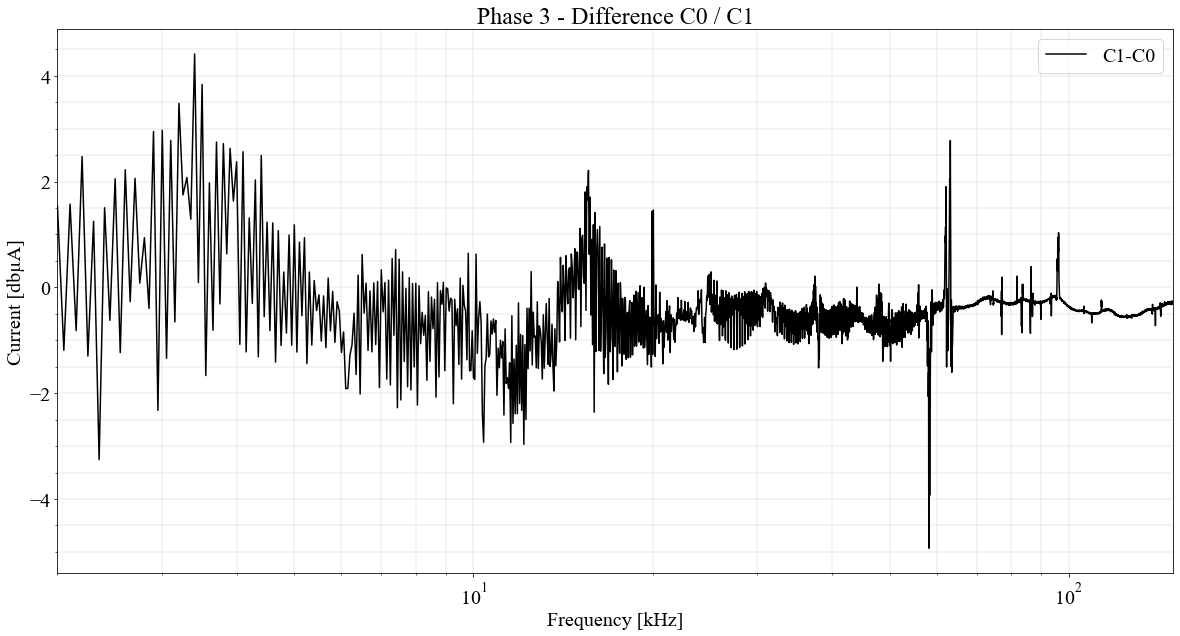

In [87]:
x = generateXAxisData()/1000

fig, ax = plt.subplots()

ax.plot(x, (cl_0_sh_i_mean_db_p3-cl_1_sh_i_mean_db_p3), color="k", label="C1-C0", alpha=1)

ax.set_xlim(min(x), max(x))
ax.minorticks_on()
ax.grid(linewidth=0.3, which='both')
ax.set_xlabel("Frequency [kHz]")
ax.set_ylabel('Current [dbµA]')
ax.set_xscale('log')
ax.set_title('Phase 3 - Difference C0 / C1')
ax.legend()

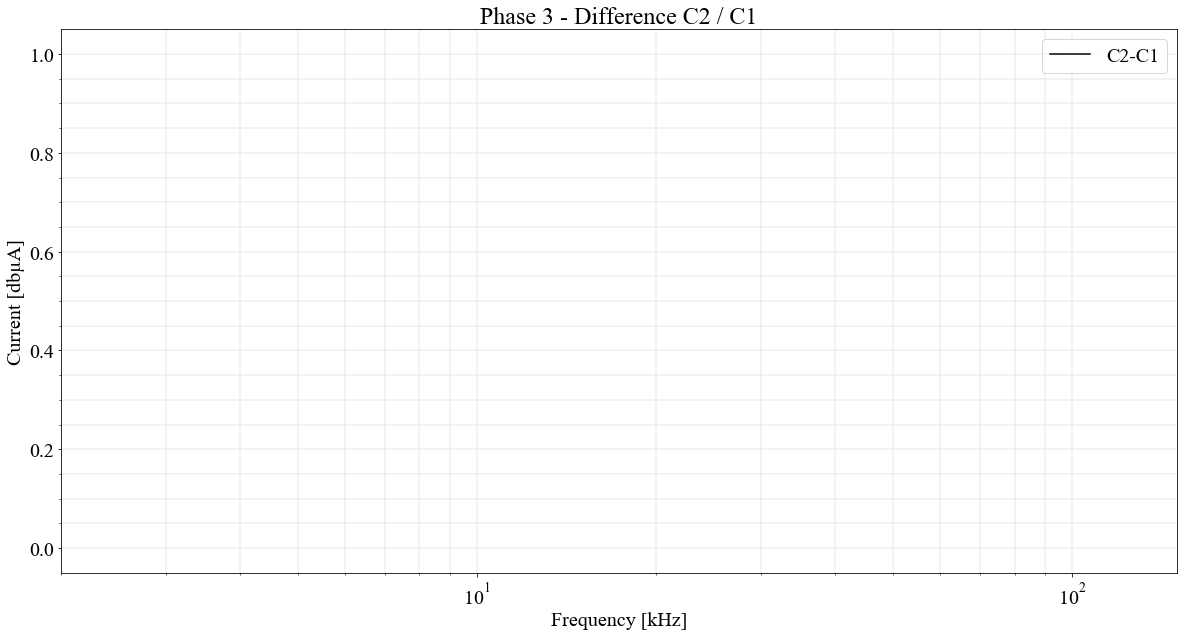

In [88]:
x = generateXAxisData()/1000

fig, ax = plt.subplots()

ax.plot(x, (cl_2_sh_i_mean_db_p3-cl_1_sh_i_mean_db_p3), color="k", label="C2-C1", alpha=1)

ax.set_xlim(min(x), max(x))
ax.minorticks_on()
ax.grid(linewidth=0.3, which='both')
ax.set_xlabel("Frequency [kHz]")
ax.set_ylabel('Current [dbµA]')
ax.set_xscale('log')
ax.set_title('Phase 3 - Difference C2 / C1')
ax.legend()

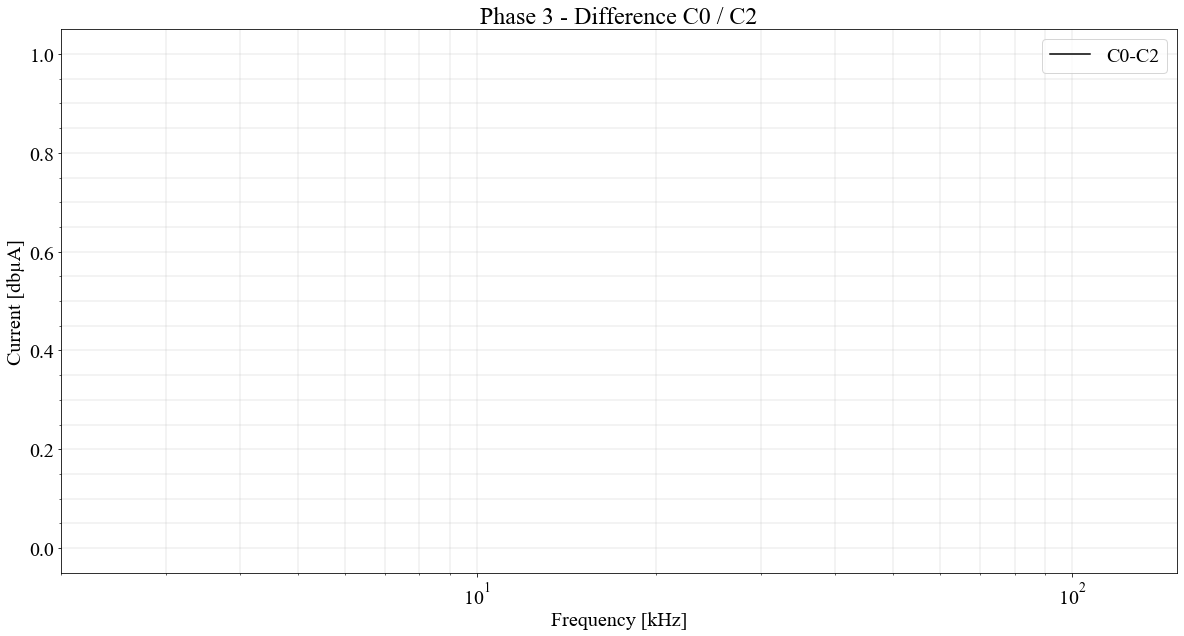

In [89]:
x = generateXAxisData()/1000

fig, ax = plt.subplots()

ax.plot(x, (cl_0_sh_i_mean_db_p3-cl_2_sh_i_mean_db_p3), color="k", label="C0-C2", alpha=1)

ax.set_xlim(min(x), max(x))
ax.minorticks_on()
ax.grid(linewidth=0.3, which='both')
ax.set_xlabel("Frequency [kHz]")
ax.set_ylabel('Current [dbµA]')
ax.set_xscale('log')
ax.set_title('Phase 3 - Difference C0 / C2')
ax.legend()

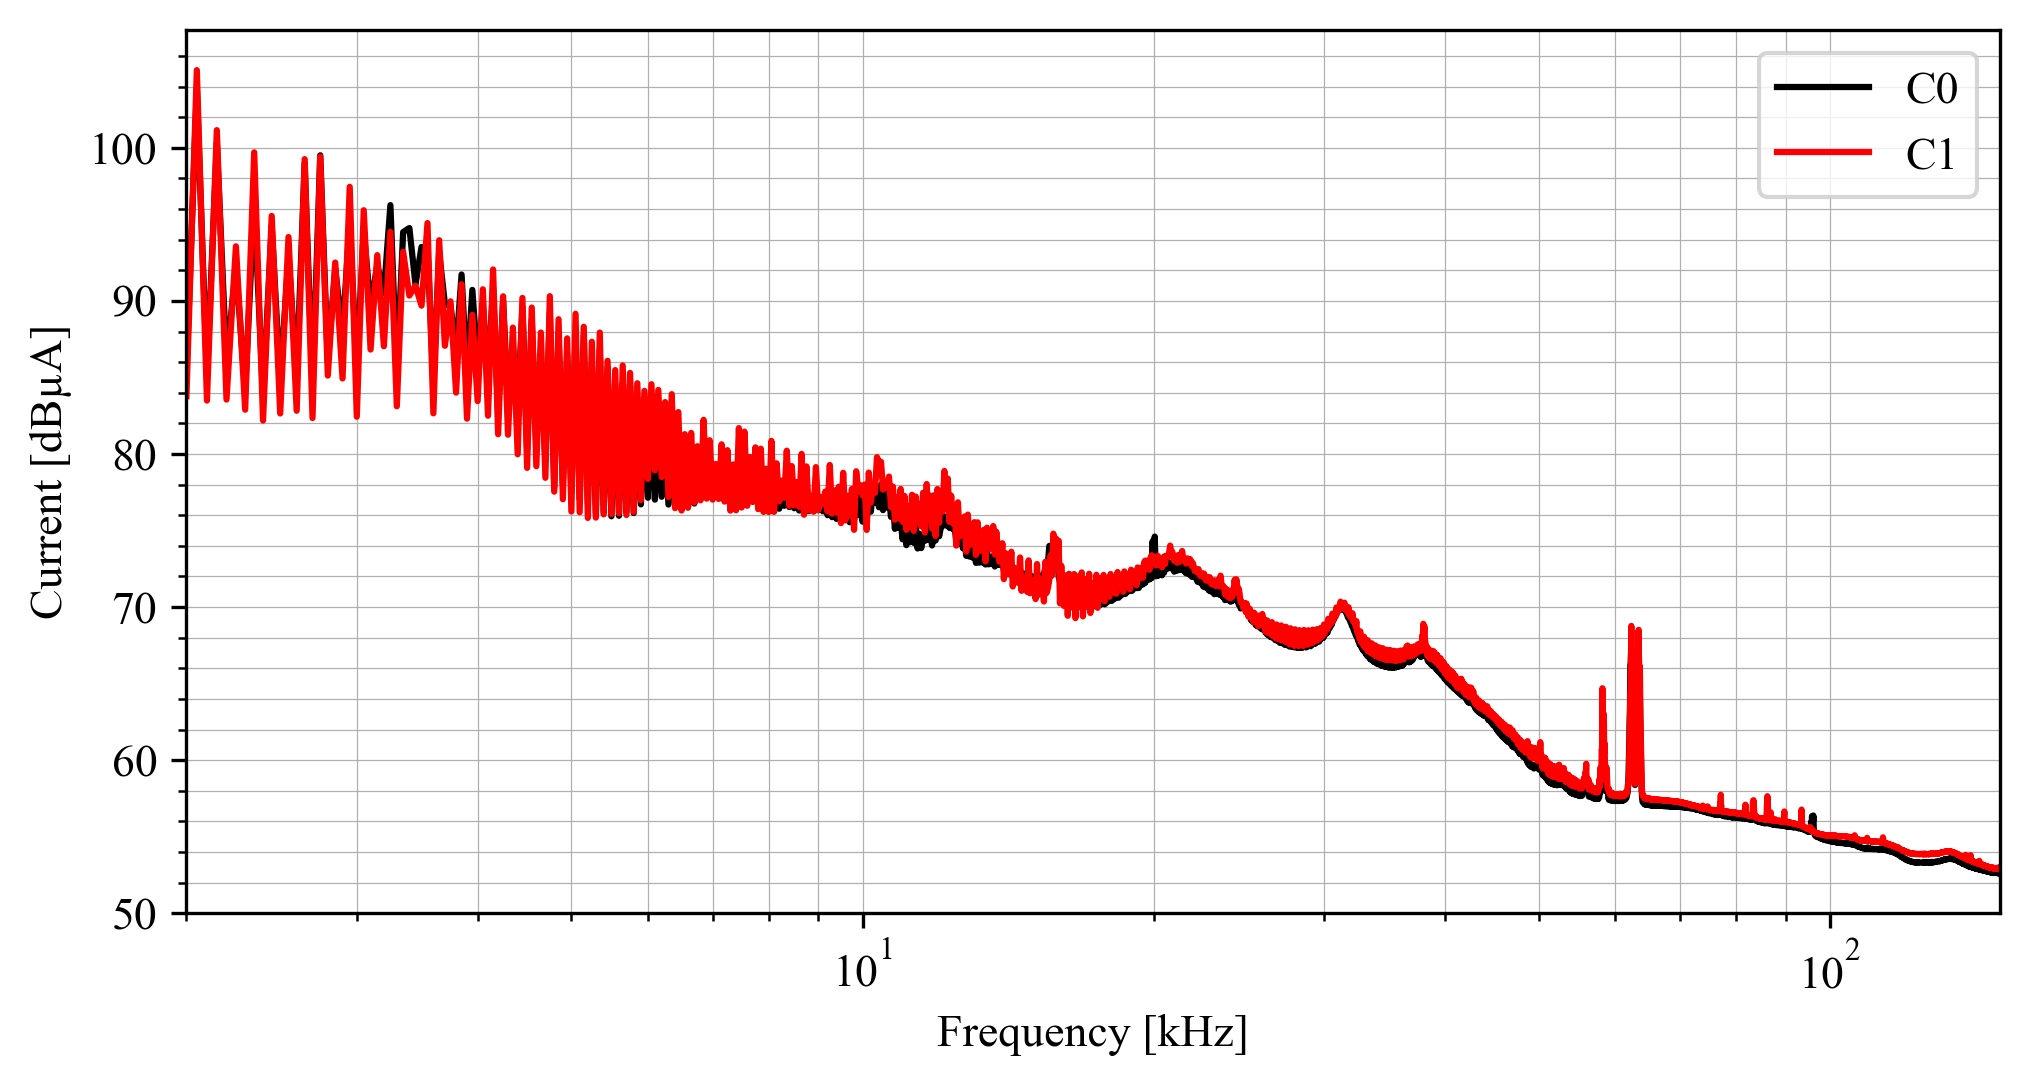

In [63]:
x = generateXAxisData()/1000

fig, ax = plt.subplots()

ax.plot(x, cl_0_sh_i_mean_db_p2, color="k", label="C0", alpha=1)
ax.plot(x, cl_1_sh_i_mean_db_p2, color="r", label="C1", alpha=1)

ax.set_xlim(min(x), max(x))
ax.minorticks_on()
ax.grid(linewidth=0.3, which='both')
ax.set_xlabel("Frequency [kHz]")
ax.set_ylabel('Current [dBµA]')
ax.set_xscale('log')
ax.legend()